# minGPT

**Note:** The `autoreload` extension allows the interpreter to reload modules every time a cell is executed. This is useful when editing the code in a module. The following cell enables the extension and downloads the minGPT package from Github. You can now double-click on a file like model.py, edit its contents, and press Ctrl+S to save it. If you then re-run the notebook cells, including those that create an object of the corresponding class, you will see the changes reflected. Note that the next cell should *only be executed once*, as running `pip install` again will overwrite the modified contents of the module.

Recall that changes in the files (except the notebook itself) are not persistent unless you connect them to your Google Drive account.

In [ ]:
%load_ext autoreload
%autoreload 2
%pip install -e 'git+https://github.com/karpathy/minGPT.git@37baab71b9abea1b76ab957409a1cc2fbfba8a26#egg=mingpt'

# Fix this issue: https://github.com/karpathy/minGPT/issues/120
#!sed -i '200s/.*/        assert len(keys) == len([k for k in sd if not k.endswith(".attn.bias")])/' /content/src/mingpt/mingpt/model.py


Obtaining mingpt from git+https://github.com/karpathy/minGPT.git@37baab71b9abea1b76ab957409a1cc2fbfba8a26#egg=mingpt
  Cloning https://github.com/karpathy/minGPT.git (to revision 37baab71b9abea1b76ab957409a1cc2fbfba8a26) to ./.venv/src/mingpt
  Running command git clone --filter=blob:none --quiet https://github.com/karpathy/minGPT.git /home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/.venv/src/mingpt
  Running command git rev-parse -q --verify 'sha^37baab71b9abea1b76ab957409a1cc2fbfba8a26'
  Running command git fetch -q https://github.com/karpathy/minGPT.git 37baab71b9abea1b76ab957409a1cc2fbfba8a26
  Resolved https://github.com/karpathy/minGPT.git to commit 37baab71b9abea1b76ab957409a1cc2fbfba8a26
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mingpt (pyproject.toml) ... done
  Created wheel f

Add module's location to PYTHONPATH, which tells your Python interpreter where to search modules for. The previous `pip install -e` changes the variable in a subshell and the interpreter is therefore not aware of the updated value.

In [1]:
!python -m pip install --upgrade --force-reinstall "mingpt @ git+https://github.com/karpathy/minGPT.git@37baab71b9abea1b76ab957409a1cc2fbfba8a26"


  Using cached mingpt-0.0.1-py3-none-any.whl
  Using cached torch-2.9.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached filelock-3.20.2-py3-none-any.whl.metadata (2.1 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.12.0-py3-none-any.whl.metadata (10 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cudnn_cu12-9.10.2.21-py3

In [2]:
import sys
sys.path.append('/content/src/mingpt')

In [3]:
!pip install transformers

  Using cached transformers-4.57.3-py3-none-any.whl.metadata (43 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached numpy-2.4.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (6.6 kB)
  Using cached pyyaml-6.0.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (2.4 kB)
  Using cached regex-2025.11.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (40 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tokenizers-0.22.2-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.3 kB)
  Using cached safetensors-0.7.0-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached hf_xet-1.2.0-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
  Using cached charset_normalizer-3.4.4-cp312-cp312-

In [4]:
import sys
print(sys.executable)


/home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/.venv/bin/python


In [2]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from mingpt.model import GPT
from mingpt.utils import set_seed
from mingpt.bpe import BPETokenizer
set_seed(3407)

/home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_mingpt = True # use minGPT or huggingface/transformers model?
model_type = 'gpt2'
device = 'cuda'

In [4]:
if use_mingpt:
    model = GPT.from_pretrained(model_type)
else:
    model = GPT2LMHeadModel.from_pretrained(model_type)
    model.config.pad_token_id = model.config.eos_token_id # suppress a warning

# ship model to device and set to eval mode
model.to(device)
model.eval();

number of parameters: 124.44M


In [4]:

def generate(prompt='', num_samples=10, steps=20, do_sample=True):

    # tokenize the input prompt into integer input sequence
    if use_mingpt:
        tokenizer = BPETokenizer()
        if prompt == '':
            # to create unconditional samples...
            # manually create a tensor with only the special <|endoftext|> token
            # similar to what openai's code does here https://github.com/openai/gpt-2/blob/master/src/generate_unconditional_samples.py
            x = torch.tensor([[tokenizer.encoder.encoder['<|endoftext|>']]], dtype=torch.long)
        else:
            x = tokenizer(prompt).to(device)
    else:
        tokenizer = GPT2Tokenizer.from_pretrained(model_type)
        if prompt == '':
            # to create unconditional samples...
            # huggingface/transformers tokenizer special cases these strings
            prompt = '<|endoftext|>'
        encoded_input = tokenizer(prompt, return_tensors='pt').to(device)
        x = encoded_input['input_ids']

    # we'll process all desired num_samples in a batch, so expand out the batch dim
    x = x.expand(num_samples, -1)

    # forward the model `steps` times to get samples, in a batch
    y = model.generate(x, max_new_tokens=steps, do_sample=do_sample, top_k=40)

    for i in range(num_samples):
        out = tokenizer.decode(y[i].cpu().squeeze())
        print('-'*80)
        print(out)


In [8]:
generate(prompt='Andrej Karpathy, the Earth representative on', num_samples=10, steps=20)

--------------------------------------------------------------------------------
Andrej Karpathy, the Earth representative on NASA's Juno mission, will also receive this year's award.

While his experience shows that
--------------------------------------------------------------------------------
Andrej Karpathy, the Earth representative on Russia's delegation to the G20 summit, spoke about his work to end climate change in his blog
--------------------------------------------------------------------------------
Andrej Karpathy, the Earth representative on the United Nations Security Council who was asked on Monday to take a position on climate change in order to
--------------------------------------------------------------------------------
Andrej Karpathy, the Earth representative on the UN climate conference in Paris where he was one of the leading climate advocates, said the decision to
--------------------------------------------------------------------------------
Andrej Karpath

In [ ]:
%%writefile repo_orientation.py
"""
What this script does:
- Prints where mingpt is installed.
- Locates mingpt/model.py.
- Extracts/prints the key lines of GPT.forward that matter for the assignment:
  embeddings -> transformer blocks -> ln_f -> lm_head -> logits
- Provides programmatic checks used by unit tests.

This does NOT implement activation caching/patching yet. 
"""

from __future__ import annotations

import inspect
import pathlib
import re
from dataclasses import dataclass
from typing import Dict, List, Tuple

import mingpt
import mingpt.model
from mingpt.model import GPT


@dataclass(frozen=True)
class ForwardLandmarks:
    has_tok_emb: bool
    has_pos_emb: bool
    has_blocks_loop: bool
    has_ln_f: bool
    has_lm_head: bool


def get_paths() -> Dict[str, str]:
    pkg_path = pathlib.Path(mingpt.__file__).resolve()
    model_path = pathlib.Path(mingpt.model.__file__).resolve()
    return {
        "mingpt.__file__": str(pkg_path),
        "mingpt.model.__file__": str(model_path),
    }


def read_model_source() -> str:
    model_path = pathlib.Path(mingpt.model.__file__).resolve()
    return model_path.read_text(encoding="utf-8")


def attn_bias_fix_present(model_source: str) -> bool:
    # Required fix: assert len(keys) == len([k for k in sd if not k.endswith(".attn.bias")])
    return 'len([k for k in sd if not k.endswith(".attn.bias")])' in model_source


def forward_source() -> str:
    return inspect.getsource(GPT.forward)


def find_forward_landmarks(src: str) -> ForwardLandmarks:
    has_tok_emb = ("tok_emb" in src) and ("wte" in src)
    has_pos_emb = ("pos_emb" in src) and ("wpe" in src)

    has_blocks_loop = (
        re.search(r"\bfor\b\s+.+\s+\bin\b\s+.*self\.transformer\.h", src) is not None
        or re.search(r"\bfor\b\s+.+\s+\bin\b\s+.*self\.transformer\['h'\]", src) is not None
    )

    has_ln_f = "ln_f" in src
    has_lm_head = ("lm_head" in src) and ("logits" in src)

    return ForwardLandmarks(
        has_tok_emb=has_tok_emb,
        has_pos_emb=has_pos_emb,
        has_blocks_loop=has_blocks_loop,
        has_ln_f=has_ln_f,
        has_lm_head=has_lm_head,
    )


def print_forward_snippet(src: str, max_lines: int = 80) -> None:
    lines = src.splitlines()
    print("=== GPT.forward (snippet) ===")
    for i, line in enumerate(lines[:max_lines], start=1):
        print(f"{i:03d}: {line}")
    if len(lines) > max_lines:
        print(f"... ({len(lines)-max_lines} more lines)")


def main() -> None:
    paths = get_paths()
    print("=== Installed paths ===")
    for k, v in paths.items():
        print(f"{k}: {v}")

    model_src = read_model_source()
    print("\n=== .attn.bias fix present? ===")
    print(attn_bias_fix_present(model_src))

    fwd_src = forward_source()
    landmarks = find_forward_landmarks(fwd_src)
    print("\n=== Forward pipeline landmarks ===")
    print(landmarks)

    print()
    print_forward_snippet(fwd_src)


if __name__ == "__main__":
    main()


Overwriting repo_orientation.py


In [10]:
!python repo_orientation.py


=== Installed paths ===
mingpt.__file__: /home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/.venv/src/mingpt/mingpt/__init__.py
mingpt.model.__file__: /home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/.venv/src/mingpt/mingpt/model.py

=== .attn.bias fix present? ===
True

=== Forward pipeline landmarks ===
ForwardLandmarks(has_tok_emb=True, has_pos_emb=True, has_blocks_loop=True, has_ln_f=True, has_lm_head=True)

=== GPT.forward (snippet) ===
001:     def forward(self, idx, targets=None):
002:         device = idx.device
003:         b, t = idx.size()
004:         assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
005:         pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)
006: 
007:         # forward the GPT model itself
008:         tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
009:         pos_emb = self.transformer.wpe(pos) # position

In [ ]:
%%writefile generate_driver.py
"""
Right now this only:
- loads GPT-2 small via GPT.from_pretrained('gpt2')
- tokenizes a prompt with BPETokenizer
- runs a single forward pass to confirm logits shape
- runs model.generate to confirm decoding loop works
"""

from __future__ import annotations

import torch

from mingpt.model import GPT
from mingpt.bpe import BPETokenizer
from mingpt.utils import set_seed


def get_device() -> str:
    return "cuda" if torch.cuda.is_available() else "cpu"


@torch.no_grad()
def main() -> None:
    set_seed(3407)

    device = get_device()
    print("Device:", device)

    model = GPT.from_pretrained("gpt2")
    model.to(device)
    model.eval()

    bpe = BPETokenizer()
    prompt = "Andrej Karpathy, the Earth representative on"
    idx = bpe(prompt).to(device)  # shape (1, T)

    # forward pass (logits for each position)
    logits, loss = model(idx)
    print("Input shape:", tuple(idx.shape))
    print("Logits shape:", tuple(logits.shape))
    assert logits.ndim == 3, "Expected (B, T, V) logits"
    assert logits.shape[0] == idx.shape[0] and logits.shape[1] == idx.shape[1], "B,T must match input"

    # generate a short continuation (just to prove decoding loop works)
    out_idx = model.generate(idx, max_new_tokens=20, do_sample=True, top_k=40)
    out_text = bpe.decode(out_idx[0].cpu())
    print("\n=== Generated ===")
    print(out_text)


if __name__ == "__main__":
    main()


Overwriting generate_driver.py


In [12]:
!python generate_driver.py


Device: cuda
number of parameters: 124.44M
Input shape: (1, 10)
Logits shape: (1, 10, 50257)

=== Generated ===
Andrej Karpathy, the Earth representative on NASA's Mars Exploration Rover Curiosity, talks about the success of the science rover Curiosity, which now has


In [ ]:
%%writefile test_section_2.py
import os
import pathlib
import pytest
import torch

import mingpt
import mingpt.model
from mingpt.model import GPT

import repo_orientation as ro


def test_mingpt_importable_and_paths_exist():
    paths = ro.get_paths()
    assert "mingpt.__file__" in paths and "mingpt.model.__file__" in paths

    pkg_path = pathlib.Path(paths["mingpt.__file__"])
    model_path = pathlib.Path(paths["mingpt.model.__file__"])
    assert pkg_path.exists(), f"mingpt package file not found: {pkg_path}"
    assert model_path.exists(), f"mingpt.model file not found: {model_path}"


def test_attn_bias_fix_present_or_applied():
    src = ro.read_model_source()
    assert ro.attn_bias_fix_present(src), (
        "Required fix not found in mingpt/model.py. "
        "Expected assert to ignore keys ending with .attn.bias."
    )


def test_forward_pipeline_landmarks_present():
    fwd_src = ro.forward_source()
    lm = ro.find_forward_landmarks(fwd_src)
    assert lm.has_tok_emb, "Expected token embedding (wte/tok_emb) usage in forward."
    assert lm.has_pos_emb, "Expected positional embedding (wpe/pos_emb) usage in forward."
    assert lm.has_blocks_loop, "Expected loop over transformer blocks in forward."
    assert lm.has_ln_f, "Expected final layer norm ln_f in forward."
    assert lm.has_lm_head, "Expected lm_head/logits in forward."


def test_fast_forward_and_generate_from_scratch():
    # Fast test: avoid downloading HF weights.
    cfg = GPT.get_default_config()
    cfg.model_type = "gpt-nano"  # tiny
    cfg.vocab_size = 1000
    cfg.block_size = 64
    model = GPT(cfg)
    model.eval()

    idx = torch.randint(0, cfg.vocab_size, (1, 10), dtype=torch.long)
    with torch.no_grad():
        logits, loss = model(idx)
    assert logits.shape == (1, 10, cfg.vocab_size)
    assert loss is None

    with torch.no_grad():
        out = model.generate(idx, max_new_tokens=5, do_sample=False)
    assert out.shape[1] == 15


@pytest.mark.slow
def test_slow_from_pretrained_gpt2_loads_and_runs():
    # Slow test: tries to download and load GPT-2 weights.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    try:
        model = GPT.from_pretrained("gpt2")
    except Exception as e:
        pytest.skip(f"Skipping from_pretrained test due to load/download error: {e}")

    model.to(device)
    model.eval()

    idx = torch.randint(0, 50257, (1, 8), dtype=torch.long, device=device)
    with torch.no_grad():
        logits, loss = model(idx)

    assert logits.shape == (1, 8, 50257)
    assert loss is None


Writing test_section_2.py


In [14]:
%%writefile pytest.ini
[pytest]
markers =
    slow: marks tests as slow (deselect with '-m "not slow"')


Overwriting pytest.ini


In [ ]:
%%writefile tokenization_protocol.py
"""
Tokenization Protocol and "Same Number of Tokens" Guarantee.

This module provides:
- Tokenization reports (token ids, per-token decoded strings, token count)
- Pair comparison (same-length check, diff positions, one-token-diff check)
- Report-friendly Markdown export for token-by-token decomposition
- Heuristic suggestions to fix token length mismatches

Designed for minGPT's BPETokenizer (mingpt/bpe.py).
"""

from __future__ import annotations

from dataclasses import dataclass
from typing import List, Optional, Sequence, Tuple, Dict

import torch
from mingpt.bpe import BPETokenizer


# Data structures
@dataclass(frozen=True)
class TokenizationReport:
    text: str
    token_ids: List[int]
    token_strs: List[str]  # decoded per-token strings (may include leading spaces)
    seq_len: int
    decoded_roundtrip: str

    def short_preview(self, max_chars: int = 120) -> str:
        s = self.text.replace("\n", "\\n")
        return s if len(s) <= max_chars else s[: max_chars - 3] + "..."


@dataclass(frozen=True)
class PairComparison:
    clean: TokenizationReport
    corrupt: TokenizationReport
    same_length: bool
    diff_positions: List[int]
    diff_count: int

    @property
    def one_token_diff(self) -> bool:
        return self.same_length and self.diff_count == 1


# Core tokenization helpers
def tokenize_2d(bpe: BPETokenizer, text: str, device: Optional[str] = None) -> torch.LongTensor:
    """
    Returns token ids as a 2D tensor of shape (1, T) as BPETokenizer does.
    """
    ids_2d = bpe(text)  # (1, T)
    if device is not None:
        ids_2d = ids_2d.to(device)
    return ids_2d


def tokenize_1d_ids(bpe: BPETokenizer, text: str) -> List[int]:
    """
    Returns token ids as a python list[int] (1D).
    """
    ids = bpe(text)[0].tolist()
    return [int(x) for x in ids]


def decode_token_id(bpe: BPETokenizer, token_id: int) -> str:
    """
    Decode a single token id into its string form.
    """
    t = torch.tensor([token_id], dtype=torch.long)
    return bpe.decode(t)


def decode_tokens_1d(bpe: BPETokenizer, token_ids: Sequence[int]) -> str:
    """
    Decode a sequence of token ids back into a string.
    """
    t = torch.tensor(list(token_ids), dtype=torch.long)
    return bpe.decode(t)


def per_token_strings(bpe: BPETokenizer, token_ids: Sequence[int]) -> List[str]:
    """
    Per-token decoded strings (important for inspecting leading spaces).
    """
    return [decode_token_id(bpe, int(tid)) for tid in token_ids]


def build_report(bpe: BPETokenizer, text: str) -> TokenizationReport:
    """
    Build a complete tokenization report for one text.
    """
    token_ids = tokenize_1d_ids(bpe, text)
    token_strs = per_token_strings(bpe, token_ids)
    decoded = decode_tokens_1d(bpe, token_ids)
    return TokenizationReport(
        text=text,
        token_ids=token_ids,
        token_strs=token_strs,
        seq_len=len(token_ids),
        decoded_roundtrip=decoded,
    )


# Comparison and validations
def diff_positions(a: Sequence[int], b: Sequence[int]) -> List[int]:
    """
    Returns a list of positions where sequences differ.
    If lengths differ, extra positions beyond min length are included as diffs.
    """
    la, lb = len(a), len(b)
    m = min(la, lb)
    diffs = [i for i in range(m) if int(a[i]) != int(b[i])]
    if la != lb:
        diffs.extend(list(range(m, max(la, lb))))
    return diffs


def compare_clean_corrupt(clean: TokenizationReport, corrupt: TokenizationReport) -> PairComparison:
    diffs = diff_positions(clean.token_ids, corrupt.token_ids)
    same_len = (clean.seq_len == corrupt.seq_len)
    return PairComparison(
        clean=clean,
        corrupt=corrupt,
        same_length=same_len,
        diff_positions=diffs,
        diff_count=len(diffs),
    )


def assert_same_length(clean: TokenizationReport, corrupt: TokenizationReport) -> None:
    if clean.seq_len != corrupt.seq_len:
        raise ValueError(
            f"Token length mismatch: clean={clean.seq_len}, corrupt={corrupt.seq_len}.\n"
            f"Clean preview: {clean.short_preview()}\n"
            f"Corrupt preview: {corrupt.short_preview()}"
        )


def assert_one_token_difference(comp: PairComparison) -> None:
    if not comp.same_length:
        raise ValueError(
            f"Cannot check one-token-diff: lengths differ (clean={comp.clean.seq_len}, corrupt={comp.corrupt.seq_len})."
        )
    if comp.diff_count != 1:
        raise ValueError(
            f"Expected exactly 1 differing token position, found {comp.diff_count}: {comp.diff_positions}\n"
            f"Tip: inspect the per-token strings and adjust the text until only one BPE token changes."
        )


def validate_pair(
    bpe: BPETokenizer,
    clean_text: str,
    corrupt_text: str,
    require_same_length: bool = True,
    require_one_token_diff: bool = True,
) -> PairComparison:
    """
    Tokenize both texts, compare, and (optionally) enforce constraints by raising errors.
    """
    clean = build_report(bpe, clean_text)
    corrupt = build_report(bpe, corrupt_text)
    comp = compare_clean_corrupt(clean, corrupt)

    if require_same_length:
        assert_same_length(clean, corrupt)
    if require_one_token_diff:
        assert_one_token_difference(comp)
    return comp


def format_token_list_for_console(rep: TokenizationReport) -> str:
    """
    Console-friendly token list.
    Shows position, token_id, and repr(token_str) to make spaces visible.
    """
    lines = []
    for i, (tid, s) in enumerate(zip(rep.token_ids, rep.token_strs)):
        lines.append(f"{i:02d} | {tid:5d} | {repr(s)}")
    return "\n".join(lines)


def format_pair_diff_markdown(comp: PairComparison) -> str:
    """
    Markdown table: position-wise clean vs corrupt tokens.
    Great for pasting into the report.
    """
    clean = comp.clean
    corrupt = comp.corrupt
    max_len = max(clean.seq_len, corrupt.seq_len)

    header = "| pos | clean_id | clean_tok | corrupt_id | corrupt_tok | diff? |\n|---:|---:|---|---:|---|:---:|\n"
    rows = []
    for i in range(max_len):
        c_id = clean.token_ids[i] if i < clean.seq_len else None
        k_id = corrupt.token_ids[i] if i < corrupt.seq_len else None
        c_tok = clean.token_strs[i] if i < clean.seq_len else ""
        k_tok = corrupt.token_strs[i] if i < corrupt.seq_len else ""
        diff = "✅" if i in comp.diff_positions else ""
        rows.append(
            f"| {i} | {'' if c_id is None else c_id} | {repr(c_tok)} | {'' if k_id is None else k_id} | {repr(k_tok)} | {diff} |"
        )
    return header + "\n".join(rows) + "\n"


def describe_pair(comp: PairComparison) -> str:
    """
    Human-readable summary.
    """
    return (
        "=== Pair summary ===\n"
        f"Clean tokens:   {comp.clean.seq_len}\n"
        f"Corrupt tokens: {comp.corrupt.seq_len}\n"
        f"Same length?    {comp.same_length}\n"
        f"Diff count:     {comp.diff_count}\n"
        f"Diff positions: {comp.diff_positions}\n"
        f"One-token diff? {comp.one_token_diff}\n"
    )


def suggest_fixes(clean: TokenizationReport, corrupt: TokenizationReport) -> List[str]:
    """
    Heuristics to help the user fix length mismatches / multi-token mismatches.
    Not an automatic fixer; it gives actionable suggestions.
    """
    suggestions: List[str] = []

    if clean.seq_len != corrupt.seq_len:
        suggestions.append(
            "Token length mismatch detected. Common causes: whitespace differences, punctuation attachment, "
            "or swapping a word that tokenizes into a different number of BPE tokens."
        )
        suggestions.append(
            "Try keeping punctuation identical (e.g., 'student.' vs 'student .') and keep spaces consistent around the changed word."
        )
        suggestions.append(
            "Proper nouns are often unstable: try swapping to a more common single-token alternative and re-check."
        )

    diffs = diff_positions(clean.token_ids, corrupt.token_ids)
    if clean.seq_len == corrupt.seq_len and len(diffs) != 1:
        suggestions.append(
            f"More than one token differs ({len(diffs)}). You want exactly 1 differing BPE token position."
        )
        suggestions.append(
            "Inspect per-token strings around the diff positions; often a punctuation or whitespace token is also changing."
        )

    suggestions.append(
        "Remember GPT-2 BPE: tokens in the middle often include a leading space. "
        "If you care about the token 'Jones', the actual token is usually ' Jones'."
    )

    return suggestions


Overwriting tokenization_protocol.py


In [ ]:
%%writefile tokenization_driver.py
"""
Tokenize clean/corrupt prompts, enforce same-length and one-token-diff,
print per-token decomposition, and export a Markdown token table for the report.
"""

from __future__ import annotations

import argparse
from pathlib import Path

from mingpt.bpe import BPETokenizer

import tokenization_protocol as tp

CLEAN_TEXT = "Michelle Jones was a top-notch student. Michelle"
CORRUPT_TEXT = "Michelle Smith was a top-notch student. Michelle"


def parse_args() -> argparse.Namespace:
    p = argparse.ArgumentParser()
    p.add_argument("--clean", type=str, default=CLEAN_TEXT, help="Clean prompt text")
    p.add_argument("--corrupt", type=str, default=CORRUPT_TEXT, help="Corrupted prompt text")
    p.add_argument("--no-require-one-diff", action="store_true", help="Do not require exactly 1 token difference")
    p.add_argument("--out_md", type=str, default="token_table.md", help="Output markdown file for token table")
    return p.parse_args()


def main() -> None:
    args = parse_args()
    bpe = BPETokenizer()

    clean_rep = tp.build_report(bpe, args.clean)
    corrupt_rep = tp.build_report(bpe, args.corrupt)
    comp = tp.compare_clean_corrupt(clean_rep, corrupt_rep)

    print(tp.describe_pair(comp))

    print("=== Clean prompt ===")
    print(clean_rep.text)
    print("\n=== Clean tokens (pos | id | repr(token)) ===")
    print(tp.format_token_list_for_console(clean_rep))

    print("\n=== Corrupt prompt ===")
    print(corrupt_rep.text)
    print("\n=== Corrupt tokens (pos | id | repr(token)) ===")
    print(tp.format_token_list_for_console(corrupt_rep))

    require_one = not args.no_require_one_diff
    try:
        _ = tp.validate_pair(
            bpe=bpe,
            clean_text=args.clean,
            corrupt_text=args.corrupt,
            require_same_length=True,
            require_one_token_diff=require_one,
        )
        print("\n✅ Validation passed.")
    except Exception as e:
        print("\n❌ Validation failed:")
        print(e)
        print("\nSuggestions:")
        for s in tp.suggest_fixes(clean_rep, corrupt_rep):
            print("-", s)

    md = tp.format_pair_diff_markdown(comp)
    out_path = Path(args.out_md)
    out_path.write_text(md, encoding="utf-8")
    print(f"\nWrote Markdown token table to: {out_path.resolve()}")


if __name__ == "__main__":
    main()


Overwriting tokenization_driver.py


In [18]:
!python tokenization_driver.py


=== Pair summary ===
Clean tokens:   11
Corrupt tokens: 11
Same length?    True
Diff count:     1
Diff positions: [1]
One-token diff? True

=== Clean prompt ===
Michelle Jones was a top-notch student. Michelle

=== Clean tokens (pos | id | repr(token)) ===
00 | 48736 | 'Michelle'
01 |  5437 | ' Jones'
02 |   373 | ' was'
03 |   257 | ' a'
04 |  1353 | ' top'
05 |    12 | '-'
06 |  1662 | 'not'
07 |   354 | 'ch'
08 |  3710 | ' student'
09 |    13 | '.'
10 | 16738 | ' Michelle'

=== Corrupt prompt ===
Michelle Smith was a top-notch student. Michelle

=== Corrupt tokens (pos | id | repr(token)) ===
00 | 48736 | 'Michelle'
01 |  4176 | ' Smith'
02 |   373 | ' was'
03 |   257 | ' a'
04 |  1353 | ' top'
05 |    12 | '-'
06 |  1662 | 'not'
07 |   354 | 'ch'
08 |  3710 | ' student'
09 |    13 | '.'
10 | 16738 | ' Michelle'

✅ Validation passed.

Wrote Markdown token table to: /home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/token_table.md


In [19]:
!sed -n '1,120p' token_table.md


| pos | clean_id | clean_tok | corrupt_id | corrupt_tok | diff? |
|---:|---:|---|---:|---|:---:|
| 0 | 48736 | 'Michelle' | 48736 | 'Michelle' |  |
| 1 | 5437 | ' Jones' | 4176 | ' Smith' | ✅ |
| 2 | 373 | ' was' | 373 | ' was' |  |
| 3 | 257 | ' a' | 257 | ' a' |  |
| 4 | 1353 | ' top' | 1353 | ' top' |  |
| 5 | 12 | '-' | 12 | '-' |  |
| 6 | 1662 | 'not' | 1662 | 'not' |  |
| 7 | 354 | 'ch' | 354 | 'ch' |  |
| 8 | 3710 | ' student' | 3710 | ' student' |  |
| 9 | 13 | '.' | 13 | '.' |  |
| 10 | 16738 | ' Michelle' | 16738 | ' Michelle' |  |


In [ ]:
%%writefile test_section_3.py
import pathlib
import sys

import pytest
import torch

COLAB_MINGPT_PATH = pathlib.Path("/content/src/mingpt")
if COLAB_MINGPT_PATH.exists():
    sys.path.append(str(COLAB_MINGPT_PATH))

import mingpt
import mingpt.model
from mingpt.model import GPT

import repo_orientation as ro
import tokenization_protocol as tp

def test_mingpt_importable_and_paths_exist():
    paths = ro.get_paths()
    assert "mingpt.__file__" in paths and "mingpt.model.__file__" in paths

    pkg_path = pathlib.Path(paths["mingpt.__file__"])
    model_path = pathlib.Path(paths["mingpt.model.__file__"])
    assert pkg_path.exists(), f"mingpt package file not found: {pkg_path}"
    assert model_path.exists(), f"mingpt.model file not found: {model_path}"


def test_attn_bias_fix_present_or_applied():
    src = ro.read_model_source()
    assert ro.attn_bias_fix_present(src), (
        "Required fix not found in mingpt/model.py. "
        "Expected assert to ignore keys ending with .attn.bias."
    )


def test_forward_pipeline_landmarks_present():
    fwd_src = ro.forward_source()
    lm = ro.find_forward_landmarks(fwd_src)
    assert lm.has_tok_emb, "Expected token embedding (wte/tok_emb) usage in forward."
    assert lm.has_pos_emb, "Expected positional embedding (wpe/pos_emb) usage in forward."
    assert lm.has_blocks_loop, "Expected loop over transformer blocks in forward."
    assert lm.has_ln_f, "Expected final layer norm ln_f in forward."
    assert lm.has_lm_head, "Expected lm_head/logits in forward."


def test_fast_forward_and_generate_from_scratch():
    cfg = GPT.get_default_config()
    cfg.model_type = "gpt-nano"  # tiny
    cfg.vocab_size = 1000
    cfg.block_size = 64
    model = GPT(cfg)
    model.eval()

    idx = torch.randint(0, cfg.vocab_size, (1, 10), dtype=torch.long)
    with torch.no_grad():
        logits, loss = model(idx)
    assert logits.shape == (1, 10, cfg.vocab_size)
    assert loss is None

    with torch.no_grad():
        out = model.generate(idx, max_new_tokens=5, do_sample=False)
    assert out.shape[1] == 15


def test_diff_positions_length_mismatch_includes_tail():
    a = [1, 2, 3]
    b = [1, 2, 3, 4, 5]
    diffs = tp.diff_positions(a, b)
    assert diffs == [3, 4]


def test_compare_reports_detects_one_token_diff_synthetic():
    clean = tp.TokenizationReport(
        text="clean",
        token_ids=[10, 20, 30],
        token_strs=["a", "b", "c"],
        seq_len=3,
        decoded_roundtrip="abc",
    )
    corrupt = tp.TokenizationReport(
        text="corrupt",
        token_ids=[10, 99, 30],
        token_strs=["a", "X", "c"],
        seq_len=3,
        decoded_roundtrip="aXc",
    )
    comp = tp.compare_clean_corrupt(clean, corrupt)
    assert comp.same_length is True
    assert comp.diff_positions == [1]
    assert comp.diff_count == 1
    assert comp.one_token_diff is True


def test_assert_one_token_difference_raises_when_multi_diff():
    clean = tp.TokenizationReport(
        text="clean",
        token_ids=[1, 2, 3],
        token_strs=["a", "b", "c"],
        seq_len=3,
        decoded_roundtrip="abc",
    )
    corrupt = tp.TokenizationReport(
        text="corrupt",
        token_ids=[9, 2, 8],
        token_strs=["X", "b", "Y"],
        seq_len=3,
        decoded_roundtrip="XbY",
    )
    comp = tp.compare_clean_corrupt(clean, corrupt)
    assert comp.diff_count == 2
    with pytest.raises(ValueError):
        tp.assert_one_token_difference(comp)


@pytest.mark.slow
def test_bpe_tokenization_roundtrip_and_lengths():
    """
    Slow-ish test because BPETokenizer may download merges/vocab on first use in a fresh runtime.
    """
    from mingpt.bpe import BPETokenizer

    try:
        bpe = BPETokenizer()
    except Exception as e:
        pytest.skip(f"Skipping BPETokenizer test due to tokenizer init/download error: {e}")

    text = "Michelle Jones was a top-notch student. Michelle"
    rep = tp.build_report(bpe, text)

    assert rep.seq_len > 0
    assert len(rep.token_ids) == rep.seq_len
    assert len(rep.token_strs) == rep.seq_len

    assert "Michelle" in rep.decoded_roundtrip


@pytest.mark.slow
def test_bpe_pair_validation_example_michelle_jones_smith():
    """
    Uses the assignment's canonical-style example to ensure:
    - same token length
    - ideally a one-token difference (it usually is, but tokenizer quirks can vary)
    """
    from mingpt.bpe import BPETokenizer

    try:
        bpe = BPETokenizer()
    except Exception as e:
        pytest.skip(f"Skipping BPETokenizer test due to tokenizer init/download error: {e}")

    clean = "Michelle Jones was a top-notch student. Michelle"
    corrupt = "Michelle Smith was a top-notch student. Michelle"

    clean_rep = tp.build_report(bpe, clean)
    corrupt_rep = tp.build_report(bpe, corrupt)
    comp = tp.compare_clean_corrupt(clean_rep, corrupt_rep)

    assert comp.same_length is True, f"Expected same token length; got {clean_rep.seq_len} vs {corrupt_rep.seq_len}"

    assert comp.diff_count >= 1


@pytest.mark.slow
def test_slow_from_pretrained_gpt2_loads_and_runs():
    """
    Slow test: downloads and loads GPT-2 weights.
    If network/cache issues happen in Colab, we skip rather than fail hard.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    try:
        model = GPT.from_pretrained("gpt2")
    except Exception as e:
        pytest.skip(f"Skipping from_pretrained test due to load/download error: {e}")

    model.to(device)
    model.eval()

    idx = torch.randint(0, 50257, (1, 8), dtype=torch.long, device=device)
    with torch.no_grad():
        logits, loss = model(idx)

    assert logits.shape == (1, 8, 50257)
    assert loss is None


Writing test_section_3.py


In [21]:
!{sys.executable} -m pytest -q

..........                                                               [100%]
10 passed in 12.91s


In [ ]:
%%writefile experiment_design.py
"""
Experimental Design (clean/corrupted prompts + target tokens + hypothesis)

This module provides:
- A structured ExperimentSpec (clean/corrupt prompts, target tokens A/B, hypothesis)
- Validation utilities:
  - clean/corrupt differ by EXACTLY one BPE token
  - same number of tokens
  - target tokens A/B are SINGLE BPE tokens (usually with leading space)
- Convenience: candidate specs + "pick the first valid one" to avoid tokenization surprises.
"""

from __future__ import annotations

from dataclasses import dataclass
from typing import List, Optional, Tuple

from mingpt.bpe import BPETokenizer

import tokenization_protocol as tp


# Data structures

@dataclass(frozen=True)
class ExperimentSpec:
    """
    Contract" for the experiment.

    clean_text and corrupt_text:
      - must have same BPE token length
      - must differ by exactly one BPE token

    token_a_str and token_b_str:
      - intended to be single BPE tokens for the next-token prediction
      - recommended to include leading space (e.g., " Paris", " def")
    """
    clean_text: str
    corrupt_text: str
    token_a_str: str
    token_b_str: str
    hypothesis: str


@dataclass(frozen=True)
class ValidatedExperiment:
    spec: ExperimentSpec
    comparison: tp.PairComparison
    changed_position: int
    token_a_id: int
    token_b_id: int


# Token helpers (Token A / Token B)
def ensure_leading_space(token_str: str) -> str:
    """
    GPT-2 BPE typically encodes mid-sequence words with a leading space.
    This helper makes it harder to forget that, but does NOT guarantee single-token.
    """
    if token_str.startswith(" "):
        return token_str
    return " " + token_str


def single_token_id(bpe: BPETokenizer, token_str: str) -> int:
    """
    Convert a string (e.g., " def") into a SINGLE BPE token id.
    Raises ValueError if the string tokenizes into multiple tokens.
    """
    ids_2d = bpe(token_str)  # (1, T)
    ids = ids_2d[0].tolist()
    if len(ids) != 1:
        raise ValueError(
            f"Target token string must be a single BPE token, but got {len(ids)} tokens for {repr(token_str)}: {ids}"
        )
    return int(ids[0])


# Core validation utilities
def changed_token_position(comp: tp.PairComparison) -> int:
    """
    Returns the unique position where clean vs corrupt differ.
    Raises if not exactly one differing token.
    """
    tp.assert_one_token_difference(comp)
    return int(comp.diff_positions[0])


def default_hypothesis(changed_pos: int) -> str:
    """
    A report-ready hypothesis for GPT-2 small activation patching heatmaps.
    """
    return (
        f"Hypothesis: The changed token position (position {changed_pos}) should matter most, "
        "so patching activations at this position across early-to-mid layers should strongly restore the clean-consistent continuation. "
        "Middle layers are expected to dominate because they often integrate and route the key conditioning fact/entity forward through the residual stream. "
        "Late layers may also show a secondary effect near the final token position because they directly refine the next-token logits."
    )


def validate_experiment(bpe: BPETokenizer, spec: ExperimentSpec) -> ValidatedExperiment:
    """
    Full validation for this section:
    - clean/corrupt must be same length AND differ by exactly one BPE token
    - token A and token B must each be single BPE tokens (usually with leading space)
    """
    comp = tp.validate_pair(
        bpe=bpe,
        clean_text=spec.clean_text,
        corrupt_text=spec.corrupt_text,
        require_same_length=True,
        require_one_token_diff=True,
    )
    pos = changed_token_position(comp)

    token_a_id = single_token_id(bpe, spec.token_a_str)
    token_b_id = single_token_id(bpe, spec.token_b_str)

    return ValidatedExperiment(
        spec=spec,
        comparison=comp,
        changed_position=pos,
        token_a_id=token_a_id,
        token_b_id=token_b_id,
    )

def candidate_experiments() -> List[ExperimentSpec]:
    """
    A small pool of "creative but simple" candidates.
    We DO NOT assume these always pass one-token-diff constraints;
    that's why pick_first_valid_experiment() exists.
    """
    return [
        ExperimentSpec(
            clean_text="In Python, the keyword to define a function is",
            corrupt_text="In JavaScript, the keyword to define a function is",
            token_a_str=" def",
            token_b_str=" function",
            hypothesis="(auto)",
        ),
        ExperimentSpec(
            clean_text="The capital of France is",
            corrupt_text="The capital of Germany is",
            token_a_str=" Paris",
            token_b_str=" Berlin",
            hypothesis="(auto)",
        ),
        ExperimentSpec(
            clean_text="The chemical symbol for water is",
            corrupt_text="The chemical symbol for salt is",
            token_a_str=" H",
            token_b_str=" Na",
            hypothesis="(auto)",
        ),
        ExperimentSpec(
            clean_text="A triangle has three sides. A",
            corrupt_text="A square has three sides. A",
            token_a_str=" triangle",
            token_b_str=" square",
            hypothesis="(auto)",
        ),
    ]


def pick_first_valid_experiment(bpe: BPETokenizer, specs: Optional[List[ExperimentSpec]] = None) -> ValidatedExperiment:
    """
    Tries a list of candidate ExperimentSpec and returns the first one that:
    - differs by exactly one BPE token
    - has equal BPE length
    - has single-token target tokens A/B

    If none works, raises ValueError with a helpful message.
    """
    specs = specs or candidate_experiments()
    errors: List[str] = []

    for i, s in enumerate(specs):
        try:
            tmp = validate_experiment(bpe, s if s.hypothesis != "(auto)" else s)
            if tmp.spec.hypothesis == "(auto)":
                auto_h = default_hypothesis(tmp.changed_position)
                s2 = ExperimentSpec(
                    clean_text=s.clean_text,
                    corrupt_text=s.corrupt_text,
                    token_a_str=s.token_a_str,
                    token_b_str=s.token_b_str,
                    hypothesis=auto_h,
                )
                tmp = validate_experiment(bpe, s2)
            return tmp
        except Exception as e:
            errors.append(f"[Candidate {i}] {e}")

    raise ValueError(
        "None of the candidate experiments passed the strict Section 4 constraints.\n"
        "This is normal: GPT-2 BPE tokenization can be surprising.\n\n"
        "What to do:\n"
        "1) Provide your own clean/corrupt prompts and re-run the driver with --clean/--corrupt.\n"
        "2) Ensure the two prompts differ by only one BPE token (see token tables).\n"
        "3) Ensure token A/B are single BPE tokens (often with leading spaces).\n\n"
        "Errors from candidates:\n" + "\n".join(errors)
    )

def section4_markdown(valid: ValidatedExperiment) -> str:
    """
    Produces a compact Markdown block you can paste into the PDF report (Section 4).
    Includes prompts, token stats, target tokens, and the hypothesis.
    """
    comp = valid.comparison
    md_table = tp.format_pair_diff_markdown(comp)

    lines = []
    lines.append("## 4) Experimental Design: Clean/Corrupted Pair + Hypothesis\n")
    lines.append("**Clean prompt:**")
    lines.append(f"`{valid.spec.clean_text}`\n")
    lines.append("**Corrupted prompt:**")
    lines.append(f"`{valid.spec.corrupt_text}`\n")

    lines.append(f"**Tokenization constraint:** both prompts have **{comp.clean.seq_len}** BPE tokens and differ at exactly **one** token position: **{valid.changed_position}**.\n")
    lines.append("**Token-by-token comparison (diff highlighted):**\n")
    lines.append(md_table)

    lines.append("**Target competing tokens (next-token prediction at the last position):**")
    lines.append(f"- Token A (clean-consistent): `{valid.spec.token_a_str}`  (token id: {valid.token_a_id})")
    lines.append(f"- Token B (corrupted-consistent): `{valid.spec.token_b_str}`  (token id: {valid.token_b_id})\n")

    lines.append("**Metric used later (matches the handout):**")
    lines.append("`logit(Token B) − logit(Token A)` from the last-position logits.\n")

    lines.append("**Hypothesis:**")
    lines.append(valid.spec.hypothesis + "\n")

    return "\n".join(lines)


Overwriting experiment_design.py


In [ ]:
%%writefile experiment_design_driver.py
"""
What this does:
- Builds/validates an ExperimentSpec:
  - clean/corrupt prompts: same length and exactly 1 token difference
  - target tokens A/B: each must be a single BPE token id
- Prints all evidence needed for the report
- Writes a report-ready Markdown file section4.md
"""

from __future__ import annotations

import argparse
from pathlib import Path

from mingpt.bpe import BPETokenizer

import tokenization_protocol as tp
import experiment_design as ed


def parse_args() -> argparse.Namespace:
    p = argparse.ArgumentParser()
    p.add_argument("--clean", type=str, default=None, help="Clean prompt text (optional)")
    p.add_argument("--corrupt", type=str, default=None, help="Corrupted prompt text (optional)")
    p.add_argument("--token_a", type=str, default=None, help="Token A string (optional, usually with leading space)")
    p.add_argument("--token_b", type=str, default=None, help="Token B string (optional, usually with leading space)")
    p.add_argument("--out_md", type=str, default="section4.md", help="Output markdown file for Section 4")
    return p.parse_args()


def main() -> None:
    args = parse_args()
    bpe = BPETokenizer()

    if args.clean and args.corrupt and args.token_a and args.token_b:
        spec = ed.ExperimentSpec(
            clean_text=args.clean,
            corrupt_text=args.corrupt,
            token_a_str=args.token_a,
            token_b_str=args.token_b,
            hypothesis="(auto)",  # we will fill after validation
        )
        valid = ed.validate_experiment(bpe, spec)
        # Fill automatic hypothesis (now that we know changed position)
        spec2 = ed.ExperimentSpec(
            clean_text=spec.clean_text,
            corrupt_text=spec.corrupt_text,
            token_a_str=spec.token_a_str,
            token_b_str=spec.token_b_str,
            hypothesis=ed.default_hypothesis(valid.changed_position),
        )
        valid = ed.validate_experiment(bpe, spec2)
    else:
        # Auto-pick the first candidate that satisfies strict constraints
        valid = ed.pick_first_valid_experiment(bpe)

    comp = valid.comparison

    print(tp.describe_pair(comp))
    print(f"Changed token position: {valid.changed_position}")

    print("\n=== Clean prompt ===")
    print(valid.spec.clean_text)
    print("\n=== Corrupted prompt ===")
    print(valid.spec.corrupt_text)

    print("\n=== Token-by-token (clean) ===")
    print(tp.format_token_list_for_console(comp.clean))

    print("\n=== Token-by-token (corrupt) ===")
    print(tp.format_token_list_for_console(comp.corrupt))

    print("\n=== Target tokens ===")
    print(f"Token A (clean-consistent): {repr(valid.spec.token_a_str)} -> id {valid.token_a_id}")
    print(f"Token B (corrupted-consistent): {repr(valid.spec.token_b_str)} -> id {valid.token_b_id}")

    print("\n=== Hypothesis ===")
    print(valid.spec.hypothesis)

    md = ed.section4_markdown(valid)
    out_path = Path(args.out_md)
    out_path.write_text(md, encoding="utf-8")
    print(f"\nWrote Section 4 Markdown to: {out_path.resolve()}")


if __name__ == "__main__":
    main()


Overwriting experiment_design_driver.py


In [ ]:
%%writefile test_section_4.py
import pathlib
import sys

import pytest
import torch

# Colab-friendly: ensure mingpt editable install path is visible during pytest subprocess
COLAB_MINGPT_PATH = pathlib.Path("/content/src/mingpt")
if COLAB_MINGPT_PATH.exists():
    sys.path.append(str(COLAB_MINGPT_PATH))

import mingpt
import mingpt.model
from mingpt.model import GPT

import repo_orientation as ro
import tokenization_protocol as tp
import experiment_design as ed


# Section 2 tests (repo orientation)

def test_mingpt_importable_and_paths_exist():
    paths = ro.get_paths()
    assert "mingpt.__file__" in paths and "mingpt.model.__file__" in paths

    pkg_path = pathlib.Path(paths["mingpt.__file__"])
    model_path = pathlib.Path(paths["mingpt.model.__file__"])
    assert pkg_path.exists(), f"mingpt package file not found: {pkg_path}"
    assert model_path.exists(), f"mingpt.model file not found: {model_path}"


def test_attn_bias_fix_present_or_applied():
    src = ro.read_model_source()
    assert ro.attn_bias_fix_present(src), (
        "Required fix not found in mingpt/model.py. "
        "Expected assert to ignore keys ending with .attn.bias."
    )


def test_forward_pipeline_landmarks_present():
    fwd_src = ro.forward_source()
    lm = ro.find_forward_landmarks(fwd_src)
    assert lm.has_tok_emb, "Expected token embedding (wte/tok_emb) usage in forward."
    assert lm.has_pos_emb, "Expected positional embedding (wpe/pos_emb) usage in forward."
    assert lm.has_blocks_loop, "Expected loop over transformer blocks in forward."
    assert lm.has_ln_f, "Expected final layer norm ln_f in forward."
    assert lm.has_lm_head, "Expected lm_head/logits in forward."


def test_fast_forward_and_generate_from_scratch():
    # Fast test: avoid downloading HF weights.
    cfg = GPT.get_default_config()
    cfg.model_type = "gpt-nano"  # tiny
    cfg.vocab_size = 1000
    cfg.block_size = 64
    model = GPT(cfg)
    model.eval()

    idx = torch.randint(0, cfg.vocab_size, (1, 10), dtype=torch.long)
    with torch.no_grad():
        logits, loss = model(idx)
    assert logits.shape == (1, 10, cfg.vocab_size)
    assert loss is None

    with torch.no_grad():
        out = model.generate(idx, max_new_tokens=5, do_sample=False)
    assert out.shape[1] == 15


# Section 3 tests (tokenization protocol)

def test_diff_positions_length_mismatch_includes_tail():
    a = [1, 2, 3]
    b = [1, 2, 3, 4, 5]
    diffs = tp.diff_positions(a, b)
    assert diffs == [3, 4]


def test_compare_reports_detects_one_token_diff_synthetic():
    clean = tp.TokenizationReport(
        text="clean",
        token_ids=[10, 20, 30],
        token_strs=["a", "b", "c"],
        seq_len=3,
        decoded_roundtrip="abc",
    )
    corrupt = tp.TokenizationReport(
        text="corrupt",
        token_ids=[10, 99, 30],
        token_strs=["a", "X", "c"],
        seq_len=3,
        decoded_roundtrip="aXc",
    )
    comp = tp.compare_clean_corrupt(clean, corrupt)
    assert comp.same_length is True
    assert comp.diff_positions == [1]
    assert comp.diff_count == 1
    assert comp.one_token_diff is True


def test_assert_one_token_difference_raises_when_multi_diff():
    clean = tp.TokenizationReport(
        text="clean",
        token_ids=[1, 2, 3],
        token_strs=["a", "b", "c"],
        seq_len=3,
        decoded_roundtrip="abc",
    )
    corrupt = tp.TokenizationReport(
        text="corrupt",
        token_ids=[9, 2, 8],
        token_strs=["X", "b", "Y"],
        seq_len=3,
        decoded_roundtrip="XbY",
    )
    comp = tp.compare_clean_corrupt(clean, corrupt)
    assert comp.diff_count == 2
    with pytest.raises(ValueError):
        tp.assert_one_token_difference(comp)


@pytest.mark.slow
def test_bpe_tokenization_roundtrip_and_lengths():
    """
    Slow-ish test because BPETokenizer may download merges/vocab on first use in a fresh runtime.
    """
    from mingpt.bpe import BPETokenizer

    try:
        bpe = BPETokenizer()
    except Exception as e:
        pytest.skip(f"Skipping BPETokenizer test due to tokenizer init/download error: {e}")

    text = "Michelle Jones was a top-notch student. Michelle"
    rep = tp.build_report(bpe, text)

    # Basic sanity
    assert rep.seq_len > 0
    assert len(rep.token_ids) == rep.seq_len
    assert len(rep.token_strs) == rep.seq_len

    # Roundtrip should contain the key content (exact equality may vary by whitespace normalization)
    assert "Michelle" in rep.decoded_roundtrip


@pytest.mark.slow
def test_bpe_pair_validation_example_michelle_jones_smith():
    """
    Uses the assignment's canonical-style example to ensure:
    - same token length
    - at least one differing token (ideally one)
    """
    from mingpt.bpe import BPETokenizer

    try:
        bpe = BPETokenizer()
    except Exception as e:
        pytest.skip(f"Skipping BPETokenizer test due to tokenizer init/download error: {e}")

    clean = "Michelle Jones was a top-notch student. Michelle"
    corrupt = "Michelle Smith was a top-notch student. Michelle"

    clean_rep = tp.build_report(bpe, clean)
    corrupt_rep = tp.build_report(bpe, corrupt)
    comp = tp.compare_clean_corrupt(clean_rep, corrupt_rep)

    assert comp.same_length is True, f"Expected same token length; got {clean_rep.seq_len} vs {corrupt_rep.seq_len}"
    assert comp.diff_count >= 1


# Section 4 tests (experiment design)
def test_changed_token_position_returns_correct_pos_synthetic():
    clean = tp.TokenizationReport(
        text="clean",
        token_ids=[1, 2, 3, 4],
        token_strs=["a", "b", "c", "d"],
        seq_len=4,
        decoded_roundtrip="abcd",
    )
    corrupt = tp.TokenizationReport(
        text="corrupt",
        token_ids=[1, 99, 3, 4],
        token_strs=["a", "X", "c", "d"],
        seq_len=4,
        decoded_roundtrip="aXcd",
    )
    comp = tp.compare_clean_corrupt(clean, corrupt)
    assert comp.one_token_diff is True
    assert ed.changed_token_position(comp) == 1


def test_default_hypothesis_mentions_changed_position():
    h = ed.default_hypothesis(7)
    assert "position 7" in h


def test_ensure_leading_space_adds_space_when_missing():
    assert ed.ensure_leading_space("Paris") == " Paris"
    assert ed.ensure_leading_space(" Paris") == " Paris"


def test_single_token_id_raises_for_multi_token_string_with_dummy_tokenizer():
    class DummyBPE:
        def __call__(self, s: str):
            # Return (1, T) tensor
            if s == " def":
                return torch.tensor([[10]], dtype=torch.long)
            if s == " function":
                return torch.tensor([[20]], dtype=torch.long)
            if s == " JavaScript":
                return torch.tensor([[1, 2]], dtype=torch.long)  # multi-token
            return torch.tensor([[999]], dtype=torch.long)

    bpe = DummyBPE()
    assert ed.single_token_id(bpe, " def") == 10
    assert ed.single_token_id(bpe, " function") == 20
    with pytest.raises(ValueError):
        _ = ed.single_token_id(bpe, " JavaScript")


@pytest.mark.slow
def test_pick_first_valid_experiment_runs_or_skips():
    """
    This validates the *real* Section 4 pipeline using BPETokenizer.
    It may skip if tokenizer initialization/download fails OR if none of the candidates satisfy
    the strict one-token-diff constraint in this environment.
    """
    from mingpt.bpe import BPETokenizer

    try:
        bpe = BPETokenizer()
    except Exception as e:
        pytest.skip(f"Skipping Section 4 BPETokenizer test due to tokenizer init/download error: {e}")

    try:
        valid = ed.pick_first_valid_experiment(bpe)
    except Exception as e:
        pytest.skip(f"Skipping because no candidate spec validated under strict constraints: {e}")

    assert valid.comparison.one_token_diff is True
    assert isinstance(valid.changed_position, int)
    assert isinstance(valid.token_a_id, int)
    assert isinstance(valid.token_b_id, int)


# Slow model-weight test (optional)
@pytest.mark.slow
def test_slow_from_pretrained_gpt2_loads_and_runs():
    """
    Slow test: downloads and loads GPT-2 weights.
    If network/cache issues happen in Colab, we skip rather than fail hard.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    try:
        model = GPT.from_pretrained("gpt2")
    except Exception as e:
        pytest.skip(f"Skipping from_pretrained test due to load/download error: {e}")

    model.to(device)
    model.eval()

    idx = torch.randint(0, 50257, (1, 8), dtype=torch.long, device=device)
    with torch.no_grad():
        logits, loss = model(idx)

    assert logits.shape == (1, 8, 50257)
    assert loss is None


Writing test_section_4.py


In [25]:
!python experiment_design_driver.py


=== Pair summary ===
Clean tokens:   10
Corrupt tokens: 10
Same length?    True
Diff count:     1
Diff positions: [1]
One-token diff? True

Changed token position: 1

=== Clean prompt ===
In Python, the keyword to define a function is

=== Corrupted prompt ===
In JavaScript, the keyword to define a function is

=== Token-by-token (clean) ===
00 |   818 | 'In'
01 | 11361 | ' Python'
02 |    11 | ','
03 |   262 | ' the'
04 | 21179 | ' keyword'
05 |   284 | ' to'
06 |  8160 | ' define'
07 |   257 | ' a'
08 |  2163 | ' function'
09 |   318 | ' is'

=== Token-by-token (corrupt) ===
00 |   818 | 'In'
01 | 11933 | ' JavaScript'
02 |    11 | ','
03 |   262 | ' the'
04 | 21179 | ' keyword'
05 |   284 | ' to'
06 |  8160 | ' define'
07 |   257 | ' a'
08 |  2163 | ' function'
09 |   318 | ' is'

=== Target tokens ===
Token A (clean-consistent): ' def' -> id 825
Token B (corrupted-consistent): ' function' -> id 2163

=== Hypothesis ===
Hypothesis: The changed token position (position 1) should matt

In [26]:
!python experiment_design_driver.py \
  --clean "In Python, the keyword to define a function is" \
  --corrupt "In JavaScript, the keyword to define a function is" \
  --token_a " def" \
  --token_b " function"


=== Pair summary ===
Clean tokens:   10
Corrupt tokens: 10
Same length?    True
Diff count:     1
Diff positions: [1]
One-token diff? True

Changed token position: 1

=== Clean prompt ===
In Python, the keyword to define a function is

=== Corrupted prompt ===
In JavaScript, the keyword to define a function is

=== Token-by-token (clean) ===
00 |   818 | 'In'
01 | 11361 | ' Python'
02 |    11 | ','
03 |   262 | ' the'
04 | 21179 | ' keyword'
05 |   284 | ' to'
06 |  8160 | ' define'
07 |   257 | ' a'
08 |  2163 | ' function'
09 |   318 | ' is'

=== Token-by-token (corrupt) ===
00 |   818 | 'In'
01 | 11933 | ' JavaScript'
02 |    11 | ','
03 |   262 | ' the'
04 | 21179 | ' keyword'
05 |   284 | ' to'
06 |  8160 | ' define'
07 |   257 | ' a'
08 |  2163 | ' function'
09 |   318 | ' is'

=== Target tokens ===
Token A (clean-consistent): ' def' -> id 825
Token B (corrupted-consistent): ' function' -> id 2163

=== Hypothesis ===
Hypothesis: The changed token position (position 1) should matt

In [27]:
!python -m pytest -q


...............                                                          [100%]
15 passed in 13.23s


In [28]:
%%writefile apply_section5_patch.py
from __future__ import annotations

import pathlib
import re

import mingpt.model


def ensure_typing_import(src: str) -> str:
    """
    Ensure we have: from typing import Any, Dict, List, Optional
    We insert it right after the torch imports if not present.
    """
    need_line = "from typing import Any, Dict, List, Optional"
    if need_line in src:
        return src

    # Try inserting after torch imports (stable in minGPT)
    pattern = r"(import torch\s*\nimport torch\.nn as nn\s*\n)"
    m = re.search(pattern, src)
    if not m:
        # Fallback: insert after "import math"
        pattern2 = r"(import math\s*\n)"
        m2 = re.search(pattern2, src)
        if not m2:
            raise RuntimeError("Could not find a safe place to insert typing imports.")
        insert_at = m2.end(1)
        return src[:insert_at] + "\n" + need_line + "\n" + src[insert_at:]

    insert_at = m.end(1)
    return src[:insert_at] + need_line + "\n" + src[insert_at:]


def insert_instrumentation_attributes(src: str) -> str:
    """
    Insert instrumentation attributes into GPT.__init__ (only once).
    We place them right after the parameter count print.
    """
    if "self.clean_activations" in src:
        return src

    marker = 'print("number of parameters: %.2fM" % (n_params/1e6,))'
    if marker not in src:
        raise RuntimeError("Could not find the parameter-count print marker in GPT.__init__.")

    inject = (
        marker
        + "\n\n"
        + "        # --- Mechanistic interpretability instrumentation (Section 5) ---\n"
        + "        # clean cache: list[layer][position] -> Tensor(d_model) for batch element 0\n"
        + "        self.clean_activations: Optional[List[List[torch.Tensor]]] = None\n"
        + "        self.clean_activation_meta: Optional[Dict[str, int]] = None\n"
        + "        # last recorded activations (debug/inspection; does NOT overwrite clean cache)\n"
        + "        self.last_activations: Optional[List[List[torch.Tensor]]] = None\n"
    )
    return src.replace(marker, inject)


def insert_clear_method_if_missing(src: str) -> str:
    """
    Add a small helper method to clear clean cache (only once).
    We insert it right before forward() definition.
    """
    if "def clear_clean_activations" in src:
        return src

    # Insert before the forward definition (original minGPT has `def forward(self, idx, targets=None):`)
    anchor = "    def forward(self, idx, targets=None):"
    if anchor not in src:
        # Maybe forward already patched; insert before `def forward(` anyway
        m = re.search(r"\n\s*def forward\(", src)
        if not m:
            raise RuntimeError("Could not find forward() to insert clear_clean_activations() before.")
        insert_at = m.start()
        helper = (
            "\n"
            "    def clear_clean_activations(self) -> None:\n"
            "        \"\"\"Clear the stored clean activation cache (Section 5).\"\"\"\n"
            "        self.clean_activations = None\n"
            "        self.clean_activation_meta = None\n"
            "\n"
        )
        return src[:insert_at] + helper + src[insert_at:]

    helper = (
        "\n"
        "    def clear_clean_activations(self) -> None:\n"
        "        \"\"\"Clear the stored clean activation cache (Section 5).\"\"\"\n"
        "        self.clean_activations = None\n"
        "        self.clean_activation_meta = None\n"
        "\n"
    )
    return src.replace(anchor, helper + anchor)


def replace_forward_with_instrumented(src: str) -> str:
    """
    Replace GPT.forward with an instrumented version that can record activations:
      - after each transformer block
      - for each token position
    Stored as: list[layer][position] -> Tensor(d_model), for batch element 0
    """
    new_forward = r'''
    def forward(
        self,
        idx,
        targets=None,
        *,
        record_activations: bool = False,
        cache_activations: bool = False,
        overwrite_cache: bool = False,
    ):
        """
        Forward pass with optional activation recording (Section 5).

        Activation definition (standardized for this assignment):
          - residual stream output AFTER each transformer block
          - recorded for each token position
          - stored for batch element 0 only
          - deep-copied via detach().clone()

        Storage:
          - self.clean_activations: persistent "clean run cache" (read later for patching)
          - self.last_activations: last recorded activations (debug/inspection)
        """
        # If we're caching, we must record
        record_activations = bool(record_activations or cache_activations)

        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)  # (1, t)

        # Clear last_activations to avoid stale reads
        self.last_activations = None

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx)  # (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos)  # (1, t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)

        acts = None
        if record_activations:
            acts = []  # list[layer][pos] -> Tensor(d_model)

        for layer_idx, block in enumerate(self.transformer.h):
            x = block(x)

            if record_activations:
                # store ONLY batch element 0
                layer_acts = []
                for p in range(t):
                    # defensive copy: detach + clone
                    layer_acts.append(x[0, p, :].detach().clone())
                acts.append(layer_acts)

        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        # finalize activation storage
        if record_activations:
            self.last_activations = acts

        if cache_activations:
            if (self.clean_activations is not None) and (not overwrite_cache):
                raise RuntimeError(
                    "Clean activation cache already exists. "
                    "Pass overwrite_cache=True (or call model.clear_clean_activations()) "
                    "to replace it for a new clean prompt."
                )

            self.clean_activations = acts
            self.clean_activation_meta = {
                "seq_len": int(t),
                "n_layer": int(len(self.transformer.h)),
                "d_model": int(logits.shape[-1] if False else x.shape[-1]),  # x is (b,t,d_model) here pre-ln_f? ln_f preserves size
            }

        return logits, loss
'''.strip("\n")

    # Replace ONLY the forward() definition inside GPT, stopping before generate()
    # We match from `def forward(self, idx, targets=None):` up to just before `@torch.no_grad()` of generate.
    pattern = r"\n\s*def forward\(self, idx, targets=None\):\n(?:.|\n)*?(?=\n\s*@torch\.no_grad\(\)\n\s*def generate)"
    if not re.search(pattern, src):
        # If forward signature already changed, match more generally:
        pattern2 = r"\n\s*def forward\([^\)]*\):\n(?:.|\n)*?(?=\n\s*@torch\.no_grad\(\)\n\s*def generate)"
        if not re.search(pattern2, src):
            raise RuntimeError("Could not find GPT.forward block to replace (before generate).")
        src, n = re.subn(pattern2, "\n" + new_forward + "\n", src, count=1)
        if n != 1:
            raise RuntimeError("Unexpected number of replacements for forward().")
        return src

    src, n = re.subn(pattern, "\n" + new_forward + "\n", src, count=1)
    if n != 1:
        raise RuntimeError("Unexpected number of replacements for forward().")
    return src


def main() -> None:
    path = pathlib.Path(mingpt.model.__file__).resolve()
    src = path.read_text(encoding="utf-8")

    src = ensure_typing_import(src)
    src = insert_instrumentation_attributes(src)
    src = insert_clear_method_if_missing(src)
    src = replace_forward_with_instrumented(src)

    path.write_text(src, encoding="utf-8")
    print(f"✅ Section 5 patch applied to: {path}")


if __name__ == "__main__":
    main()


Overwriting apply_section5_patch.py


In [29]:
!python apply_section5_patch.py


✅ Section 5 patch applied to: /home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/.venv/src/mingpt/mingpt/model.py


In [1]:
import torch
from mingpt.model import GPT
from mingpt.utils import set_seed

set_seed(123)

cfg = GPT.get_default_config()
cfg.model_type = "gpt-nano"
cfg.vocab_size = 1000
cfg.block_size = 64

m = GPT(cfg).eval()
idx = torch.randint(0, cfg.vocab_size, (1, 10), dtype=torch.long)

with torch.no_grad():
    logits, _ = m(idx, cache_activations=True, overwrite_cache=True)

print("layers cached:", len(m.clean_activations))
print("positions cached (layer 0):", len(m.clean_activations[0]))
print("one activation shape:", tuple(m.clean_activations[0][0].shape))


number of parameters: 0.14M
layers cached: 3
positions cached (layer 0): 10
one activation shape: (48,)


In [ ]:
%%writefile test_section_5.py
import pathlib
import sys

import pytest
import torch

COLAB_MINGPT_PATH = pathlib.Path("/content/src/mingpt")
if COLAB_MINGPT_PATH.exists():
    sys.path.append(str(COLAB_MINGPT_PATH))

import mingpt
import mingpt.model
from mingpt.model import GPT

# Section 2 tests (repo orientation)
import inspect
from dataclasses import dataclass
from typing import Dict


@dataclass(frozen=True)
class ForwardLandmarks:
    has_tok_emb: bool
    has_pos_emb: bool
    has_blocks_loop: bool
    has_ln_f: bool
    has_lm_head: bool


def get_paths() -> Dict[str, str]:
    pkg_path = pathlib.Path(mingpt.__file__).resolve()
    model_path = pathlib.Path(mingpt.model.__file__).resolve()
    return {
        "mingpt.__file__": str(pkg_path),
        "mingpt.model.__file__": str(model_path),
    }


def read_model_source() -> str:
    model_path = pathlib.Path(mingpt.model.__file__).resolve()
    return model_path.read_text(encoding="utf-8")


def attn_bias_fix_present(model_source: str) -> bool:
    return 'len([k for k in sd if not k.endswith(".attn.bias")])' in model_source


def forward_source() -> str:
    return inspect.getsource(GPT.forward)


def find_forward_landmarks(src: str) -> ForwardLandmarks:
    has_tok_emb = "tok_emb" in src and "wte" in src
    has_pos_emb = "pos_emb" in src and "wpe" in src
    has_blocks_loop = ("for block in self.transformer.h" in src) or ("for layer_idx, block in enumerate(self.transformer.h" in src)
    has_ln_f = "ln_f" in src
    has_lm_head = "lm_head" in src and "logits" in src
    return ForwardLandmarks(
        has_tok_emb=has_tok_emb,
        has_pos_emb=has_pos_emb,
        has_blocks_loop=has_blocks_loop,
        has_ln_f=has_ln_f,
        has_lm_head=has_lm_head,
    )


def test_mingpt_importable_and_paths_exist():
    paths = get_paths()
    assert "mingpt.__file__" in paths and "mingpt.model.__file__" in paths

    pkg_path = pathlib.Path(paths["mingpt.__file__"])
    model_path = pathlib.Path(paths["mingpt.model.__file__"])
    assert pkg_path.exists(), f"mingpt package file not found: {pkg_path}"
    assert model_path.exists(), f"mingpt.model file not found: {model_path}"


def test_attn_bias_fix_present_or_applied():
    src = read_model_source()
    assert attn_bias_fix_present(src), (
        "Required fix not found in mingpt/model.py. "
        "Expected assert to ignore keys ending with .attn.bias."
    )


def test_forward_pipeline_landmarks_present():
    fwd_src = forward_source()
    lm = find_forward_landmarks(fwd_src)
    assert lm.has_tok_emb, "Expected token embedding (wte/tok_emb) usage in forward."
    assert lm.has_pos_emb, "Expected positional embedding (wpe/pos_emb) usage in forward."
    assert lm.has_blocks_loop, "Expected loop over transformer blocks in forward."
    assert lm.has_ln_f, "Expected final layer norm ln_f in forward."
    assert lm.has_lm_head, "Expected lm_head/logits in forward."


def test_fast_forward_and_generate_from_scratch():
    cfg = GPT.get_default_config()
    cfg.model_type = "gpt-nano"
    cfg.vocab_size = 1000
    cfg.block_size = 64
    model = GPT(cfg)
    model.eval()

    idx = torch.randint(0, cfg.vocab_size, (1, 10), dtype=torch.long)
    with torch.no_grad():
        logits, loss = model(idx)
    assert logits.shape == (1, 10, cfg.vocab_size)
    assert loss is None

    with torch.no_grad():
        out = model.generate(idx, max_new_tokens=5, do_sample=False)
    assert out.shape[1] == 15


# Section 5 tests (activation recording / clean cache)

def _make_tiny_gpt():
    cfg = GPT.get_default_config()
    cfg.model_type = "gpt-nano"
    cfg.vocab_size = 1000
    cfg.block_size = 64
    model = GPT(cfg).eval()
    return model, cfg


def test_section5_cache_structure_and_shapes():
    model, cfg = _make_tiny_gpt()
    T = 12
    idx = torch.randint(0, cfg.vocab_size, (1, T), dtype=torch.long)

    with torch.no_grad():
        logits, _ = model(idx, cache_activations=True, overwrite_cache=True)

    assert model.clean_activations is not None
    assert isinstance(model.clean_activations, list)
    assert len(model.clean_activations) == len(model.transformer.h)  # n_layer
    assert len(model.clean_activations[0]) == T

    # each [layer][pos] must be (d_model,)
    d_model = model.transformer.wte.weight.shape[1]
    a00 = model.clean_activations[0][0]
    assert tuple(a00.shape) == (d_model,)
    assert a00.requires_grad is False


def test_section5_cache_uses_detach_clone_not_views():
    model, cfg = _make_tiny_gpt()
    T = 6
    idx = torch.randint(0, cfg.vocab_size, (1, T), dtype=torch.long)

    with torch.no_grad():
        _ = model(idx, cache_activations=True, overwrite_cache=True)

    # If we had stored views into the same underlying tensor, data_ptr() would often match.
    a0 = model.clean_activations[0][0]
    a1 = model.clean_activations[0][1]
    assert a0.data_ptr() != a1.data_ptr(), "Expected clone()d per-position tensors with distinct storage."


def test_section5_logits_identical_with_and_without_recording():
    model, cfg = _make_tiny_gpt()
    T = 10
    idx = torch.randint(0, cfg.vocab_size, (1, T), dtype=torch.long)

    with torch.no_grad():
        logits1, _ = model(idx)  # normal
        logits2, _ = model(idx, record_activations=True, cache_activations=False)  # recording only

    assert torch.allclose(logits1, logits2), "Activation recording must not change logits."


def test_section5_clean_cache_not_overwritten_unless_requested():
    model, cfg = _make_tiny_gpt()
    idx1 = torch.randint(0, cfg.vocab_size, (1, 8), dtype=torch.long)
    idx2 = torch.randint(0, cfg.vocab_size, (1, 8), dtype=torch.long)

    with torch.no_grad():
        _ = model(idx1, cache_activations=True, overwrite_cache=True)

    # snapshot values
    snap = [[t.clone() for t in layer] for layer in model.clean_activations]

    # normal forward must not change cache
    with torch.no_grad():
        _ = model(idx2)
    for L in range(len(snap)):
        for p in range(len(snap[L])):
            assert torch.equal(model.clean_activations[L][p], snap[L][p])

    # recording-only must not change clean cache
    with torch.no_grad():
        _ = model(idx2, record_activations=True, cache_activations=False)
    for L in range(len(snap)):
        for p in range(len(snap[L])):
            assert torch.equal(model.clean_activations[L][p], snap[L][p])

    # caching again WITHOUT overwrite must raise
    with pytest.raises(RuntimeError):
        with torch.no_grad():
            _ = model(idx2, cache_activations=True, overwrite_cache=False)


def test_section5_batch_behavior_records_only_first_element():
    model1, cfg = _make_tiny_gpt()
    model2, _ = _make_tiny_gpt()
    model2.load_state_dict(model1.state_dict())  # identical weights

    T = 9
    idx_batch = torch.randint(0, cfg.vocab_size, (2, T), dtype=torch.long)
    idx_first = idx_batch[:1, :]

    with torch.no_grad():
        _ = model1(idx_batch, cache_activations=True, overwrite_cache=True)
        _ = model2(idx_first, cache_activations=True, overwrite_cache=True)

    # caches must match up to floating-point tolerance
    for L in range(len(model1.clean_activations)):
        for p in range(T):
            assert torch.allclose(
                model1.clean_activations[L][p],
                model2.clean_activations[L][p],
                rtol=1e-5,
                atol=1e-6,
            )



Writing test_section_5.py


In [3]:
!python -m pytest -q


.........                                                                [100%]
9 passed in 3.03s


## SECTION 5 EXTRA COMPROBATIONS

In [ ]:
import torch
from mingpt.model import GPT
from mingpt.utils import set_seed

set_seed(3407)
torch.set_grad_enabled(False)

cfg = GPT.get_default_config()
cfg.model_type = "gpt-nano"
cfg.vocab_size = 1000
cfg.block_size = 64

model = GPT(cfg)
model.eval()

B, T = 1, 12
idx = torch.randint(0, cfg.vocab_size, (B, T), dtype=torch.long)

logits_cache, _ = model(idx, cache_activations=True, overwrite_cache=True)

print("Cached layers:", len(model.clean_activations))
print("Seq len in cache (layer 0):", len(model.clean_activations[0]))
print("One activation shape:", tuple(model.clean_activations[0][0].shape))
print("Activation requires_grad:", model.clean_activations[0][0].requires_grad)

# Structural checks
assert len(model.clean_activations) == cfg.n_layer
assert all(len(layer) == T for layer in model.clean_activations)
assert model.clean_activations[0][0].shape == (cfg.n_embd,)
assert model.clean_activations[0][0].requires_grad is False

logits_no_cache, _ = model(idx, cache_activations=False)
same = torch.allclose(logits_cache, logits_no_cache, rtol=1e-5, atol=1e-6)
print("Logits identical (cache ON vs OFF)?:", same)
assert same

fp_before = (
    model.clean_activations[0][0].clone(),
    model.clean_activations[-1][-1].clone(),
)

idx2 = torch.randint(0, cfg.vocab_size, (B, T), dtype=torch.long)
_ = model(idx2, cache_activations=False)   

fp_after = (
    model.clean_activations[0][0].clone(),
    model.clean_activations[-1][-1].clone(),
)

unchanged = torch.allclose(fp_before[0], fp_after[0]) and torch.allclose(fp_before[1], fp_after[1])
print("Cache unchanged after normal forward?:", unchanged)
assert unchanged

raised = False
try:
    _ = model(idx2, cache_activations=True, overwrite_cache=False)
except RuntimeError as e:
    raised = True
    print("Re-cache without overwrite correctly raised RuntimeError:")
    print(" ", str(e)[:140], "...")
assert raised

print("\n✅ Section 5 smoke test PASSED under your cache-protection semantics.")


number of parameters: 0.14M
Cached layers: 3
Seq len in cache (layer 0): 12
One activation shape: (48,)
Activation requires_grad: False
Logits identical (cache ON vs OFF)?: True
Cache unchanged after normal forward?: True
Re-cache without overwrite correctly raised RuntimeError:
  Clean activation cache already exists. Pass overwrite_cache=True (or call model.clear_clean_activations()) to replace it for a new clean pro ...

✅ Section 5 smoke test PASSED under your cache-protection semantics.


In [5]:
import torch
from mingpt.model import GPT
from mingpt.bpe import BPETokenizer

torch.set_grad_enabled(False)

model = GPT.from_pretrained("gpt2")
model.eval()

bpe = BPETokenizer()
text = "Michelle Jones was a top-notch student. Michelle"
idx = bpe(text)  # (1, T)

logits, _ = model(idx, cache_activations=True, overwrite_cache=True)

print("gpt2 layers cached:", len(model.clean_activations))         # EXPECT: 12
print("seq_len cached:", len(model.clean_activations[0]))          # EXPECT: T
print("d_model shape:", tuple(model.clean_activations[0][0].shape))# EXPECT: (768,)
print("last logits shape:", tuple(logits[:, -1, :].shape))         # EXPECT: (1, 50257)


/home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


number of parameters: 124.44M
gpt2 layers cached: 12
seq_len cached: 11
d_model shape: (768,)
last logits shape: (1, 50257)


In [6]:
%%writefile apply_section6_patch.py
from __future__ import annotations

import pathlib
import re

import mingpt.model


def ensure_typing_import(src: str) -> str:
    """
    Ensure we have: from typing import Any, Dict, List, Optional
    Insert it in a stable spot if missing.
    """
    need_line = "from typing import Any, Dict, List, Optional"
    if need_line in src:
        return src

    # Prefer inserting after torch imports
    pattern = r"(import torch\s*\nimport torch\.nn as nn\s*\n)"
    m = re.search(pattern, src)
    if m:
        insert_at = m.end(1)
        return src[:insert_at] + need_line + "\n" + src[insert_at:]

    # Fallback: after import math
    pattern2 = r"(import math\s*\n)"
    m2 = re.search(pattern2, src)
    if not m2:
        raise RuntimeError("Could not find a safe place to insert typing imports.")
    insert_at = m2.end(1)
    return src[:insert_at] + "\n" + need_line + "\n" + src[insert_at:]


def insert_last_logits_attribute(src: str) -> str:
    """
    Add: self.last_logits: Optional[torch.Tensor] = None
    Prefer inserting next to Section 5 instrumentation attributes if present.
    Idempotent.
    """
    if "self.last_logits" in src:
        return src

    # If Section 5 instrumentation exists, insert after last_activations
    pattern = r"(self\.last_activations:\s*Optional\[List\[List\[torch\.Tensor\]\]\]\s*=\s*None\s*\n)"
    m = re.search(pattern, src)
    if m:
        inject = (
            m.group(1)
            + "        # last-token logits (Section 6): logits at final prompt position (next-token distribution)\n"
            + "        self.last_logits: Optional[torch.Tensor] = None\n"
        )
        return src[:m.start(1)] + inject + src[m.end(1):]

    # Fallback: insert after parameter-count print in __init__
    marker = 'print("number of parameters: %.2fM" % (n_params/1e6,))'
    if marker not in src:
        raise RuntimeError("Could not find a safe marker in GPT.__init__ to insert last_logits attribute.")

    inject = (
        marker
        + "\n\n"
        + "        # --- Mechanistic interpretability instrumentation (Section 6) ---\n"
        + "        # logits at final prompt position: shape (B, vocab_size)\n"
        + "        self.last_logits: Optional[torch.Tensor] = None\n"
    )
    return src.replace(marker, inject)


def insert_last_logits_assignment_in_forward(src: str) -> str:
    """
    After logits = self.lm_head(x), insert:
        self.last_logits = logits[:, -1, :].detach().clone()
    Idempotent.
    """
    if re.search(r"self\.last_logits\s*=\s*logits\[:,\s*-1,\s*:\]\.detach\(\)\.clone\(\)", src):
        return src

    # Find logits computation line inside forward
    pattern = r"(\n(\s*)logits\s*=\s*self\.lm_head\(x\)\s*\n)"
    m = re.search(pattern, src)
    if not m:
        raise RuntimeError("Could not find the line `logits = self.lm_head(x)` in GPT.forward.")

    full_match = m.group(1)
    indent = m.group(2)

    insertion = (
        full_match
        + f"{indent}# --- Section 6: store last-position logits (next-token distribution after the prompt) ---\n"
        + f"{indent}# Shape: (B, vocab_size). We detach+clone to avoid accidental mutation across runs.\n"
        + f"{indent}self.last_logits = logits[:, -1, :].detach().clone()\n"
    )

    return src[:m.start(1)] + insertion + src[m.end(1):]


def main() -> None:
    path = pathlib.Path(mingpt.model.__file__).resolve()
    src = path.read_text(encoding="utf-8")

    src = ensure_typing_import(src)
    src = insert_last_logits_attribute(src)
    src = insert_last_logits_assignment_in_forward(src)

    path.write_text(src, encoding="utf-8")
    print(f"✅ Section 6 patch applied to: {path}")


if __name__ == "__main__":
    main()


Overwriting apply_section6_patch.py


In [7]:
!python apply_section6_patch.py


✅ Section 6 patch applied to: /home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/.venv/src/mingpt/mingpt/model.py


In [2]:
%%writefile last_logits_driver.py
from __future__ import annotations

import torch
from torch.nn import functional as F

from mingpt.model import GPT
from mingpt.bpe import BPETokenizer


def single_token_id(bpe: BPETokenizer, token_str: str) -> int:
    ids = bpe(token_str)[0].tolist()
    if len(ids) != 1:
        raise ValueError(f"{repr(token_str)} is not a single BPE token. Got {len(ids)} ids: {ids}")
    return int(ids[0])


@torch.no_grad()
def main() -> None:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)

    model = GPT.from_pretrained("gpt2").to(device).eval()
    bpe = BPETokenizer()

    clean = "Michelle Jones was a top-notch student. Michelle"
    idx = bpe(clean).to(device)  # (1, T)

    logits, _ = model(idx)  # forward ONCE
    assert model.last_logits is not None, "model.last_logits was not set!"
    print("logits shape:", tuple(logits.shape))
    print("last_logits shape:", tuple(model.last_logits.shape))  # (1, vocab)

    # Top-k next tokens from last_logits
    k = 10
    last = model.last_logits[0]  # (vocab,)
    probs = F.softmax(last, dim=-1)
    top_p, top_i = torch.topk(probs, k)

    print("\n=== Top-k next tokens (from model.last_logits) ===")
    for rank in range(k):
        tid = int(top_i[rank])
        tok = bpe.decode(torch.tensor([tid]))
        print(f"{rank+1:02d}. id={tid:5d} tok={repr(tok):>12} prob={float(top_p[rank]):.4f}")

    # Metric: logit(TokenB) - logit(TokenA)
    token_a = " Jones"
    token_b = " Smith"
    id_a = single_token_id(bpe, token_a)
    id_b = single_token_id(bpe, token_b)

    logit_a = float(model.last_logits[0, id_a])
    logit_b = float(model.last_logits[0, id_b])
    score = logit_b - logit_a

    print("\n=== Logit-diff metric ===")
    print(f"Token A: {repr(token_a)} id={id_a} logit={logit_a:.4f}")
    print(f"Token B: {repr(token_b)} id={id_b} logit={logit_b:.4f}")
    print(f"score = logit(B) - logit(A) = {score:.4f}")


if __name__ == "__main__":
    main()


Overwriting last_logits_driver.py


In [3]:
!python last_logits_driver.py


Device: cuda
number of parameters: 124.44M
logits shape: (1, 11, 50257)
last_logits shape: (1, 50257)

=== Top-k next tokens (from model.last_logits) ===
01. id=  373 tok=      ' was' prob=0.1634
02. id= 5437 tok=    ' Jones' prob=0.1396
03. id=  338 tok=        "'s" prob=0.0806
04. id=  550 tok=      ' had' prob=0.0491
05. id=  318 tok=       ' is' prob=0.0229
06. id=  290 tok=      ' and' prob=0.0227
07. id=   11 tok=         ',' prob=0.0222
08. id=  531 tok=     ' said' prob=0.0134
09. id=  468 tok=      ' has' prob=0.0120
10. id=  635 tok=     ' also' prob=0.0117

=== Logit-diff metric ===
Token A: ' Jones' id=5437 logit=-79.6386
Token B: ' Smith' id=4176 logit=-83.7627
score = logit(B) - logit(A) = -4.1241


In [ ]:
%%writefile test_section_6.py
import inspect
import pathlib
import sys
from dataclasses import dataclass
from typing import Dict

import pytest
import torch

# If you happen to be in a Colab-like layout, keep this harmless path add.
COLAB_MINGPT_PATH = pathlib.Path("/content/src/mingpt")
if COLAB_MINGPT_PATH.exists():
    sys.path.append(str(COLAB_MINGPT_PATH))

import mingpt
import mingpt.model
from mingpt.model import GPT


# Section 2: repo orientation sanity
@dataclass(frozen=True)
class ForwardLandmarks:
    has_tok_emb: bool
    has_pos_emb: bool
    has_blocks_loop: bool
    has_ln_f: bool
    has_lm_head: bool


def get_paths() -> Dict[str, str]:
    pkg_path = pathlib.Path(mingpt.__file__).resolve()
    model_path = pathlib.Path(mingpt.model.__file__).resolve()
    return {
        "mingpt.__file__": str(pkg_path),
        "mingpt.model.__file__": str(model_path),
    }


def read_model_source() -> str:
    model_path = pathlib.Path(mingpt.model.__file__).resolve()
    return model_path.read_text(encoding="utf-8")


def attn_bias_fix_present(model_source: str) -> bool:
    return 'len([k for k in sd if not k.endswith(".attn.bias")])' in model_source


def forward_source() -> str:
    return inspect.getsource(GPT.forward)


def find_forward_landmarks(src: str) -> ForwardLandmarks:
    has_tok_emb = ("tok_emb" in src) and ("wte" in src)
    has_pos_emb = ("pos_emb" in src) and ("wpe" in src)
    has_blocks_loop = ("for block in self.transformer.h" in src) or ("enumerate(self.transformer.h" in src)
    has_ln_f = "ln_f" in src
    has_lm_head = ("lm_head" in src) and ("logits" in src)
    return ForwardLandmarks(
        has_tok_emb=has_tok_emb,
        has_pos_emb=has_pos_emb,
        has_blocks_loop=has_blocks_loop,
        has_ln_f=has_ln_f,
        has_lm_head=has_lm_head,
    )


def test_mingpt_importable_and_paths_exist():
    paths = get_paths()
    assert "mingpt.__file__" in paths and "mingpt.model.__file__" in paths

    pkg_path = pathlib.Path(paths["mingpt.__file__"])
    model_path = pathlib.Path(paths["mingpt.model.__file__"])
    assert pkg_path.exists(), f"mingpt package file not found: {pkg_path}"
    assert model_path.exists(), f"mingpt.model file not found: {model_path}"


def test_attn_bias_fix_present_or_applied():
    src = read_model_source()
    assert attn_bias_fix_present(src), (
        "Required fix not found in mingpt/model.py. "
        "Expected assert to ignore keys ending with .attn.bias."
    )


def test_forward_pipeline_landmarks_present():
    fwd_src = forward_source()
    lm = find_forward_landmarks(fwd_src)
    assert lm.has_tok_emb, "Expected token embedding (wte/tok_emb) usage in forward."
    assert lm.has_pos_emb, "Expected positional embedding (wpe/pos_emb) usage in forward."
    assert lm.has_blocks_loop, "Expected loop over transformer blocks in forward."
    assert lm.has_ln_f, "Expected final layer norm ln_f in forward."
    assert lm.has_lm_head, "Expected lm_head/logits in forward."


def test_fast_forward_and_generate_from_scratch():
    cfg = GPT.get_default_config()
    cfg.model_type = "gpt-nano"
    cfg.vocab_size = 1000
    cfg.block_size = 64
    model = GPT(cfg).eval()

    idx = torch.randint(0, cfg.vocab_size, (1, 10), dtype=torch.long)
    with torch.no_grad():
        logits, loss = model(idx)
    assert logits.shape == (1, 10, cfg.vocab_size)
    assert loss is None

    with torch.no_grad():
        out = model.generate(idx, max_new_tokens=5, do_sample=False)
    assert out.shape[1] == 15


# Shared helper for Section 5/6 tests
def _make_tiny_gpt():
    cfg = GPT.get_default_config()
    cfg.model_type = "gpt-nano"
    cfg.vocab_size = 1000
    cfg.block_size = 64
    model = GPT(cfg).eval()
    return model, cfg


# Section 5: activation recording / clean cache
def test_section5_cache_structure_and_shapes():
    model, cfg = _make_tiny_gpt()
    T = 12
    idx = torch.randint(0, cfg.vocab_size, (1, T), dtype=torch.long)

    with torch.no_grad():
        logits, _ = model(idx, cache_activations=True, overwrite_cache=True)

    assert model.clean_activations is not None
    assert isinstance(model.clean_activations, list)
    assert len(model.clean_activations) == len(model.transformer.h)  # n_layer
    assert len(model.clean_activations[0]) == T

    d_model = model.transformer.wte.weight.shape[1]
    a00 = model.clean_activations[0][0]
    assert tuple(a00.shape) == (d_model,)
    assert a00.requires_grad is False


def test_section5_cache_uses_detach_clone_not_views():
    model, cfg = _make_tiny_gpt()
    T = 6
    idx = torch.randint(0, cfg.vocab_size, (1, T), dtype=torch.long)

    with torch.no_grad():
        _ = model(idx, cache_activations=True, overwrite_cache=True)

    a0 = model.clean_activations[0][0]
    a1 = model.clean_activations[0][1]
    assert a0.data_ptr() != a1.data_ptr(), "Expected clone()d per-position tensors with distinct storage."


def test_section5_logits_identical_with_and_without_recording():
    model, cfg = _make_tiny_gpt()
    T = 10
    idx = torch.randint(0, cfg.vocab_size, (1, T), dtype=torch.long)

    with torch.no_grad():
        logits1, _ = model(idx)  # normal
        logits2, _ = model(idx, record_activations=True, cache_activations=False)  # recording only

    assert torch.allclose(logits1, logits2), "Activation recording must not change logits."


def test_section5_clean_cache_not_overwritten_unless_requested():
    model, cfg = _make_tiny_gpt()
    idx1 = torch.randint(0, cfg.vocab_size, (1, 8), dtype=torch.long)
    idx2 = torch.randint(0, cfg.vocab_size, (1, 8), dtype=torch.long)

    with torch.no_grad():
        _ = model(idx1, cache_activations=True, overwrite_cache=True)

    snap = [[t.clone() for t in layer] for layer in model.clean_activations]

    with torch.no_grad():
        _ = model(idx2)
    for L in range(len(snap)):
        for p in range(len(snap[L])):
            assert torch.equal(model.clean_activations[L][p], snap[L][p])

    with torch.no_grad():
        _ = model(idx2, record_activations=True, cache_activations=False)
    for L in range(len(snap)):
        for p in range(len(snap[L])):
            assert torch.equal(model.clean_activations[L][p], snap[L][p])

    with pytest.raises(RuntimeError):
        with torch.no_grad():
            _ = model(idx2, cache_activations=True, overwrite_cache=False)


def test_section5_batch_behavior_records_only_first_element():
    model1, cfg = _make_tiny_gpt()
    model2, _ = _make_tiny_gpt()
    model2.load_state_dict(model1.state_dict())  # identical weights

    T = 9
    idx_batch = torch.randint(0, cfg.vocab_size, (2, T), dtype=torch.long)
    idx_first = idx_batch[:1, :]

    with torch.no_grad():
        _ = model1(idx_batch, cache_activations=True, overwrite_cache=True)
        _ = model2(idx_first, cache_activations=True, overwrite_cache=True)

    for L in range(len(model1.clean_activations)):
        for p in range(T):
            assert torch.allclose(
                model1.clean_activations[L][p],
                model2.clean_activations[L][p],
                rtol=1e-5,
                atol=1e-6,
            )

# Section 6: last-token logits extraction (NEW)
def test_section6_last_logits_exists_and_matches_last_position_logits():
    model, cfg = _make_tiny_gpt()
    T = 11
    idx = torch.randint(0, cfg.vocab_size, (1, T), dtype=torch.long)

    with torch.no_grad():
        logits, _ = model(idx)

    assert hasattr(model, "last_logits"), "Expected GPT to expose model.last_logits"
    assert model.last_logits is not None, "model.last_logits was not set by forward()"
    assert tuple(model.last_logits.shape) == (1, cfg.vocab_size)

    expected = logits[:, -1, :]
    assert torch.allclose(model.last_logits, expected), "model.last_logits must equal logits[:, -1, :] for the same run"


def test_section6_last_logits_is_detached_and_cloned():
    model, cfg = _make_tiny_gpt()
    T = 7
    idx = torch.randint(0, cfg.vocab_size, (1, T), dtype=torch.long)

    with torch.no_grad():
        logits, _ = model(idx)

    view = logits[:, -1, :]  # view into logits storage
    assert model.last_logits.requires_grad is False
    # clone must not share underlying storage with the view
    assert model.last_logits.data_ptr() != view.data_ptr(), "Expected last_logits to be a clone(), not a view"


def test_section6_last_logits_computed_even_when_recording_or_caching():
    model, cfg = _make_tiny_gpt()
    T = 9
    idx = torch.randint(0, cfg.vocab_size, (1, T), dtype=torch.long)

    with torch.no_grad():
        logits_a, _ = model(idx, record_activations=True, cache_activations=False)
    assert model.last_logits is not None
    assert torch.allclose(model.last_logits, logits_a[:, -1, :])

    with torch.no_grad():
        logits_b, _ = model(idx, cache_activations=True, overwrite_cache=True)
    assert model.last_logits is not None
    assert torch.allclose(model.last_logits, logits_b[:, -1, :])


Writing test_section_6.py


In [5]:
!python -m pytest -q


............                                                             [100%]
12 passed in 2.86s


## EXTRA COMPROBATIONS FOR SECTION 6

In [6]:
import torch
from mingpt.model import GPT
from mingpt.bpe import BPETokenizer

def single_token_id(bpe, s):
    ids = bpe(s)[0].tolist()
    assert len(ids) == 1, (s, ids)
    return int(ids[0])

@torch.no_grad()
def score_for(prompt, token_a=" Jones", token_b=" Smith"):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = GPT.from_pretrained("gpt2").to(device).eval()
    bpe = BPETokenizer()
    idx = bpe(prompt).to(device)
    _ = model(idx)
    id_a = single_token_id(bpe, token_a)
    id_b = single_token_id(bpe, token_b)
    return float(model.last_logits[0, id_b] - model.last_logits[0, id_a])

clean = "Michelle Jones was a top-notch student. Michelle"
corrupt = "Michelle Smith was a top-notch student. Michelle"

s_clean = score_for(clean)
s_corrupt = score_for(corrupt)

print("score(clean)  =", s_clean)
print("score(corrupt)=", s_corrupt)


/home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


number of parameters: 124.44M
number of parameters: 124.44M
score(clean)  = -4.124076843261719
score(corrupt)= 5.656242370605469


In [7]:
!pytest -q


.......................................................................  [100%]
71 passed in 24.29s


In [ ]:
%%writefile patching_driver.py
from __future__ import annotations

import torch
from mingpt.model import GPT
from mingpt.utils import set_seed

@torch.no_grad()
def main():
    set_seed(123)

    # tiny model (fast, no downloads)
    cfg = GPT.get_default_config()
    cfg.model_type = "gpt-nano"
    cfg.vocab_size = 200
    cfg.block_size = 32

    model = GPT(cfg).eval()

    T = 12
    clean = torch.randint(0, cfg.vocab_size, (1, T), dtype=torch.long)
    corrupt = clean.clone()
    corrupt[0, 3] = (corrupt[0, 3] + 1) % cfg.vocab_size  # minimal corruption

    # cache clean activations
    _ = model(clean, cache_activations=True, overwrite_cache=True)
    print("Cached clean activations:",
          len(model.clean_activations), "layers x", len(model.clean_activations[0]), "positions")

    # corrupted baseline (no patch)
    _ = model(corrupt)
    base_last = model.last_logits.clone()

    # one patched run (layer=0, pos=3)
    _ = model(corrupt, layer_to_patch=0, position_to_patch=3)
    patched_last = model.last_logits.clone()

    print("Patch applied:", model.last_patch)
    print("Logits changed vs baseline? ", (not torch.allclose(base_last, patched_last)))

if __name__ == "__main__":
    main()


Overwriting patching_driver.py


In [ ]:
%%writefile test_section_7_all.py
import pytest
import torch
from mingpt.model import GPT

def _make_tiny():
    cfg = GPT.get_default_config()
    cfg.model_type = "gpt-nano"
    cfg.vocab_size = 200
    cfg.block_size = 32
    model = GPT(cfg).eval()
    return model, cfg

def _make_clean_corrupt(cfg, T=12):
    clean = torch.randint(0, cfg.vocab_size, (1, T), dtype=torch.long)
    corrupt = clean.clone()
    # change exactly one token id so activations differ
    corrupt[0, 3] = (corrupt[0, 3] + 1) % cfg.vocab_size
    return clean, corrupt

# Section 5/6 sanity (minimal, to ensure Section 7 didn't break them)

def test_last_logits_exists_and_shape():
    model, cfg = _make_tiny()
    idx = torch.randint(0, cfg.vocab_size, (1, 10), dtype=torch.long)
    with torch.no_grad():
        logits, _ = model(idx)
    assert model.last_logits is not None
    assert tuple(model.last_logits.shape) == (1, cfg.vocab_size)
    assert torch.allclose(model.last_logits, logits[:, -1, :])

def test_clean_cache_written_only_when_requested():
    model, cfg = _make_tiny()
    clean, corrupt = _make_clean_corrupt(cfg, T=10)

    with torch.no_grad():
        _ = model(clean, cache_activations=True, overwrite_cache=True)

    snap = [[t.clone() for t in layer] for layer in model.clean_activations]

    # normal run must not mutate clean cache
    with torch.no_grad():
        _ = model(corrupt)
    for L in range(len(snap)):
        for p in range(len(snap[L])):
            assert torch.equal(model.clean_activations[L][p], snap[L][p])

# Section 7 patching tests

def test_patch_requires_existing_clean_cache():
    model, cfg = _make_tiny()
    _, corrupt = _make_clean_corrupt(cfg, T=10)

    with pytest.raises(RuntimeError):
        with torch.no_grad():
            _ = model(corrupt, layer_to_patch=0, position_to_patch=3)

def test_patch_argument_pairing_rules():
    model, cfg = _make_tiny()
    clean, corrupt = _make_clean_corrupt(cfg, T=10)

    with torch.no_grad():
        _ = model(clean, cache_activations=True, overwrite_cache=True)

    with pytest.raises(ValueError):
        with torch.no_grad():
            _ = model(corrupt, layer_to_patch=0, position_to_patch=None)

    with pytest.raises(ValueError):
        with torch.no_grad():
            _ = model(corrupt, layer_to_patch=None, position_to_patch=3)

def test_patch_disallows_cache_write_flags():
    model, cfg = _make_tiny()
    clean, corrupt = _make_clean_corrupt(cfg, T=10)

    with torch.no_grad():
        _ = model(clean, cache_activations=True, overwrite_cache=True)

    with pytest.raises(RuntimeError):
        with torch.no_grad():
            _ = model(corrupt, layer_to_patch=0, position_to_patch=3, cache_activations=True)

    with pytest.raises(RuntimeError):
        with torch.no_grad():
            _ = model(corrupt, layer_to_patch=0, position_to_patch=3, overwrite_cache=True)

def test_patch_applies_at_exact_layer_and_position_and_only_there():
    model, cfg = _make_tiny()
    clean, corrupt = _make_clean_corrupt(cfg, T=12)

    # Cache clean activations
    with torch.no_grad():
        _ = model(clean, cache_activations=True, overwrite_cache=True)

    # Corrupted baseline with recording (to compare)
    with torch.no_grad():
        _ = model(corrupt, record_activations=True, cache_activations=False)
    baseline_acts = model.last_activations
    assert baseline_acts is not None

    # Patched run with recording
    L = 0
    P = 3
    with torch.no_grad():
        _ = model(corrupt, record_activations=True, layer_to_patch=L, position_to_patch=P)
    patched_acts = model.last_activations
    assert patched_acts is not None

    # patched location equals clean cache at that (layer, pos)
    assert torch.allclose(
        patched_acts[L][P],
        model.clean_activations[L][P],
        rtol=1e-5,
        atol=1e-6,
    )

    # baseline at that location differs from clean cache (should, because corrupt differs)
    assert not torch.allclose(
        baseline_acts[L][P],
        model.clean_activations[L][P],
        rtol=1e-5,
        atol=1e-6,
    )

    # same layer, other positions are unchanged by patch at that layer output
    other_pos = 0 if P != 0 else 1
    assert torch.allclose(
        patched_acts[L][other_pos],
        baseline_acts[L][other_pos],
        rtol=1e-5,
        atol=1e-6,
    )

    # bookkeeping says exactly one patch
    assert model.last_patch == (L, P)

def test_patch_changes_last_logits_vs_corrupted_baseline():
    model, cfg = _make_tiny()
    clean, corrupt = _make_clean_corrupt(cfg, T=12)

    with torch.no_grad():
        _ = model(clean, cache_activations=True, overwrite_cache=True)

    with torch.no_grad():
        _ = model(corrupt)
    base_last = model.last_logits.clone()

    with torch.no_grad():
        _ = model(corrupt, layer_to_patch=0, position_to_patch=3)
    patched_last = model.last_logits.clone()

    # Almost surely different if patch actually applied
    assert not torch.allclose(base_last, patched_last)

def test_clean_cache_not_mutated_by_patched_runs():
    model, cfg = _make_tiny()
    clean, corrupt = _make_clean_corrupt(cfg, T=12)

    with torch.no_grad():
        _ = model(clean, cache_activations=True, overwrite_cache=True)

    snap = [[t.clone() for t in layer] for layer in model.clean_activations]

    with torch.no_grad():
        _ = model(corrupt, layer_to_patch=0, position_to_patch=3, record_activations=True)

    for L in range(len(snap)):
        for p in range(len(snap[L])):
            assert torch.equal(model.clean_activations[L][p], snap[L][p])


Writing test_section_7_all.py


In [1]:
!pytest -q

.......................................................................  [100%]
71 passed in 30.49s


In [ ]:
%%writefile baseline_utils.py
from __future__ import annotations

from dataclasses import dataclass
from typing import List, Optional, Tuple, Dict, Any

import torch
from torch.nn import functional as F


@dataclass(frozen=True)
class TopKEntry:
    rank: int
    token_id: int
    token_str: str
    prob: float
    logit: float


@dataclass(frozen=True)
class BaselineResult:
    prompt: str
    seq_len: int
    topk: List[TopKEntry]
    token_a: str
    token_b: str
    token_a_id: int
    token_b_id: int
    logit_a: float
    logit_b: float
    prob_a: float
    prob_b: float
    score_logit_diff: float  # logit(B) - logit(A)


def get_device() -> str:
    return "cuda" if torch.cuda.is_available() else "cpu"


def single_token_id(bpe, token_str: str) -> int:
    """
    Convert token_str into a SINGLE BPE token id.
    This matches the assignment warning: mid-sequence words usually need a leading space, e.g. ' Jones'.
    """
    ids = bpe(token_str)[0].tolist()
    if len(ids) != 1:
        raise ValueError(
            f"Target token string must map to exactly 1 BPE token. Got {len(ids)} tokens for {repr(token_str)}: {ids}"
        )
    return int(ids[0])


def topk_from_last_logits(bpe, last_logits_1d: torch.Tensor, k: int = 20) -> List[TopKEntry]:
    """
    last_logits_1d: shape (vocab_size,)
    Returns top-k tokens by probability (softmax over logits).
    """
    probs = F.softmax(last_logits_1d, dim=-1)
    top_p, top_i = torch.topk(probs, k)

    out: List[TopKEntry] = []
    for r in range(k):
        tid = int(top_i[r])
        tok = bpe.decode(torch.tensor([tid], dtype=torch.long))
        out.append(
            TopKEntry(
                rank=r + 1,
                token_id=tid,
                token_str=tok,
                prob=float(top_p[r]),
                logit=float(last_logits_1d[tid]),
            )
        )
    return out


def compute_logit_diff(last_logits_1d: torch.Tensor, token_b_id: int, token_a_id: int) -> Tuple[float, float, float]:
    """
    Returns (logit_a, logit_b, score = logit_b - logit_a)
    """
    logit_a = float(last_logits_1d[token_a_id])
    logit_b = float(last_logits_1d[token_b_id])
    return logit_a, logit_b, (logit_b - logit_a)


@torch.no_grad()
def run_clean_baseline(
    model,
    bpe,
    clean_text: str,
    token_a_str: str,
    token_b_str: str,
    *,
    device: Optional[str] = None,
    top_k: int = 20,
    overwrite_cache: bool = True,
) -> BaselineResult:
    """
    CLEAN baseline:
    - caches clean activations (for later patching)
    - stores model.last_logits
    - prints/returns top-k continuation distribution
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    idx = bpe(clean_text).to(device)  # (1, T)
    seq_len = int(idx.shape[1])

    # Cache clean activations + set last_logits
    _logits, _loss = model(idx, cache_activations=True, overwrite_cache=overwrite_cache)
    if model.last_logits is None:
        raise RuntimeError("model.last_logits was not set by forward() during clean baseline.")
    last = model.last_logits[0]  # (vocab,)

    token_a_id = single_token_id(bpe, token_a_str)
    token_b_id = single_token_id(bpe, token_b_str)
    logit_a, logit_b, score = compute_logit_diff(last, token_b_id=token_b_id, token_a_id=token_a_id)

    probs = F.softmax(last, dim=-1)
    prob_a = float(probs[token_a_id])
    prob_b = float(probs[token_b_id])

    topk = topk_from_last_logits(bpe, last, k=top_k)

    return BaselineResult(
        prompt=clean_text,
        seq_len=seq_len,
        topk=topk,
        token_a=token_a_str,
        token_b=token_b_str,
        token_a_id=token_a_id,
        token_b_id=token_b_id,
        logit_a=logit_a,
        logit_b=logit_b,
        score_logit_diff=score,
    )


@torch.no_grad()
def run_corrupt_baseline(
    model,
    bpe,
    corrupt_text: str,
    token_a_str: str,
    token_b_str: str,
    *,
    device: Optional[str] = None,
    top_k: int = 20,
) -> BaselineResult:
    """
    CORRUPTED baseline (NO patching):
    - must NOT overwrite clean cache
    - stores model.last_logits
    - prints/returns top-k continuation distribution
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    idx = bpe(corrupt_text).to(device)  # (1, T)
    seq_len = int(idx.shape[1])

    # No cache flags here => clean cache remains intact
    _logits, _loss = model(idx)
    if model.last_logits is None:
        raise RuntimeError("model.last_logits was not set by forward() during corrupt baseline.")
    last = model.last_logits[0]  # (vocab,)

    token_a_id = single_token_id(bpe, token_a_str)
    token_b_id = single_token_id(bpe, token_b_str)
    logit_a, logit_b, score = compute_logit_diff(last, token_b_id=token_b_id, token_a_id=token_a_id)

    probs = F.softmax(last, dim=-1)
    prob_a = float(probs[token_a_id])
    prob_b = float(probs[token_b_id])

    topk = topk_from_last_logits(bpe, last, k=top_k)

    return BaselineResult(
        prompt=clean_text,
        seq_len=seq_len,
        topk=topk,
        token_a=token_a_str,
        token_b=token_b_str,
        token_a_id=token_a_id,
        token_b_id=token_b_id,
        logit_a=logit_a,
        logit_b=logit_b,
        prob_a=prob_a,
        prob_b=prob_b,
        score_logit_diff=score,
    )


def format_topk_table(res: BaselineResult, *, max_rows: int = 20) -> str:
    lines = []
    lines.append(f"Prompt (seq_len={res.seq_len}): {res.prompt}")
    lines.append("")
    lines.append(f"Metric tokens:")
    lines.append(f"  Token A (clean-consistent):   {repr(res.token_a)}  id={res.token_a_id}  logit={res.logit_a:.4f}")
    lines.append(f"  Token B (corrupt-consistent): {repr(res.token_b)}  id={res.token_b_id}  logit={res.logit_b:.4f}")
    lines.append(f"  score = logit(B) - logit(A) = {res.score_logit_diff:.4f}")
    lines.append(f"  P(Token A) = {res.prob_a:.4f}")
    lines.append(f"  P(Token B) = {res.prob_b:.4f}")
    lines.append("")
    lines.append(f"Top-{min(max_rows, len(res.topk))} next-token continuations (by probability):")
    for e in res.topk[:max_rows]:
        lines.append(
            f"{e.rank:02d}. id={e.token_id:5d} tok={repr(e.token_str):>14}  prob={e.prob:.4f}  logit={e.logit:.4f}"
        )
    return "\n".join(lines)


Writing baseline_utils.py


In [ ]:
from mingpt.bpe import BPETokenizer

from baseline_utils import (
    run_clean_baseline,
    run_corrupt_baseline,
    format_topk_table,
)

CLEAN_TEXT   = "Michelle Jones was a top-notch student. Michelle"
CORRUPT_TEXT = "Michelle Smith was a top-notch student. Michelle"

TOKEN_A = " Jones"  # clean-consistent continuation
TOKEN_B = " Smith"  # corrupt-consistent continuation

bpe = BPETokenizer()

clean_res = run_clean_baseline(model, bpe, CLEAN_TEXT, TOKEN_A, TOKEN_B, device=device, top_k=20, overwrite_cache=True)
corrupt_res = run_corrupt_baseline(model, bpe, CORRUPT_TEXT, TOKEN_A, TOKEN_B, device=device, top_k=20)

print("=== CLEAN baseline ===")
print(format_topk_table(clean_res, max_rows=20))
print("\n" + "="*90 + "\n")
print("=== CORRUPTED baseline (NO patch) ===")
print(format_topk_table(corrupt_res, max_rows=20))

print("\n" + "="*90)
print("=== Metric sanity check (expected shift toward corrupted) ===")
print(f"clean score   = {clean_res.score_logit_diff:.4f}")
print(f"corrupt score = {corrupt_res.score_logit_diff:.4f}")
print(f"delta (corrupt - clean) = {corrupt_res.score_logit_diff - clean_res.score_logit_diff:.4f}")


=== CLEAN baseline ===
Prompt (seq_len=11): Michelle Jones was a top-notch student. Michelle

Metric tokens:
  Token A (clean-consistent):   ' Jones'  id=5437  logit=-79.6386
  Token B (corrupt-consistent): ' Smith'  id=4176  logit=-83.7627
  score = logit(B) - logit(A) = -4.1241

Top-20 next-token continuations (by probability):
01. id=  373 tok=        ' was'  prob=0.1634  logit=-79.4807
02. id= 5437 tok=      ' Jones'  prob=0.1396  logit=-79.6386
03. id=  338 tok=          "'s"  prob=0.0806  logit=-80.1876
04. id=  550 tok=        ' had'  prob=0.0491  logit=-80.6838
05. id=  318 tok=         ' is'  prob=0.0229  logit=-81.4471
06. id=  290 tok=        ' and'  prob=0.0227  logit=-81.4569
07. id=   11 tok=           ','  prob=0.0222  logit=-81.4781
08. id=  531 tok=       ' said'  prob=0.0134  logit=-81.9811
09. id=  468 tok=        ' has'  prob=0.0120  logit=-82.0913
10. id=  635 tok=       ' also'  prob=0.0117  logit=-82.1161
11. id= 1625 tok=       ' came'  prob=0.0091  logit=-82.37

In [ ]:
%%writefile test_section_8.py
import pytest
import torch
from torch.nn import functional as F

from mingpt.model import GPT

import baseline_utils as bu


# Dummy tokenizer (FAST tests, no downloads)
class DummyTokenizer:
    """
    Minimal stand-in for BPETokenizer that supports:
    - __call__(text) -> tensor(1,T)
    - decode(tensor([id])) -> string
    """
    def __init__(self):
        # ids for prompt chars
        self.map = {
            "a": 1, "b": 2, "c": 3, "x": 4, "y": 5, "z": 6,
            # ids for "tokens" A/B (single-token strings)
            " A": 7,
            " B": 8,
        }
        self.inv = {v: k for k, v in self.map.items()}

    def __call__(self, s: str):
        if s in self.map:
            ids = [self.map[s]]
        else:
            ids = [self.map[ch] for ch in s]  # tokenize per char for prompt
        return torch.tensor([ids], dtype=torch.long)

    def decode(self, t: torch.Tensor) -> str:
        # expects shape (1,) or (n,)
        ids = t.flatten().tolist()
        return "".join(self.inv.get(int(i), f"<{int(i)}>") for i in ids)


def _make_tiny_gpt(vocab_size=50, block_size=32):
    cfg = GPT.get_default_config()
    cfg.model_type = "gpt-nano"
    cfg.vocab_size = vocab_size
    cfg.block_size = block_size
    return GPT(cfg).eval()


# Section 8: baseline utils tests (FAST)

def test_single_token_id_accepts_single_and_rejects_multi():
    bpe = DummyTokenizer()
    assert bu.single_token_id(bpe, " A") == 7
    assert bu.single_token_id(bpe, " B") == 8

    # Multi-token string under DummyTokenizer (tokenizes as chars)
    with pytest.raises(ValueError):
        _ = bu.single_token_id(bpe, "ab")


def test_compute_logit_diff_correctness():
    last = torch.tensor([0.0, 1.0, 2.0, -3.0], dtype=torch.float32)
    logit_a, logit_b, score = bu.compute_logit_diff(last, token_b_id=2, token_a_id=1)
    assert logit_a == 1.0
    assert logit_b == 2.0
    assert score == 1.0


def test_topk_from_last_logits_sorted_and_probabilities_valid():
    bpe = DummyTokenizer()
    last = torch.tensor([0.0, 1.0, 2.0, 3.0, -1.0, -2.0, 0.5, 0.25, 0.1], dtype=torch.float32)
    k = 5
    topk = bu.topk_from_last_logits(bpe, last, k=k)

    assert len(topk) == k
    # probabilities in [0,1] and sorted desc
    probs = [e.prob for e in topk]
    assert all(0.0 <= p <= 1.0 for p in probs)
    assert probs == sorted(probs, reverse=True)


def test_clean_baseline_caches_activations_and_sets_last_logits():
    model = _make_tiny_gpt(vocab_size=60, block_size=16)
    bpe = DummyTokenizer()

    clean_text = "abc"      # -> ids [1,2,3]
    token_a = " A"          # -> id 7
    token_b = " B"          # -> id 8

    res = bu.run_clean_baseline(model, bpe, clean_text, token_a, token_b, device="cpu", top_k=5, overwrite_cache=True)

    assert model.clean_activations is not None, "Clean baseline must cache activations."
    assert model.last_logits is not None, "Clean baseline must set last_logits."
    assert isinstance(res.score_logit_diff, float)


def test_corrupt_baseline_does_not_overwrite_clean_cache():
    model = _make_tiny_gpt(vocab_size=60, block_size=16)
    bpe = DummyTokenizer()

    clean_text = "abc"
    corrupt_text = "abx"  # differs in one char token id

    token_a = " A"
    token_b = " B"

    _ = bu.run_clean_baseline(model, bpe, clean_text, token_a, token_b, device="cpu", top_k=5, overwrite_cache=True)
    snap = [[t.clone() for t in layer] for layer in model.clean_activations]

    _ = bu.run_corrupt_baseline(model, bpe, corrupt_text, token_a, token_b, device="cpu", top_k=5)

    # verify cache unchanged
    for L in range(len(snap)):
        for p in range(len(snap[L])):
            assert torch.equal(model.clean_activations[L][p], snap[L][p])


# Optional SLOW integration test with real GPT-2 (skips if download/cache missing)
@pytest.mark.slow
def test_section8_metric_shifts_toward_corrupted_on_gpt2_if_available():
    """
    Expected behavior for the canonical example:
      score = logit(' Smith') - logit(' Jones')
      clean prompt  -> score tends to be smaller (often negative)
      corrupt prompt -> score tends to be larger (often positive)
    We only assert corrupt_score > clean_score.
    """
    try:
        from mingpt.bpe import BPETokenizer
        from mingpt.model import GPT
    except Exception as e:
        pytest.skip(f"Skipping due to import error: {e}")

    device = "cuda" if torch.cuda.is_available() else "cpu"

    try:
        model = GPT.from_pretrained("gpt2").to(device).eval()
        bpe = BPETokenizer()
    except Exception as e:
        pytest.skip(f"Skipping GPT-2 integration (weights/tokenizer unavailable): {e}")

    CLEAN = "Michelle Jones was a top-notch student. Michelle"
    CORR  = "Michelle Smith was a top-notch student. Michelle"
    A = " Jones"
    B = " Smith"

    clean_res = bu.run_clean_baseline(model, bpe, CLEAN, A, B, device=device, top_k=10, overwrite_cache=True)
    corr_res  = bu.run_corrupt_baseline(model, bpe, CORR, A, B, device=device, top_k=10)

    assert corr_res.score_logit_diff > clean_res.score_logit_diff


Writing test_section_8.py


In [10]:
!pytest -q test_section_8.py

......                                                                   [100%]
6 passed in 16.32s


## SECTION 8 RUN SECTION

In [ ]:
from __future__ import annotations

import torch

from mingpt.model import GPT
from mingpt.bpe import BPETokenizer
from mingpt.utils import set_seed

from baseline_utils import (
    run_clean_baseline,
    run_corrupt_baseline,
    format_topk_table,
)

def main() -> None:
    set_seed(3407)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)

    model = GPT.from_pretrained("gpt2").to(device).eval()
    bpe = BPETokenizer()

    CLEAN_TEXT   = "Michelle Jones was a top-notch student. Michelle"
    CORRUPT_TEXT = "Michelle Smith was a top-notch student. Michelle"

    TOKEN_A = " Jones"   # clean-consistent continuation
    TOKEN_B = " Smith"   # corrupt-consistent continuation

    clean_res = run_clean_baseline(
        model, bpe, CLEAN_TEXT, TOKEN_A, TOKEN_B,
        device=device, top_k=20, overwrite_cache=True
    )

    assert model.clean_activations is not None, "Clean cache was not created."
    assert model.clean_activation_meta is not None, "Clean cache meta was not created."
    print("Clean cache meta:", model.clean_activation_meta)

    # Snapshot cache to verify it doesn't get overwritten by corrupted baseline
    snap = [[t.clone() for t in layer] for layer in model.clean_activations]

    corrupt_res = run_corrupt_baseline(
        model, bpe, CORRUPT_TEXT, TOKEN_A, TOKEN_B,
        device=device, top_k=20
    )

    # Verify cache unchanged
    for L in range(len(snap)):
        for p in range(len(snap[L])):
            assert torch.equal(model.clean_activations[L][p], snap[L][p]), "Clean cache was mutated by corrupt baseline!"

    print("\n=== CLEAN baseline ===")
    print(format_topk_table(clean_res, max_rows=20))

    print("\n" + "=" * 90 + "\n")

    print("=== CORRUPTED baseline (NO patch) ===")
    print(format_topk_table(corrupt_res, max_rows=20))

    print("\n" + "=" * 90)
    print("=== Metric sanity check (expected shift toward corrupted) ===")
    print(f"clean score   = {clean_res.score_logit_diff:.4f}")
    print(f"corrupt score = {corrupt_res.score_logit_diff:.4f}")
    print(f"delta (corrupt - clean) = {corrupt_res.score_logit_diff - clean_res.score_logit_diff:.4f}")

    assert corrupt_res.score_logit_diff > clean_res.score_logit_diff, (
        "Expected corrupted score to be larger than clean score for logit(B)-logit(A)."
    )
    print("\n✅ Section 8 baseline behavior looks correct.")

if __name__ == "__main__":
    main()


Device: cuda
number of parameters: 124.44M
Clean cache meta: {'seq_len': 11, 'n_layer': 12, 'd_model': 768}

=== CLEAN baseline ===
Prompt (seq_len=11): Michelle Jones was a top-notch student. Michelle

Metric tokens:
  Token A (clean-consistent):   ' Jones'  id=5437  logit=-79.6386
  Token B (corrupt-consistent): ' Smith'  id=4176  logit=-83.7627
  score = logit(B) - logit(A) = -4.1241

Top-20 next-token continuations (by probability):
01. id=  373 tok=        ' was'  prob=0.1634  logit=-79.4807
02. id= 5437 tok=      ' Jones'  prob=0.1396  logit=-79.6386
03. id=  338 tok=          "'s"  prob=0.0806  logit=-80.1876
04. id=  550 tok=        ' had'  prob=0.0491  logit=-80.6838
05. id=  318 tok=         ' is'  prob=0.0229  logit=-81.4471
06. id=  290 tok=        ' and'  prob=0.0227  logit=-81.4569
07. id=   11 tok=           ','  prob=0.0222  logit=-81.4781
08. id=  531 tok=       ' said'  prob=0.0134  logit=-81.9811
09. id=  468 tok=        ' has'  prob=0.0120  logit=-82.0913
10. id=  6

In [13]:
!pytest -q

........................................................................ [ 93%]
.....                                                                    [100%]
77 passed in 30.64s


In [ ]:
%%writefile patching_sweep.py
"""
Full Activation Patching Sweep (Layer × Position Difference Matrix)

Goal:
- For each layer L and token position P:
  run corrupted input with a patch at (L,P),
  compute the scalar metric: logit(token_B) - logit(token_A)
  from last-position logits,
  store it in matrix[L, P].
"""

from __future__ import annotations

from dataclasses import dataclass
from typing import Optional, Sequence, Tuple

import torch


# Small helpers
def _infer_device(model: torch.nn.Module) -> torch.device:
    try:
        return next(model.parameters()).device
    except StopIteration:
        return torch.device("cpu")


def single_token_id(bpe, token_str: str) -> int:
    """
    Convert token_str into EXACTLY one BPE token id.
    Raises ValueError if it tokenizes into multiple tokens.

    Important: For GPT-2 BPE, mid-sequence tokens often need a leading space, e.g. " Jones".
    """
    ids = bpe(token_str)[0].tolist()
    if len(ids) != 1:
        raise ValueError(
            f"Target token string must map to exactly 1 BPE token. "
            f"Got {len(ids)} tokens for {repr(token_str)}: {ids}"
        )
    return int(ids[0])


def logit_diff_from_last_logits(last_logits_1d: torch.Tensor, *, token_a_id: int, token_b_id: int) -> float:
    """
    last_logits_1d: shape (vocab_size,)
    returns score = logit(B) - logit(A)
    """
    a = float(last_logits_1d[token_a_id])
    b = float(last_logits_1d[token_b_id])
    return b - a


# Outputs
@dataclass(frozen=True)
class SweepResult:
    """
    matrix shape: (n_layers, seq_len) on CPU (float32)
    """
    matrix: torch.Tensor
    n_layers: int
    seq_len: int
    token_a_str: str
    token_b_str: str
    token_a_id: int
    token_b_id: int
    clean_score: float
    corrupt_score: float
    clean_text: str
    corrupt_text: str


# Core sweep (tensor-level) - best for tests
@torch.no_grad()
def sweep_from_ids(
    model,
    idx_corrupt: torch.LongTensor,
    *,
    token_a_id: int,
    token_b_id: int,
    layers: Optional[Sequence[int]] = None,
    positions: Optional[Sequence[int]] = None,
    progress: bool = False,
) -> torch.Tensor:
    """
    Compute the full patching matrix given:
    - model already has clean activations cached (model.clean_activations != None)
    - idx_corrupt is token ids tensor shape (1, T)

    Returns:
    - matrix: torch.Tensor on CPU, shape (n_layers, T), dtype float32
    """
    if getattr(model, "clean_activations", None) is None:
        raise RuntimeError("No clean cache found. Run a clean pass with cache_activations=True first.")

    if idx_corrupt.ndim != 2 or idx_corrupt.shape[0] != 1:
        raise ValueError(f"Expected idx_corrupt shape (1,T). Got {tuple(idx_corrupt.shape)}")

    device = _infer_device(model)
    idx_corrupt = idx_corrupt.to(device)

    n_layers = len(model.transformer.h)
    T = int(idx_corrupt.shape[1])

    layers = list(range(n_layers)) if layers is None else list(layers)
    positions = list(range(T)) if positions is None else list(positions)

    it = [(L, P) for L in layers for P in positions]
    if progress:
        try:
            from tqdm import tqdm  # type: ignore
            it = tqdm(it, desc="patching sweep", total=len(it))
        except Exception:
            pass

    mat = torch.empty((len(layers), len(positions)), dtype=torch.float32, device="cpu")

    layer_index = {L: i for i, L in enumerate(layers)}
    pos_index = {P: j for j, P in enumerate(positions)}

    for L, P in it:
        _logits, _loss = model(idx_corrupt, layer_to_patch=int(L), position_to_patch=int(P))
        if model.last_logits is None:
            raise RuntimeError("model.last_logits was not set. Ensure forward() stores last_logits.")
        last = model.last_logits[0].detach()  # (vocab,)
        score = logit_diff_from_last_logits(last, token_a_id=token_a_id, token_b_id=token_b_id)
        mat[layer_index[L], pos_index[P]] = float(score)

    return mat

@torch.no_grad()
def build_patching_sweep(
    model,
    bpe,
    *,
    clean_text: str,
    corrupt_text: str,
    token_a_str: str,
    token_b_str: str,
    overwrite_cache: bool = True,
    progress: bool = True,
) -> SweepResult:
    """
    Full pipeline:
    1) tokenize clean/corrupt and enforce equal seq_len
    2) cache clean activations (clean run)
    3) compute baseline clean score and corrupted score
    4) sweep all (layer, position) patches on corrupted prompt
    5) return SweepResult with matrix shape (n_layers, seq_len)

    Metric:
      score = logit(Token B) - logit(Token A), using last-position logits.
    """
    device = _infer_device(model)

    idx_clean = bpe(clean_text).to(device)      # (1, T)
    idx_corrupt = bpe(corrupt_text).to(device)  # (1, T)

    if idx_clean.shape != idx_corrupt.shape:
        raise ValueError(
            f"Clean/Corrupt token length mismatch: clean={tuple(idx_clean.shape)}, corrupt={tuple(idx_corrupt.shape)}. "
            "You MUST make both prompts have the same number of BPE tokens."
        )

    T = int(idx_clean.shape[1])
    n_layers = len(model.transformer.h)

    # Token ids for metric
    token_a_id = single_token_id(bpe, token_a_str)
    token_b_id = single_token_id(bpe, token_b_str)

    # CLEAN run: cache activations + baseline score
    _logits, _loss = model(idx_clean, cache_activations=True, overwrite_cache=overwrite_cache)
    if model.last_logits is None:
        raise RuntimeError("model.last_logits missing after clean run.")
    clean_last = model.last_logits[0].detach()
    clean_score = logit_diff_from_last_logits(clean_last, token_a_id=token_a_id, token_b_id=token_b_id)

    # CORRUPTED baseline (no patch)
    _logits, _loss = model(idx_corrupt)
    if model.last_logits is None:
        raise RuntimeError("model.last_logits missing after corrupt baseline run.")
    corrupt_last = model.last_logits[0].detach()
    corrupt_score = logit_diff_from_last_logits(corrupt_last, token_a_id=token_a_id, token_b_id=token_b_id)

    # FULL sweep on corrupted ids (requires clean cache)
    matrix = sweep_from_ids(
        model,
        idx_corrupt,
        token_a_id=token_a_id,
        token_b_id=token_b_id,
        layers=list(range(n_layers)),
        positions=list(range(T)),
        progress=progress,
    )

    return SweepResult(
        matrix=matrix,
        n_layers=n_layers,
        seq_len=T,
        token_a_str=token_a_str,
        token_b_str=token_b_str,
        token_a_id=token_a_id,
        token_b_id=token_b_id,
        clean_score=float(clean_score),
        corrupt_score=float(corrupt_score),
        clean_text=clean_text,
        corrupt_text=corrupt_text,
    )


Writing patching_sweep.py


In [ ]:
%%writefile section9_sweep_driver.py
from __future__ import annotations

import torch
from pathlib import Path

from mingpt.model import GPT
from mingpt.bpe import BPETokenizer
from mingpt.utils import set_seed

from patching_sweep import build_patching_sweep

from section10_visualization import (
    HeatmapMeta,
    decode_prompt_token_labels,
    plot_logit_diff_heatmap,
    save_figure_publication_quality,
    save_heatmap_artifacts,
)

import tokenization_protocol as tp


def get_device() -> str:
    return "cuda" if torch.cuda.is_available() else "cpu"


@torch.no_grad()
def main() -> None:
    set_seed(3407)

    device = get_device()
    print("Device:", device)

    CLEAN_TEXT = "Michelle Jones was a top-notch student. Michelle"
    CORRUPT_TEXT = "Michelle Smith was a top-notch student. Michelle"

    TOKEN_A = " Jones"  # clean-consistent
    TOKEN_B = " Smith"  # corrupt-consistent

    # Load model + tokenizer
    model = GPT.from_pretrained("gpt2").to(device).eval()
    bpe = BPETokenizer()

    # Enforce the constraint: same length AND exactly one differing BPE token
    comp = tp.validate_pair(
        bpe=bpe,
        clean_text=CLEAN_TEXT,
        corrupt_text=CORRUPT_TEXT,
        require_same_length=True,
        require_one_token_diff=True,
    )
    print(tp.describe_pair(comp))
    print("Changed token position:", comp.diff_positions[0])

    # Build the sweep matrix (Section 9)
    res = build_patching_sweep(
        model,
        bpe,
        clean_text=CLEAN_TEXT,
        corrupt_text=CORRUPT_TEXT,
        token_a_str=TOKEN_A,
        token_b_str=TOKEN_B,
        overwrite_cache=True,
        progress=True,
    )

    print("\n=== Baseline metric sanity ===")
    print(f"clean score   = {res.clean_score:.4f}")
    print(f"corrupt score = {res.corrupt_score:.4f}")
    print(f"delta (corrupt - clean) = {res.corrupt_score - res.clean_score:.4f}")

    print("\n=== Matrix ===")
    print("shape:", tuple(res.matrix.shape), "(n_layers, seq_len)")
    print("n_layers:", res.n_layers, "seq_len:", res.seq_len)
    print("dtype:", res.matrix.dtype, "device:", res.matrix.device)

    torch.save(
        {
            "matrix": res.matrix,
            "n_layers": res.n_layers,
            "seq_len": res.seq_len,
            "token_a": res.token_a_str,
            "token_b": res.token_b_str,
            "token_a_id": res.token_a_id,
            "token_b_id": res.token_b_id,
            "clean_score": res.clean_score,
            "corrupt_score": res.corrupt_score,
            "clean_text": res.clean_text,
            "corrupt_text": res.corrupt_text,
        },
        "section9_diff_matrix.pt",
    )
    print("\nSaved: section9_diff_matrix.pt")

    out_dir = Path("artifacts/section9_and_10")
    token_labels = decode_prompt_token_labels(bpe, CLEAN_TEXT)
    metric_title = f"Logit difference heatmap: logit({repr(TOKEN_B)}) − logit({repr(TOKEN_A)})"

    meta = HeatmapMeta(
        metric_title=metric_title,
        clean_text=CLEAN_TEXT,
        corrupt_text=CORRUPT_TEXT,
        token_a_str=TOKEN_A,
        token_b_str=TOKEN_B,
        n_layers=res.n_layers,
        seq_len=res.seq_len,
        token_labels=token_labels,
    )

    save_heatmap_artifacts(out_dir=out_dir, matrix=res.matrix, meta=meta)

    fig, ax = plot_logit_diff_heatmap(
        res.matrix,
        token_labels=token_labels,
        metric_title=metric_title,
        show_token_strings=True,
        center_zero=True,
        include_pos_in_label=True,
    )

    save_figure_publication_quality(
        fig,
        out_basepath=out_dir / "heatmap_logit_diff",
        formats=("png", "pdf"),
        dpi=300,
    )
    print("Saved Section 10 heatmap to:", out_dir.resolve())


if __name__ == "__main__":
    main()


Overwriting section9_sweep_driver.py


In [16]:
!python section9_sweep_driver.py

Device: cuda
number of parameters: 124.44M
=== Pair summary ===
Clean tokens:   11
Corrupt tokens: 11
Same length?    True
Diff count:     1
Diff positions: [1]
One-token diff? True

Changed token position: 1
patching sweep: 100%|█████████████████████████| 132/132 [00:03<00:00, 41.27it/s]

=== Baseline metric sanity ===
clean score   = -4.1241
corrupt score = 5.6562
delta (corrupt - clean) = 9.7803

=== Matrix ===
shape: (12, 11) (n_layers, seq_len)
n_layers: 12 seq_len: 11
dtype: torch.float32 device: cpu

Saved: section9_diff_matrix.pt
Saved Section 10 heatmap to: /home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/artifacts/section9_and_10


In [ ]:
%%writefile test_all_sections.py
import pytest
import torch

from mingpt.model import GPT

import baseline_utils as bu
import patching_sweep as ps


# Dummy tokenizer (FAST, no downloads)
class DummyTokenizer:
    """
    Minimal stand-in for BPETokenizer that supports:
    - __call__(text) -> tensor(1,T)
    - decode(tensor([id])) -> string
    """
    def __init__(self):
        # ids for prompt chars
        self.map = {
            "a": 1, "b": 2, "c": 3, "x": 4, "y": 5, "z": 6,
            # ids for "tokens" A/B (single-token strings)
            " A": 7,
            " B": 8,
        }
        self.inv = {v: k for k, v in self.map.items()}

    def __call__(self, s: str):
        if s in self.map:
            ids = [self.map[s]]
        else:
            ids = [self.map[ch] for ch in s]  # tokenize per char for prompt
        return torch.tensor([ids], dtype=torch.long)

    def decode(self, t: torch.Tensor) -> str:
        ids = t.flatten().tolist()
        return "".join(self.inv.get(int(i), f"<{int(i)}>") for i in ids)


def _make_tiny_gpt(vocab_size=80, block_size=32):
    cfg = GPT.get_default_config()
    cfg.model_type = "gpt-nano"
    cfg.vocab_size = vocab_size
    cfg.block_size = block_size
    return GPT(cfg).eval()


# Section 8 baseline utils (fast)
def test_single_token_id_accepts_single_and_rejects_multi():
    bpe = DummyTokenizer()
    assert bu.single_token_id(bpe, " A") == 7
    assert bu.single_token_id(bpe, " B") == 8

    with pytest.raises(ValueError):
        _ = bu.single_token_id(bpe, "ab")  # multi-token under DummyTokenizer


def test_clean_baseline_caches_activations_and_sets_last_logits():
    model = _make_tiny_gpt(vocab_size=60, block_size=16)
    bpe = DummyTokenizer()

    res = bu.run_clean_baseline(
        model,
        bpe,
        clean_text="abc",
        token_a_str=" A",
        token_b_str=" B",
        device="cpu",
        top_k=5,
        overwrite_cache=True,
    )

    assert model.clean_activations is not None
    assert model.last_logits is not None
    assert isinstance(res.score_logit_diff, float)


def test_corrupt_baseline_does_not_overwrite_clean_cache():
    model = _make_tiny_gpt(vocab_size=60, block_size=16)
    bpe = DummyTokenizer()

    _ = bu.run_clean_baseline(model, bpe, "abc", " A", " B", device="cpu", top_k=5, overwrite_cache=True)
    snap = [[t.clone() for t in layer] for layer in model.clean_activations]

    _ = bu.run_corrupt_baseline(model, bpe, "abx", " A", " B", device="cpu", top_k=5)

    for L in range(len(snap)):
        for p in range(len(snap[L])):
            assert torch.equal(model.clean_activations[L][p], snap[L][p])


# Section 9 sweep tests (fast, no downloads)
def test_section9_sweep_matrix_shape_and_dtype():
    model = _make_tiny_gpt(vocab_size=100, block_size=32)

    T = 10
    clean = torch.randint(0, 100, (1, T), dtype=torch.long)
    corrupt = clean.clone()
    corrupt[0, 3] = (corrupt[0, 3] + 1) % 100  # minimal corruption, same length

    # cache clean activations
    with torch.no_grad():
        _ = model(clean, cache_activations=True, overwrite_cache=True)

    # sweep (token ids arbitrary for test)
    mat = ps.sweep_from_ids(model, corrupt, token_a_id=1, token_b_id=2, progress=False)

    assert tuple(mat.shape) == (len(model.transformer.h), T)
    assert mat.dtype == torch.float32
    assert mat.device.type == "cpu"
    assert torch.isfinite(mat).all()


def test_section9_sweep_does_not_mutate_clean_cache():
    model = _make_tiny_gpt(vocab_size=100, block_size=32)

    T = 8
    clean = torch.randint(0, 100, (1, T), dtype=torch.long)
    corrupt = clean.clone()
    corrupt[0, 2] = (corrupt[0, 2] + 1) % 100

    with torch.no_grad():
        _ = model(clean, cache_activations=True, overwrite_cache=True)

    snap = [[t.clone() for t in layer] for layer in model.clean_activations]

    _ = ps.sweep_from_ids(model, corrupt, token_a_id=1, token_b_id=2, progress=False)

    for L in range(len(snap)):
        for p in range(T):
            assert torch.equal(model.clean_activations[L][p], snap[L][p])


def test_section9_sweep_matches_direct_single_call():
    model = _make_tiny_gpt(vocab_size=120, block_size=32)

    T = 9
    clean = torch.randint(0, 120, (1, T), dtype=torch.long)
    corrupt = clean.clone()
    corrupt[0, 4] = (corrupt[0, 4] + 7) % 120

    with torch.no_grad():
        _ = model(clean, cache_activations=True, overwrite_cache=True)

    token_a_id, token_b_id = 5, 6

    mat = ps.sweep_from_ids(model, corrupt, token_a_id=token_a_id, token_b_id=token_b_id, progress=False)

    # pick one coordinate and verify equality vs direct model call
    L, P = 0, 4
    with torch.no_grad():
        _ = model(corrupt, layer_to_patch=L, position_to_patch=P)
        last = model.last_logits[0].detach()
        direct = ps.logit_diff_from_last_logits(last, token_a_id=token_a_id, token_b_id=token_b_id)

    assert abs(float(mat[L, P]) - float(direct)) < 1e-6


# Optional SLOW integration with real GPT-2 (skips if unavailable)
@pytest.mark.slow
def test_section9_real_gpt2_sweep_shape_if_available():
    try:
        from mingpt.bpe import BPETokenizer
    except Exception as e:
        pytest.skip(f"BPETokenizer unavailable: {e}")

    device = "cuda" if torch.cuda.is_available() else "cpu"

    try:
        model = GPT.from_pretrained("gpt2").to(device).eval()
        bpe = BPETokenizer()
    except Exception as e:
        pytest.skip(f"GPT-2 weights/tokenizer unavailable: {e}")

    clean = "Michelle Jones was a top-notch student. Michelle"
    corr  = "Michelle Smith was a top-notch student. Michelle"
    A = " Jones"
    B = " Smith"

    res = ps.build_patching_sweep(
        model,
        bpe,
        clean_text=clean,
        corrupt_text=corr,
        token_a_str=A,
        token_b_str=B,
        overwrite_cache=True,
        progress=False,
    )

    assert tuple(res.matrix.shape) == (12, res.seq_len)
    assert torch.isfinite(res.matrix).all()


Writing test_all_sections.py


In [22]:
!pytest -q

........................................................................ [ 85%]
............                                                             [100%]
84 passed in 36.96s


In [4]:
%%writefile section10_visualization.py
"""
Visualization: Heatmap Generation and Presentation Standards

This module:
- plots a (n_layers, seq_len) matrix as a heatmap using matplotlib (matshow)
- labels axes (x: token positions or decoded token strings; y: layer indices)
- adds colorbar + title
- saves publication-quality figures (PNG + PDF by default)
- optionally saves/loads matrix + metadata to/from disk for reproducibility
"""

from __future__ import annotations

from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Any, List, Optional, Sequence, Tuple, Union

import json
import math

import torch
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm


ArrayLike = Union[torch.Tensor, Any]  # keep flexible (torch preferred)


@dataclass(frozen=True)
class HeatmapMeta:
    metric_title: str
    clean_text: str
    corrupt_text: str
    token_a_str: str
    token_b_str: str
    n_layers: int
    seq_len: int
    token_labels: Optional[List[str]] = None  # per-position decoded tokens (optional)


def _to_2d_cpu_float(matrix: ArrayLike) -> torch.Tensor:
    if isinstance(matrix, torch.Tensor):
        m = matrix.detach().to("cpu")
    else:
        m = torch.tensor(matrix)
    if m.ndim != 2:
        raise ValueError(f"Expected a 2D matrix, got shape {tuple(m.shape)}")
    return m.to(dtype=torch.float32)


def _tick_positions(total: int, max_ticks: int = 40, *, max_xticks: Optional[int] = None) -> List[int]:
    """
    Returns a list of tick indices for a length-`total` axis.

    Accepts both:
      - max_ticks (preferred)
      - max_xticks (backwards/alternate name)
    """
    if max_xticks is not None:
        max_ticks = int(max_xticks)

    if total <= 0:
        return []
    if max_ticks <= 0:
        return list(range(total))
    if total <= max_ticks:
        return list(range(total))

    stride = int(math.ceil(total / max_ticks))
    return list(range(0, total, stride))


def decode_prompt_token_labels(bpe, text: str) -> List[str]:
    """
    Returns per-token decoded strings for the FULL prompt.
    This is exactly what you want for x-axis labels (optional).
    """
    ids_1d = bpe(text)[0].tolist()
    labels: List[str] = []
    for tid in ids_1d:
        tok = bpe.decode(torch.tensor([int(tid)], dtype=torch.long))
        labels.append(tok)
    return labels


def plot_logit_diff_heatmap(
    matrix: ArrayLike,
    *,
    token_labels: Optional[Sequence[str]] = None,
    metric_title: str = "Logit difference heatmap",
    xlabel: str = "Token position",
    ylabel: str = "Layer",
    show_token_strings: bool = True,
    max_xticks: int = 40,
    max_token_label_len: int = 18,
    include_pos_in_label: bool = True,
    center_zero: bool = True,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    figsize: Optional[Tuple[float, float]] = None,
) -> Tuple["plt.Figure", "plt.Axes"]:
    """
    Plots the matrix using matshow.

    Expected matrix shape: (n_layers, seq_len)
      - y-axis: layer index 0..n_layers-1
      - x-axis: token positions 0..seq_len-1
    """
    m = _to_2d_cpu_float(matrix)
    n_layers, seq_len = int(m.shape[0]), int(m.shape[1])

    if figsize is None:
        w = max(7.5, min(16.0, 0.35 * seq_len + 5.0))
        h = max(5.0, min(10.0, 0.28 * n_layers + 4.0))
        figsize = (w, h)

    fig, ax = plt.subplots(figsize=figsize)

    norm = None
    if center_zero:
        data_min = float(m.min()) if vmin is None else float(vmin)
        data_max = float(m.max()) if vmax is None else float(vmax)

        # If data doesn't straddle 0, make a symmetric range around 0
        max_abs = max(abs(data_min), abs(data_max))
        if max_abs == 0.0:
            max_abs = 1.0  # avoid degenerate norm

        _vmin, _vmax = -max_abs, max_abs
        norm = TwoSlopeNorm(vcenter=0.0, vmin=_vmin, vmax=_vmax)

    im = ax.matshow(m.numpy(), norm=norm, vmin=None if norm else vmin, vmax=None if norm else vmax)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("logit(Token B) − logit(Token A)", rotation=90)

    ax.set_title(metric_title, pad=18)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    xt = _tick_positions(seq_len, max_ticks=max_xticks)
    yt = list(range(n_layers))

    ax.set_xticks(xt)
    ax.set_yticks(yt)
    ax.set_yticklabels([str(i) for i in yt])

    if show_token_strings and token_labels is not None and len(token_labels) == seq_len:
        labels_out: List[str] = []
        for i in xt:
            tok = str(token_labels[i])
            tok_short = tok if len(tok) <= max_token_label_len else (tok[: max_token_label_len - 3] + "...")
            labels_out.append(f"{i}:{tok_short}" if include_pos_in_label else tok_short)
        ax.set_xticklabels(labels_out, rotation=90)
    else:
        ax.set_xticklabels([str(i) for i in xt], rotation=0)

    fig.tight_layout()
    return fig, ax


def save_figure_publication_quality(
    fig: "plt.Figure",
    *,
    out_basepath: Union[str, Path],
    formats: Sequence[str] = ("png", "pdf"),
    dpi: int = 300,
    transparent: bool = False,
    close: bool = True,
) -> List[Path]:
    """
    Saves the figure to out_basepath.{fmt} for each fmt.
    - PNG: high dpi raster
    - PDF: vector-friendly for reports
    """
    out_base = Path(out_basepath)
    out_base.parent.mkdir(parents=True, exist_ok=True)

    saved: List[Path] = []
    for fmt in formats:
        p = out_base.with_suffix("." + fmt.lower())
        fig.savefig(p, dpi=dpi, bbox_inches="tight", transparent=transparent)
        saved.append(p)

    if close:
        plt.close(fig)

    return saved


def save_heatmap_artifacts(
    *,
    out_dir: Union[str, Path],
    matrix: ArrayLike,
    meta: HeatmapMeta,
) -> Path:
    """
    Saves:
      - matrix.pt  (torch tensor, CPU float32)
      - meta.json  (json)
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    m = _to_2d_cpu_float(matrix)
    torch.save(m, out_dir / "matrix.pt")

    with (out_dir / "meta.json").open("w", encoding="utf-8") as f:
        json.dump(asdict(meta), f, ensure_ascii=False, indent=2)

    return out_dir


def load_heatmap_artifacts(out_dir: Union[str, Path]) -> Tuple[torch.Tensor, HeatmapMeta]:
    out_dir = Path(out_dir)
    m = torch.load(out_dir / "matrix.pt", map_location="cpu")

    with (out_dir / "meta.json").open("r", encoding="utf-8") as f:
        d = json.load(f)

    meta = HeatmapMeta(**d)
    return m, meta


Overwriting section10_visualization.py


In [ ]:
%%writefile section10_visualize_driver.py
from __future__ import annotations

import argparse
from pathlib import Path
from typing import Any, Dict, Optional, Tuple

import torch
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

from mingpt.model import GPT
from mingpt.bpe import BPETokenizer
from mingpt.utils import set_seed

from baseline_utils import run_clean_baseline, run_corrupt_baseline

from section10_visualization import (
    HeatmapMeta,
    decode_prompt_token_labels,
    plot_logit_diff_heatmap,
    save_figure_publication_quality,
    save_heatmap_artifacts,
)

DEFAULT_SAVED = "section9_diff_matrix.pt"


def get_device() -> str:
    return "cuda" if torch.cuda.is_available() else "cpu"


def parse_args() -> argparse.Namespace:
    p = argparse.ArgumentParser()
    p.add_argument("--out_dir", type=str, required=True)
    p.add_argument("--saved", type=str, default=DEFAULT_SAVED, help="Path to section9 saved matrix (.pt)")
    p.add_argument("--show_token_strs", action="store_true", help="Label x-axis with decoded token strings")
    p.add_argument("--also_delta", action="store_true", help="Also save delta heatmap: score(L,P) - corrupt_score")
    return p.parse_args()


def _safe_token_label(tok: str, max_len: int = 18) -> str:
    """
    Make token strings readable in tick labels:
    - show leading space explicitly as '␠'
    - escape newlines
    - truncate long labels
    """
    tok = tok.replace("\n", "\\n")
    if tok.startswith(" "):
        tok = "␠" + tok[1:]
    if len(tok) > max_len:
        tok = tok[: max_len - 3] + "..."
    return tok


def _load_saved_matrix(path: Path) -> Tuple[torch.Tensor, Dict[str, Any]]:
    """
    Loads either:
      - dict with 'matrix' + metadata
      - raw tensor
    Returns (matrix_float32_cpu, meta_dict)
    """
    obj = torch.load(str(path), map_location="cpu")
    meta: Dict[str, Any] = {}

    if isinstance(obj, dict) and "matrix" in obj:
        matrix = obj["matrix"]
        meta = dict(obj)
    elif torch.is_tensor(obj):
        matrix = obj
        meta = {}
    else:
        raise TypeError(f"Unexpected save format in {path}: {type(obj)}")

    if not torch.is_tensor(matrix) or matrix.ndim != 2:
        raise ValueError(f"Expected a 2D tensor under key 'matrix'. Got: {type(matrix)} shape={getattr(matrix, 'shape', None)}")

    return matrix.detach().to(dtype=torch.float32, device="cpu"), meta


def _tick_positions(total: int, max_ticks: int = 40) -> list[int]:
    if total <= 0:
        return []
    if total <= max_ticks:
        return list(range(total))
    stride = int((total + max_ticks - 1) // max_ticks)
    return list(range(0, total, stride))


@torch.no_grad()
def main() -> None:
    args = parse_args()
    out_dir = Path(args.out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    set_seed(3407)
    device = get_device()
    print("Device:", device)

    saved_path = Path(args.saved)
    if not saved_path.exists():
        raise FileNotFoundError(f"Saved matrix not found: {saved_path.resolve()}")

    matrix, saved_meta = _load_saved_matrix(saved_path)
    n_layers, T = int(matrix.shape[0]), int(matrix.shape[1])
    print(f"Loaded {saved_path} with matrix shape {tuple(matrix.shape)}")

    # Defaults (used if file doesn't contain metadata)
    CLEAN_TEXT = str(saved_meta.get("clean_text", "Michelle Jones was a top-notch student. Michelle"))
    CORRUPT_TEXT = str(saved_meta.get("corrupt_text", "Michelle Smith was a top-notch student. Michelle"))
    TOKEN_A = str(saved_meta.get("token_a", " Jones"))
    TOKEN_B = str(saved_meta.get("token_b", " Smith"))

    saved_clean_score = saved_meta.get("clean_score", float("nan"))
    saved_corrupt_score = saved_meta.get("corrupt_score", float("nan"))

    model = GPT.from_pretrained("gpt2").to(device).eval()
    bpe = BPETokenizer()

    clean_res = run_clean_baseline(
        model,
        bpe,
        clean_text=CLEAN_TEXT,
        token_a_str=TOKEN_A,
        token_b_str=TOKEN_B,
        device=device,
        top_k=20,
        overwrite_cache=True,
    )
    corrupt_res = run_corrupt_baseline(
        model,
        bpe,
        corrupt_text=CORRUPT_TEXT,
        token_a_str=TOKEN_A,
        token_b_str=TOKEN_B,
        device=device,
        top_k=20,
    )

    clean_score = float(clean_res.score_logit_diff)
    corrupt_score = float(corrupt_res.score_logit_diff)

    print("\nBaselines (for report):")
    print(f"clean_score   = {clean_score:.4f}")
    print(f"corrupt_score = {corrupt_score:.4f}")
    print(f"delta (corrupt-clean) = {corrupt_score - clean_score:.4f}")

    if isinstance(saved_meta, dict) and (not (saved_clean_score != saved_clean_score) or not (saved_corrupt_score != saved_corrupt_score)):
        print("\nSaved baselines (from file, if present):")
        try:
            print(f"saved_clean_score   = {float(saved_clean_score):.4f}")
            print(f"saved_corrupt_score = {float(saved_corrupt_score):.4f}")
        except Exception:
            pass

    # Optional: x-axis token labels
    token_labels: Optional[list[str]] = None
    if args.show_token_strs:
        labels_raw = decode_prompt_token_labels(bpe, CORRUPT_TEXT)  # labels should match the prompt used for the matrix
        if len(labels_raw) == T:
            token_labels = [_safe_token_label(s, max_len=18) for s in labels_raw]
        else:
            # fallback: still show positions if mismatch
            token_labels = None

    metric_title = f"Logit difference heatmap: logit({repr(TOKEN_B)}) − logit({repr(TOKEN_A)})\nclean={clean_score:.3f}   corrupt={corrupt_score:.3f}"

    meta = HeatmapMeta(
        metric_title=metric_title,
        clean_text=CLEAN_TEXT,
        corrupt_text=CORRUPT_TEXT,
        token_a_str=TOKEN_A,
        token_b_str=TOKEN_B,
        n_layers=n_layers,
        seq_len=T,
        token_labels=token_labels,
    )

    # Save matrix + metadata for reproducibility
    save_heatmap_artifacts(out_dir=out_dir, matrix=matrix, meta=meta)

    fig, ax = plot_logit_diff_heatmap(
        matrix,
        token_labels=token_labels,
        metric_title=metric_title,
        show_token_strings=bool(args.show_token_strs),
        max_xticks=40,
        center_zero=True,
        include_pos_in_label=True,
    )

    fig_base = out_dir / "heatmap_logit_diff"
    saved = save_figure_publication_quality(fig, out_basepath=fig_base, formats=("png", "pdf"), dpi=300)
    plt.close(fig)

    # Delta heatmap (patched - corrupt) for interpretability/debug
    if args.also_delta:
        delta = matrix - float(corrupt_score)
        max_abs = float(delta.abs().max())
        norm = TwoSlopeNorm(vcenter=0.0, vmin=-max_abs, vmax=max_abs) if max_abs > 0 else None

        fig2 = plt.figure(figsize=(max(10, 0.8 * T), 6))
        ax2 = plt.gca()
        im2 = ax2.matshow(delta.cpu().numpy(), norm=norm, aspect="auto")
        plt.colorbar(im2, label="Δ = score(L,P) − corrupt_score")

        ax2.set_title("Delta heatmap: (patched score − corrupt_score)", pad=18)
        ax2.set_xlabel("Token position")
        ax2.set_ylabel("Layer (0=first, 11=last)")

        xt = _tick_positions(T, max_ticks=40)
        ax2.set_xticks(xt)
        if args.show_token_strs and (token_labels is not None) and len(token_labels) == T:
            ax2.set_xticklabels([f"{i}:{token_labels[i]}" for i in xt], rotation=90, fontsize=8)
        else:
            ax2.set_xticklabels([str(i) for i in xt])

        ax2.set_yticks(list(range(n_layers)))
        ax2.set_yticklabels([str(i) for i in range(n_layers)])

        plt.tight_layout()

        fig2_base = out_dir / "heatmap_delta"
        saved_delta = save_figure_publication_quality(fig2, out_basepath=fig2_base, formats=("png", "pdf"), dpi=300)
        plt.close(fig2)
        saved = list(saved) + list(saved_delta)

    print("\nSaved figures:")
    for p in saved:
        print(" -", Path(p).resolve())


if __name__ == "__main__":
    main()


Overwriting section10_visualize_driver.py


In [11]:
%%writefile test_section_10_all.py
import os
from pathlib import Path

import pytest
import torch

# Make matplotlib safe in headless pytest runs
import matplotlib
matplotlib.use("Agg")

from section10_visualization import (
    plot_logit_diff_heatmap,
    save_figure_publication_quality,
)


def test_section10_plot_returns_figure_and_axes_and_image():
    # shape matches assignment: 12 layers x 11 tokens
    m = torch.randn(12, 11)
    token_labels = [f" tok{i}" for i in range(11)]

    fig, ax = plot_logit_diff_heatmap(
        m,
        token_labels=token_labels,
        metric_title="Logit difference heatmap: logit(' B') − logit(' A')",
        show_token_strings=True,
        max_xticks=40,
        center_zero=True,
    )

    # should have at least one image in axis
    assert len(ax.images) == 1, "Expected a single heatmap image (matshow/imshow)."

    # should have colorbar axis as well (figure axes count >= 2)
    assert len(fig.axes) >= 2, "Expected a colorbar to be added."

    # title should be set
    assert "Logit difference" in ax.get_title()

    # x/y labels should be set
    assert ax.get_xlabel() != ""
    assert ax.get_ylabel() != ""


def test_section10_save_publication_quality_creates_png_and_pdf(tmp_path: Path):
    m = torch.randn(12, 15)
    token_labels = [f" tok{i}" for i in range(15)]

    fig, ax = plot_logit_diff_heatmap(
        m,
        token_labels=token_labels,
        metric_title="Metric title",
        show_token_strings=True,
        max_xticks=40,
        center_zero=True,
    )

    out_base = tmp_path / "heatmap_test"
    saved = save_figure_publication_quality(fig, out_basepath=out_base, formats=("png", "pdf"), dpi=300)

    assert len(saved) == 2
    for p in saved:
        assert p.exists(), f"Expected saved file to exist: {p}"
        assert p.stat().st_size > 0, f"Expected saved file to be non-empty: {p}"


def test_section10_token_label_fallback_to_numeric_when_disabled():
    m = torch.randn(12, 60)
    token_labels = [f" tok{i}" for i in range(60)]

    fig, ax = plot_logit_diff_heatmap(
        m,
        token_labels=token_labels,
        metric_title="Metric title",
        show_token_strings=False,   # forces numeric labels
        max_xticks=12,              # reduce ticks
        center_zero=True,
    )

    # xtick labels should be numeric strings
    texts = [t.get_text() for t in ax.get_xticklabels()]
    # some may be empty depending on backend/layout; keep it robust:
    nonempty = [x for x in texts if x.strip() != ""]
    assert len(nonempty) > 0
    assert all(s.replace("-", "").isdigit() for s in nonempty), "Expected numeric x-tick labels in fallback mode."


Overwriting test_section_10_all.py


In [34]:
!pytest -q test_section_10_all.py

...                                                                      [100%]
3 passed in 6.79s


In [28]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 674.6 kB/s eta 0:00:00 0:00:01
  Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 1.8 MB/s eta 0:00:0000:01
  Using cached kiwisolver-1.4.9-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 1.2 MB/s eta 0:00:0000:0100:01m
Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (362 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 1.2 MB/s eta 0:00:0000:0100:01
Using cached kiwisolver-1.4.9-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (1.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 1.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
!python section10_visualize_driver.py --out_dir artifacts/section10


Device: cuda
Loaded section9_diff_matrix.pt with matrix shape (12, 11)
number of parameters: 124.44M

Baselines (for report):
clean_score   = -4.1241
corrupt_score = 5.6562
delta (corrupt-clean) = 9.7803

Saved baselines (from file, if present):
saved_clean_score   = -4.1241
saved_corrupt_score = 5.6562

Saved figures:
 - /home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/artifacts/section10/heatmap_logit_diff.png
 - /home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/artifacts/section10/heatmap_logit_diff.pdf


Device: cuda
Loaded section9_diff_matrix.pt (dict) with matrix shape (12, 11)
Saved clean_score=-4.1241, corrupt_score=5.6562


/home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


number of parameters: 124.44M

[Check 1] Baselines recomputed:
clean_score   = -4.1241
corrupt_score = 5.6562
delta (corrupt-clean) = 9.7803

[Check 5] Matrix cell == direct recomputation (sampled):
(L=0, P=0) stored=5.656242 direct=5.656242 abs_diff=0.00e+00
(L=0, P=1) stored=-4.069115 direct=-4.069115 abs_diff=0.00e+00
(L=6, P=1) stored=-3.150902 direct=-3.150902 abs_diff=0.00e+00
(L=6, P=10) stored=4.950867 direct=4.950867 abs_diff=0.00e+00
(L=11, P=1) stored=5.656242 direct=5.656242 abs_diff=0.00e+00

[Check 6] Delta stats:
delta min=-9.7803, max=0.0342, max_abs=9.7803


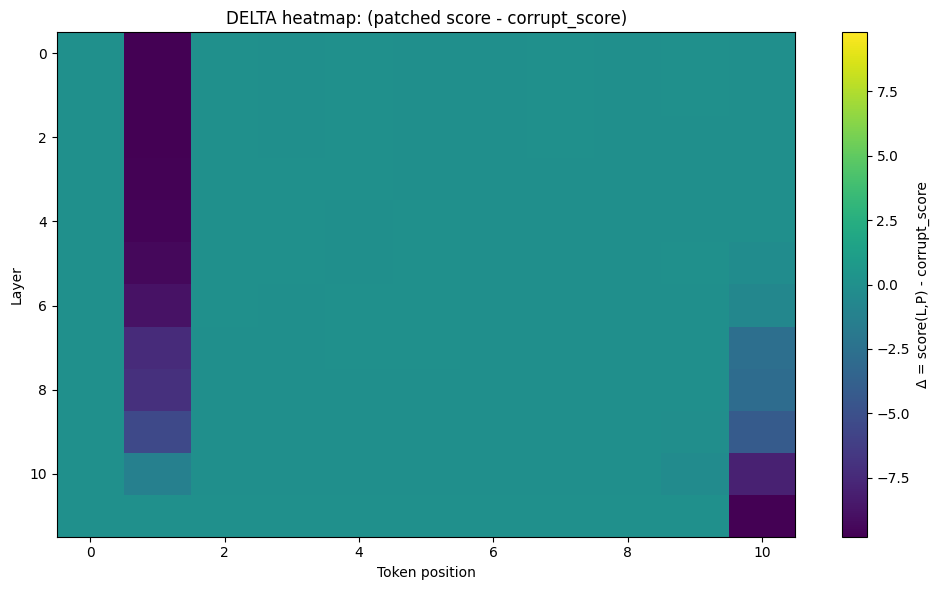

In [2]:
import os
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

from mingpt.model import GPT
from mingpt.bpe import BPETokenizer
from patching_sweep import logit_diff_from_last_logits, single_token_id

CLEAN_TEXT   = "Michelle Jones was a top-notch student. Michelle"
CORRUPT_TEXT = "Michelle Smith was a top-notch student. Michelle"
TOKEN_A = " Jones"
TOKEN_B = " Smith"

SAVED = "section9_diff_matrix.pt"


def get_device():
    return "cuda" if torch.cuda.is_available() else "cpu"


@torch.no_grad()
def compute_baselines(model, bpe, device):
    idx_clean = bpe(CLEAN_TEXT).to(device)
    idx_corr  = bpe(CORRUPT_TEXT).to(device)

    a_id = single_token_id(bpe, TOKEN_A)
    b_id = single_token_id(bpe, TOKEN_B)

    _ = model(idx_clean, cache_activations=True, overwrite_cache=True)
    clean_score = logit_diff_from_last_logits(
        model.last_logits[0], token_a_id=a_id, token_b_id=b_id
    )

    _ = model(idx_corr)
    corr_score = logit_diff_from_last_logits(
        model.last_logits[0], token_a_id=a_id, token_b_id=b_id
    )

    return clean_score, corr_score, a_id, b_id, idx_corr


@torch.no_grad()
def main():
    device = get_device()
    print("Device:", device)

    # Load matrix if available; otherwise we'll compute a small sample check only
    matrix = None
    saved_clean_score = float("nan")
    saved_corr_score = float("nan")

    if os.path.exists(SAVED):
        d = torch.load(SAVED, map_location="cpu")

        # Robust load: handle dict-with-matrix OR tensor-only saves
        if isinstance(d, dict) and "matrix" in d:
            matrix = d["matrix"].to(torch.float32)
            saved_clean_score = float(d.get("clean_score", float("nan")))
            saved_corr_score  = float(d.get("corrupt_score", float("nan")))
            print(f"Loaded {SAVED} (dict) with matrix shape {tuple(matrix.shape)}")
            if not (torch.isnan(torch.tensor(saved_clean_score)) or torch.isnan(torch.tensor(saved_corr_score))):
                print(f"Saved clean_score={saved_clean_score:.4f}, corrupt_score={saved_corr_score:.4f}")
            else:
                print("Saved baseline scores not found in file (clean_score/corrupt_score missing).")

        elif torch.is_tensor(d):
            matrix = d.to(torch.float32)
            print(f"Loaded {SAVED} (tensor) with shape {tuple(matrix.shape)}")
            print("Note: baseline scores not present because file contains only the tensor.")

        else:
            raise TypeError(f"Unexpected save format in {SAVED}: {type(d)}")

    # Load model/tokenizer
    model = GPT.from_pretrained("gpt2").to(device).eval()
    bpe = BPETokenizer()

    # Check 1: baselines
    clean_score, corr_score, a_id, b_id, idx_corr = compute_baselines(model, bpe, device)
    print("\n[Check 1] Baselines recomputed:")
    print(f"clean_score   = {clean_score:.4f}")
    print(f"corrupt_score = {corr_score:.4f}")
    print(f"delta (corrupt-clean) = {corr_score - clean_score:.4f}")

    if matrix is not None:
        # Check 5: sample a few cells and compare to direct recomputation
        n_layers, T = matrix.shape
        samples = [(0, 0), (0, 1), (6, 1), (6, T - 1), (n_layers - 1, 1)]
        print("\n[Check 5] Matrix cell == direct recomputation (sampled):")
        for (L, P) in samples:
            _ = model(idx_corr, layer_to_patch=int(L), position_to_patch=int(P))
            direct = logit_diff_from_last_logits(
                model.last_logits[0], token_a_id=a_id, token_b_id=b_id
            )
            stored = float(matrix[int(L), int(P)])
            print(f"(L={L}, P={P}) stored={stored:.6f} direct={direct:.6f} abs_diff={abs(stored-direct):.2e}")

        # Check 6: delta heatmap
        delta = matrix - float(corr_score)
        max_abs = float(delta.abs().max())
        print("\n[Check 6] Delta stats:")
        print(f"delta min={float(delta.min()):.4f}, max={float(delta.max()):.4f}, max_abs={max_abs:.4f}")

        norm = TwoSlopeNorm(vcenter=0.0, vmin=-max_abs, vmax=max_abs)
        plt.figure(figsize=(10, 6))
        plt.title("DELTA heatmap: (patched score - corrupt_score)")
        plt.imshow(delta.cpu().numpy(), norm=norm, aspect="auto")
        plt.colorbar(label="Δ = score(L,P) - corrupt_score")
        plt.xlabel("Token position")
        plt.ylabel("Layer")
        plt.tight_layout()
        plt.show()

    else:
        print("\nNo saved matrix found. If you want full verification, run section9_sweep_driver.py first to create it.")


if __name__ == "__main__":
    main()


In [14]:
!pytest -q

........................................................................ [ 82%]
...............                                                          [100%]
87 passed in 46.67s


In [1]:
%%writefile wrong_source_control.py
from __future__ import annotations

from dataclasses import dataclass
from typing import List, Optional, Tuple, Dict

import torch


@dataclass(frozen=True)
class Condition:
    name: str
    target: Tuple[int, int]          # (L_target, P_target)
    source: Optional[Tuple[int, int]] # None => no patch; else (L_source, P_source)


def single_token_id(bpe, token_str: str) -> int:
    ids = bpe(token_str)[0].tolist()
    if len(ids) != 1:
        raise ValueError(f"{repr(token_str)} is not a single BPE token. Got {len(ids)} ids: {ids}")
    return int(ids[0])


def score_from_last_logits(last_logits_1d: torch.Tensor, token_a_id: int, token_b_id: int) -> float:
    # score = logit(B) - logit(A)
    return float(last_logits_1d[token_b_id] - last_logits_1d[token_a_id])


def normalized_restoration(score_patched: float, score_clean: float, score_corr: float) -> float:
    denom = (score_clean - score_corr)
    if abs(denom) < 1e-12:
        return float("nan")
    return (score_patched - score_corr) / denom


def conditions_for_target(L: int, P: int, n_layers: int, seq_len: int) -> List[Condition]:
    """
    Returns the 5-condition set (baseline + match + wrong-source variants where valid)
    while keeping the patch TARGET fixed at (L,P).
    """
    conds: List[Condition] = []
    conds.append(Condition("no_patch", (L, P), None))
    conds.append(Condition("match", (L, P), (L, P)))

    # WS-pos +/- (same layer, neighbor token)
    if P + 1 < seq_len:
        conds.append(Condition("WS-pos+", (L, P), (L, P + 1)))
    if P - 1 >= 0:
        conds.append(Condition("WS-pos-", (L, P), (L, P - 1)))

    # WS-layer +/- (same position, neighbor layer)
    if L + 1 < n_layers:
        conds.append(Condition("WS-layer+", (L, P), (L + 1, P)))
    if L - 1 >= 0:
        conds.append(Condition("WS-layer-", (L, P), (L - 1, P)))

    return conds


@torch.no_grad()
def run_condition(
    model,
    idx_corr: torch.Tensor,
    cond: Condition,
    token_a_id: int,
    token_b_id: int,
) -> Dict[str, float]:
    """
    Runs ONE condition and returns score + bookkeeping.
    """
    if cond.source is None:
        _ = model(idx_corr)
        score = score_from_last_logits(model.last_logits[0], token_a_id, token_b_id)
        return {
            "score": score,
            "patched": 0.0,
            "L_target": float(cond.target[0]),
            "P_target": float(cond.target[1]),
            "L_source": float("nan"),
            "P_source": float("nan"),
        }

    (Lt, Pt) = cond.target
    (Ls, Ps) = cond.source
    _ = model(
        idx_corr,
        layer_to_patch=Lt,
        position_to_patch=Pt,
        source_layer=Ls,
        source_position=Ps,
    )
    score = score_from_last_logits(model.last_logits[0], token_a_id, token_b_id)
    return {
        "score": score,
        "patched": 1.0,
        "L_target": float(Lt),
        "P_target": float(Pt),
        "L_source": float(Ls),
        "P_source": float(Ps),
    }


Writing wrong_source_control.py


In [ ]:
%%writefile extra1_wrong_source_driver.py
from __future__ import annotations

from typing import List, Tuple

import torch

from mingpt.model import GPT
from mingpt.bpe import BPETokenizer
from mingpt.utils import set_seed

import wrong_source_control as wsc


CLEAN_TEXT = "Michelle Jones was a top-notch student. Michelle"
CORRUPT_TEXT = "Michelle Smith was a top-notch student. Michelle"
TOKEN_A_STR = " Jones"   # clean-consistent
TOKEN_B_STR = " Smith"   # corrupt-consistent
TOP_K_HOTSPOTS = 3


def get_device() -> str:
    return "cuda" if torch.cuda.is_available() else "cpu"


def tokens_same_length(bpe: BPETokenizer, a: str, b: str) -> bool:
    return bpe(a).shape[1] == bpe(b).shape[1]


@torch.no_grad()
def compute_score(model, idx, token_a_id: int, token_b_id: int) -> float:
    _ = model(idx)
    return wsc.score_from_last_logits(model.last_logits[0], token_a_id, token_b_id)


@torch.no_grad()
def compute_match_heatmap(
    model,
    idx_corr: torch.Tensor,
    token_a_id: int,
    token_b_id: int,
) -> torch.Tensor:
    n_layers = len(model.transformer.h)
    seq_len = idx_corr.shape[1]
    out = torch.empty((n_layers, seq_len), dtype=torch.float32)

    for L in range(n_layers):
        for P in range(seq_len):
            _ = model(idx_corr, layer_to_patch=L, position_to_patch=P)  # source defaults to match
            out[L, P] = wsc.score_from_last_logits(model.last_logits[0], token_a_id, token_b_id)
    return out


def select_hotspots_and_cold(
    match_heatmap: torch.Tensor,
    score_clean: float,
    score_corr: float,
    top_k: int = 3,
) -> Tuple[List[Tuple[int, int]], Tuple[int, int]]:
    """
    Hotspots: largest normalized restoration R
    Cold: smallest absolute change vs corrupted baseline
    """
    n_layers, seq_len = match_heatmap.shape
    R = torch.empty_like(match_heatmap)

    denom = (score_clean - score_corr)
    if abs(denom) < 1e-12:
        hot = [(0, 0)]
        cold = (0, 0)
        return hot, cold

    R = (match_heatmap - score_corr) / denom

    # flatten
    flat_R = R.flatten()
    top_vals, top_idx = torch.topk(flat_R, k=min(top_k, flat_R.numel()))
    hotspots = []
    used = set()
    for idx in top_idx.tolist():
        L = idx // seq_len
        P = idx % seq_len
        if (L, P) not in used:
            hotspots.append((L, P))
            used.add((L, P))
        if len(hotspots) >= top_k:
            break

    delta = (match_heatmap - score_corr).abs()
    delta_flat = delta.flatten()
    mask = torch.ones_like(delta_flat, dtype=torch.bool)
    for (L, P) in hotspots:
        mask[L * seq_len + P] = False
    masked_delta = delta_flat.clone()
    masked_delta[~mask] = float("inf")
    cold_idx = int(torch.argmin(masked_delta).item())
    cold = (cold_idx // seq_len, cold_idx % seq_len)

    return hotspots, cold


@torch.no_grad()
def main() -> None:
    set_seed(3407)
    device = get_device()
    print("Device:", device)

    # Load model + tokenizer
    model = GPT.from_pretrained("gpt2").to(device).eval()
    bpe = BPETokenizer()

    # Validate same token length
    if not tokens_same_length(bpe, CLEAN_TEXT, CORRUPT_TEXT):
        raise RuntimeError(
            "CLEAN_TEXT and CORRUPT_TEXT do NOT have the same number of BPE tokens.\n"
            "Fix the texts until they tokenize to the same length."
        )

    # Tokenize prompts
    idx_clean = bpe(CLEAN_TEXT).to(device)     # (1, T)
    idx_corr = bpe(CORRUPT_TEXT).to(device)    # (1, T)
    seq_len = idx_corr.shape[1]
    n_layers = len(model.transformer.h)

    # Token ids for metric
    token_a_id = wsc.single_token_id(bpe, TOKEN_A_STR)
    token_b_id = wsc.single_token_id(bpe, TOKEN_B_STR)

    # Clean baseline (cache activations)
    _ = model(idx_clean, cache_activations=True, overwrite_cache=True)
    score_clean = wsc.score_from_last_logits(model.last_logits[0], token_a_id, token_b_id)

    # Corrupted baseline
    _ = model(idx_corr)
    score_corr = wsc.score_from_last_logits(model.last_logits[0], token_a_id, token_b_id)

    print("\n=== Baselines ===")
    print(f"seq_len={seq_len}, n_layers={n_layers}")
    print(f"score_clean = {score_clean:.6f}")
    print(f"score_corr  = {score_corr:.6f}")

    # Compute MATCH heatmap (standard patch)
    print("\nComputing match heatmap (this is the same sweep as your main analysis)...")
    match_heatmap = compute_match_heatmap(model, idx_corr, token_a_id, token_b_id)
    torch.save(match_heatmap.cpu(), "match_heatmap.pt")
    print("Saved: match_heatmap.pt")

    # Pick top hotspots + one cold cell
    hotspots, cold = select_hotspots_and_cold(match_heatmap, score_clean, score_corr, top_k=TOP_K_HOTSPOTS)
    targets = hotspots + [cold]

    print("\n=== Selected targets ===")
    for i, (L, P) in enumerate(targets):
        s = float(match_heatmap[L, P])
        R = wsc.normalized_restoration(s, score_clean, score_corr)
        tag = "COLD" if (L, P) == cold else "HOT"
        print(f"{i+1:02d}. ({L},{P})  match_score={s:.6f}  R_match={R:.4f}  [{tag}]")

    # Run wrong-source conditions per target
    print("\n=== WRONG-SOURCE CONTROL RESULTS ===")
    print("(Metric: score = logit(B) - logit(A); higher/lower direction depends on your pair)\n")

    for (L, P) in targets:
        conds = wsc.conditions_for_target(L, P, n_layers=n_layers, seq_len=seq_len)

        print(f"\n--- Target (L={L}, P={P}) ---")
        print(f"{'condition':12s} | {'source':10s} | {'score':>12s} | {'R':>8s}")
        print("-" * 52)

        for c in conds:
            row = wsc.run_condition(model, idx_corr, c, token_a_id, token_b_id)
            score = row["score"]
            R = wsc.normalized_restoration(score, score_clean, score_corr)

            if c.source is None:
                src = "-"
            else:
                src = f"({c.source[0]},{c.source[1]})"

            print(f"{c.name:12s} | {src:10s} | {score:12.6f} | {R:8.4f}")

    # OPTIONAL: build one full wrong-source heatmap using deterministic rule (pos+1 else pos-1)
    print("\nOptional: computing a full wrong-source heatmap with rule: source=(L,P+1) else (L,P-1)")
    ws_heatmap = torch.empty_like(match_heatmap)
    for L in range(n_layers):
        for P in range(seq_len):
            srcP = P + 1 if (P + 1 < seq_len) else (P - 1)
            _ = model(idx_corr, layer_to_patch=L, position_to_patch=P, source_layer=L, source_position=srcP)
            ws_heatmap[L, P] = wsc.score_from_last_logits(model.last_logits[0], token_a_id, token_b_id)

    torch.save(ws_heatmap.cpu(), "wrong_source_posshift_heatmap.pt")
    print("Saved: wrong_source_posshift_heatmap.pt")
    print("\nDone ✅")


if __name__ == "__main__":
    main()


Writing extra1_wrong_source_driver.py


In [3]:
%%writefile test_extra1_wrong_source_control.py
import pytest
import torch

from mingpt.model import GPT

import wrong_source_control as wsc


def _make_tiny():
    cfg = GPT.get_default_config()
    cfg.model_type = "gpt-nano"
    cfg.vocab_size = 200
    cfg.block_size = 32
    model = GPT(cfg).eval()
    return model, cfg


def _make_clean_corrupt(cfg, T=12):
    torch.manual_seed(0)
    clean = torch.randint(0, cfg.vocab_size, (1, T), dtype=torch.long)
    corrupt = clean.clone()
    corrupt[0, 3] = (corrupt[0, 3] + 1) % cfg.vocab_size
    return clean, corrupt


def test_forward_accepts_wrong_source_parameters_and_records_source_bookkeeping():
    model, cfg = _make_tiny()
    clean, corrupt = _make_clean_corrupt(cfg, T=12)

    # cache clean
    with torch.no_grad():
        _ = model(clean, cache_activations=True, overwrite_cache=True)

    L_target, P_target = 0, 3
    L_source, P_source = 0, 4

    with torch.no_grad():
        _ = model(
            corrupt,
            record_activations=True,
            layer_to_patch=L_target,
            position_to_patch=P_target,
            source_layer=L_source,
            source_position=P_source,
        )

    assert model.last_patch == (L_target, P_target)
    assert hasattr(model, "last_patch_source")
    assert model.last_patch_source == (L_source, P_source)

    # patched activation at (L_target, P_target) must equal clean cache at (L_source, P_source)
    patched_acts = model.last_activations
    assert patched_acts is not None
    assert torch.allclose(
        patched_acts[L_target][P_target],
        model.clean_activations[L_source][P_source],
        rtol=1e-5,
        atol=1e-6,
    )


def test_standard_patch_is_default_when_source_not_provided():
    model, cfg = _make_tiny()
    clean, corrupt = _make_clean_corrupt(cfg, T=10)

    with torch.no_grad():
        _ = model(clean, cache_activations=True, overwrite_cache=True)

    L, P = 1, 2
    with torch.no_grad():
        _ = model(corrupt, record_activations=True, layer_to_patch=L, position_to_patch=P)

    assert model.last_patch == (L, P)
    assert model.last_patch_source == (L, P)  # default source == target

    patched_acts = model.last_activations
    assert torch.allclose(
        patched_acts[L][P],
        model.clean_activations[L][P],
        rtol=1e-5,
        atol=1e-6,
    )


def test_wrong_source_pairing_rules_enforced():
    model, cfg = _make_tiny()
    clean, corrupt = _make_clean_corrupt(cfg, T=10)

    with torch.no_grad():
        _ = model(clean, cache_activations=True, overwrite_cache=True)

    with pytest.raises(ValueError):
        with torch.no_grad():
            _ = model(corrupt, layer_to_patch=0, position_to_patch=3, source_layer=0, source_position=None)

    with pytest.raises(ValueError):
        with torch.no_grad():
            _ = model(corrupt, layer_to_patch=0, position_to_patch=3, source_layer=None, source_position=4)


def test_wrong_source_bounds_checked():
    model, cfg = _make_tiny()
    clean, corrupt = _make_clean_corrupt(cfg, T=8)

    with torch.no_grad():
        _ = model(clean, cache_activations=True, overwrite_cache=True)

    # source_position out of range
    with pytest.raises(IndexError):
        with torch.no_grad():
            _ = model(corrupt, layer_to_patch=0, position_to_patch=3, source_layer=0, source_position=999)

    # source_layer out of range
    with pytest.raises(IndexError):
        with torch.no_grad():
            _ = model(corrupt, layer_to_patch=0, position_to_patch=3, source_layer=999, source_position=3)


def test_conditions_for_target_respects_boundaries():
    n_layers = 12
    seq_len = 10

    # P=0 => no WS-pos-
    conds = wsc.conditions_for_target(L=5, P=0, n_layers=n_layers, seq_len=seq_len)
    names = {c.name for c in conds}
    assert "WS-pos-" not in names
    assert "WS-pos+" in names

    # P=seq_len-1 => no WS-pos+
    conds = wsc.conditions_for_target(L=5, P=seq_len - 1, n_layers=n_layers, seq_len=seq_len)
    names = {c.name for c in conds}
    assert "WS-pos+" not in names
    assert "WS-pos-" in names

    # L=0 => no WS-layer-
    conds = wsc.conditions_for_target(L=0, P=3, n_layers=n_layers, seq_len=seq_len)
    names = {c.name for c in conds}
    assert "WS-layer-" not in names
    assert "WS-layer+" in names

    # L=n_layers-1 => no WS-layer+
    conds = wsc.conditions_for_target(L=n_layers - 1, P=3, n_layers=n_layers, seq_len=seq_len)
    names = {c.name for c in conds}
    assert "WS-layer+" not in names
    assert "WS-layer-" in names


Writing test_extra1_wrong_source_control.py


In [5]:
!pytest -q test_extra1_wrong_source_control.py

.....                                                                    [100%]
5 passed in 3.21s


In [ ]:
%%writefile wrong_source_control_driver.py
from __future__ import annotations

import argparse
from dataclasses import dataclass
from typing import List, Optional, Tuple

import torch

from mingpt.bpe import BPETokenizer
from mingpt.model import GPT
from mingpt.utils import set_seed


@dataclass(frozen=True)
class PatchResult:
    target: Tuple[int, int]
    variant: str
    source: Tuple[int, int]
    score: float
    R: float           # normalized restoration (can be > 1 if overshoot)
    C: float           # normalized closeness-to-clean (1 is best)
    last_patch: Optional[Tuple[int, int]]
    last_patch_source: Optional[Tuple[int, int]]


def get_device() -> str:
    return "cuda" if torch.cuda.is_available() else "cpu"


def single_token_id(bpe: BPETokenizer, token_str: str) -> int:
    ids = bpe(token_str)[0].tolist()
    if len(ids) != 1:
        raise ValueError(
            f"Token string must map to exactly 1 BPE token. "
            f"Got {len(ids)} tokens for {repr(token_str)}: {ids}"
        )
    return int(ids[0])


def logit_diff_from_last_logits(last_logits_1d: torch.Tensor, token_b_id: int, token_a_id: int) -> float:
    # score = logit(B) - logit(A)
    return float(last_logits_1d[token_b_id] - last_logits_1d[token_a_id])


def norm_restoration(score: float, score_clean: float, score_corr: float) -> float:
    # R = (score - score_corr) / (score_clean - score_corr)
    denom = (score_clean - score_corr)
    if abs(denom) < 1e-12:
        return 0.0
    return (score - score_corr) / denom


def norm_closeness(score: float, score_clean: float, score_corr: float) -> float:
    # C = 1 - |score - score_clean| / |score_corr - score_clean|
    denom = abs(score_corr - score_clean)
    if denom < 1e-12:
        return 1.0
    return 1.0 - (abs(score - score_clean) / denom)


@torch.no_grad()
def run_score(
    model: GPT,
    idx: torch.Tensor,
    token_a_id: int,
    token_b_id: int,
    *,
    layer_to_patch: Optional[int] = None,
    position_to_patch: Optional[int] = None,
    source_layer: Optional[int] = None,
    source_position: Optional[int] = None,
) -> float:
    _logits, _loss = model(
        idx,
        record_activations=False,
        cache_activations=False,
        overwrite_cache=False,
        layer_to_patch=layer_to_patch,
        position_to_patch=position_to_patch,
        source_layer=source_layer,
        source_position=source_position,
    )
    if model.last_logits is None:
        raise RuntimeError("model.last_logits is None after forward().")
    return logit_diff_from_last_logits(model.last_logits[0], token_b_id=token_b_id, token_a_id=token_a_id)


def build_wrong_source_variants(L: int, P: int, n_layer: int, T: int) -> List[Tuple[str, int, int]]:
    variants: List[Tuple[str, int, int]] = []
    variants.append(("MATCH", L, P))

    # Position mismatch (same layer)
    if P + 1 < T:
        variants.append(("WS-pos+", L, P + 1))
    if P - 1 >= 0:
        variants.append(("WS-pos-", L, P - 1))

    # Layer mismatch (same position)
    if L + 1 < n_layer:
        variants.append(("WS-layer+", L + 1, P))
    if L - 1 >= 0:
        variants.append(("WS-layer-", L - 1, P))

    return variants


def select_hotspots(match_scores: torch.Tensor, score_clean: float, k: int = 3) -> List[Tuple[int, int]]:
    # Pick coords whose MATCH patched score is closest to clean (min |score - score_clean|)
    n_layer, T = match_scores.shape
    flat: List[Tuple[float, int, int]] = []
    for L in range(n_layer):
        for P in range(T):
            d = abs(float(match_scores[L, P]) - score_clean)
            flat.append((d, L, P))
    flat.sort(key=lambda x: x[0])
    out: List[Tuple[int, int]] = []
    for _, L, P in flat:
        out.append((L, P))
        if len(out) >= k:
            break
    return out


def select_coldcell(
    match_scores: torch.Tensor,
    score_corr: float,
    *,
    changed_pos: int,
) -> Tuple[int, int]:
    # Pick coord with minimal |score - score_corr| but avoid positions before/at the changed token
    n_layer, T = match_scores.shape
    pos_min = min(T - 1, changed_pos + 1)

    candidates: List[Tuple[float, int, int]] = []
    for L in range(n_layer):
        for P in range(pos_min, T):
            d = abs(float(match_scores[L, P]) - score_corr)
            candidates.append((d, L, P))

    # Fallback if pos_min kills all candidates
    if not candidates:
        for L in range(n_layer):
            for P in range(T):
                d = abs(float(match_scores[L, P]) - score_corr)
                candidates.append((d, L, P))

    candidates.sort(key=lambda x: x[0])
    _, L, P = candidates[0]
    return (L, P)


def parse_args() -> argparse.Namespace:
    p = argparse.ArgumentParser()
    p.add_argument("--clean", type=str, default="Michelle Jones was a top-notch student. Michelle")
    p.add_argument("--corrupt", type=str, default="Michelle Smith was a top-notch student. Michelle")
    p.add_argument("--token_a", type=str, default=" Jones", help="Token A (clean-consistent), usually with leading space")
    p.add_argument("--token_b", type=str, default=" Smith", help="Token B (corrupt-consistent), usually with leading space")
    p.add_argument("--seed", type=int, default=3407)
    p.add_argument("--n_hot", type=int, default=3)
    return p.parse_args()


@torch.no_grad()
def main() -> None:
    args = parse_args()
    set_seed(args.seed)

    device = get_device()
    print("Device:", device)

    bpe = BPETokenizer()
    token_a_id = single_token_id(bpe, args.token_a)
    token_b_id = single_token_id(bpe, args.token_b)

    idx_clean = bpe(args.clean).to(device)
    idx_corr = bpe(args.corrupt).to(device)

    if idx_clean.shape != idx_corr.shape:
        raise ValueError(
            f"Clean/corrupt token length mismatch: clean T={idx_clean.shape[1]} vs corrupt T={idx_corr.shape[1]}"
        )

    # Find changed token position (expect exactly one token differs)
    clean_ids = idx_clean[0].tolist()
    corr_ids = idx_corr[0].tolist()
    diffs = [i for i, (a, b) in enumerate(zip(clean_ids, corr_ids)) if int(a) != int(b)]
    if len(diffs) != 1:
        raise ValueError(f"Expected exactly 1 differing token position, found {len(diffs)}: {diffs}")
    changed_pos = int(diffs[0])
    T = int(idx_clean.shape[1])

    model = GPT.from_pretrained("gpt2").to(device).eval()
    n_layer = int(len(model.transformer.h))

    print(f"Seq len T={T}, changed token position={changed_pos}")

    _ = model(idx_clean, cache_activations=True, overwrite_cache=True)
    if model.last_logits is None:
        raise RuntimeError("model.last_logits not set on clean run.")
    score_clean = logit_diff_from_last_logits(model.last_logits[0], token_b_id=token_b_id, token_a_id=token_a_id)

    score_corr = run_score(model, idx_corr, token_a_id=token_a_id, token_b_id=token_b_id)

    print("\n=== Baselines ===")
    print(f"score_clean  = {score_clean:.4f}")
    print(f"score_corr   = {score_corr:.4f}")
    print(f"gap (clean-corr) = {(score_clean - score_corr):.4f}")

    match_scores = torch.empty((n_layer, T), dtype=torch.float32)
    for L in range(n_layer):
        for P in range(T):
            s = run_score(
                model,
                idx_corr,
                token_a_id=token_a_id,
                token_b_id=token_b_id,
                layer_to_patch=L,
                position_to_patch=P,
                source_layer=L,
                source_position=P,
            )
            match_scores[L, P] = float(s)

    hot = select_hotspots(match_scores, score_clean=score_clean, k=args.n_hot)
    cold = select_coldcell(match_scores, score_corr=score_corr, changed_pos=changed_pos)

    print("\nSelected coords:")
    for (L, P) in hot:
        s = float(match_scores[L, P])
        improvement = (score_corr - s)
        print(f"  HOT: (L={L}, P={P})  match_score={s:.4f}  improvement={improvement:.4f}")
    s_cold = float(match_scores[cold[0], cold[1]])
    print(f"  COLD: (L={cold[0]}, P={cold[1]})  match_score={s_cold:.4f}  improvement={(score_corr - s_cold):.4f}")

    print("\n=== Wrong-source control table ===")
    print("coord | variant | source(L,P) | score | R (restoration) | C (closeness) | last_patch | last_patch_source")
    print("-" * 110)

    selected = hot + [cold]

    for (L, P) in selected:
        variants = build_wrong_source_variants(L, P, n_layer=n_layer, T=T)
        results: List[PatchResult] = []

        for (name, sL, sP) in variants:
            s = run_score(
                model,
                idx_corr,
                token_a_id=token_a_id,
                token_b_id=token_b_id,
                layer_to_patch=L,
                position_to_patch=P,
                source_layer=sL,
                source_position=sP,
            )
            R = norm_restoration(s, score_clean=score_clean, score_corr=score_corr)
            C = norm_closeness(s, score_clean=score_clean, score_corr=score_corr)

            results.append(
                PatchResult(
                    target=(L, P),
                    variant=name,
                    source=(sL, sP),
                    score=float(s),
                    R=float(R),
                    C=float(C),
                    last_patch=model.last_patch,
                    last_patch_source=model.last_patch_source,
                )
            )

        # Print rows
        for r in results:
            print(
                f"({r.target[0]:02d},{r.target[1]:02d}) | "
                f"{r.variant:<9} | "
                f"({r.source[0]:02d},{r.source[1]:02d})     | "
                f"{r.score:>7.4f} | "
                f"{r.R:>7.3f}        | "
                f"{r.C:>7.3f}        | "
                f"{r.last_patch} | {r.last_patch_source}"
            )

        # Specificity index (FIX): use closeness-to-clean, not restoration fraction
        c_match = max([rr.C for rr in results if rr.variant == "MATCH"], default=0.0)
        c_wrong = [rr.C for rr in results if rr.variant != "MATCH"]
        if c_wrong:
            S = c_match - max(c_wrong)
        else:
            S = 0.0

        print(f"-> Specificity index S = C_match - max(C_wrong) = {S:.3f}\n")


if __name__ == "__main__":
    main()


Overwriting wrong_source_control_driver.py


In [11]:
!python wrong_source_control_driver.py


Device: cuda
number of parameters: 124.44M
Seq len T=11, changed token position=1

=== Baselines ===
score_clean  = -4.1241
score_corr   = 5.6562
gap (clean-corr) = -9.7803

Selected coords:
  HOT: (L=11, P=10)  match_score=-4.1241  improvement=9.7803
  HOT: (L=0, P=1)  match_score=-4.0691  improvement=9.7254
  HOT: (L=1, P=1)  match_score=-4.0673  improvement=9.7235
  COLD: (L=11, P=2)  match_score=5.6562  improvement=0.0000

=== Wrong-source control table ===
coord | variant | source(L,P) | score | R (restoration) | C (closeness) | last_patch | last_patch_source
--------------------------------------------------------------------------------------------------------------
(11,10) | MATCH     | (11,10)     | -4.1241 |   1.000        |   1.000        | (11, 10) | (11, 10)
(11,10) | WS-pos-   | (11,09)     | -2.8865 |   0.873        |   0.873        | (11, 10) | (11, 9)
(11,10) | WS-layer- | (10,10)     | -5.6192 |   1.153        |   0.847        | (11, 10) | (10, 10)
-> Specificity inde

In [8]:
!pytest -q

........................................................................ [ 78%]
....................                                                     [100%]
92 passed in 42.19s


Device: cuda
=== Pair summary ===
Clean tokens:   11
Corrupt tokens: 11
Same length?    True
Diff count:     1
Diff positions: [1]
One-token diff? True

number of parameters: 124.44M
Seq len T=11, n_layers=12

Baselines:
score_clean = -4.124077
score_corr  = 5.656242
gap(clean-corr) = -9.780319


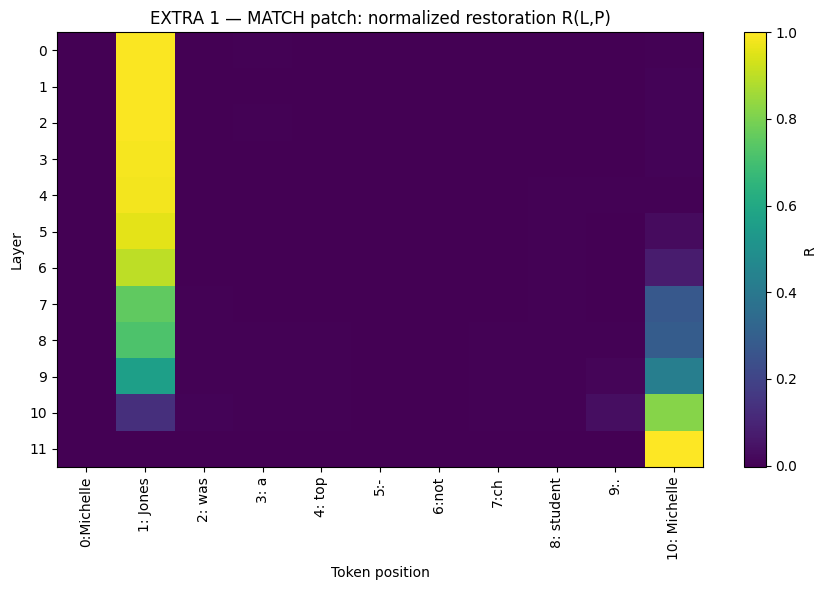

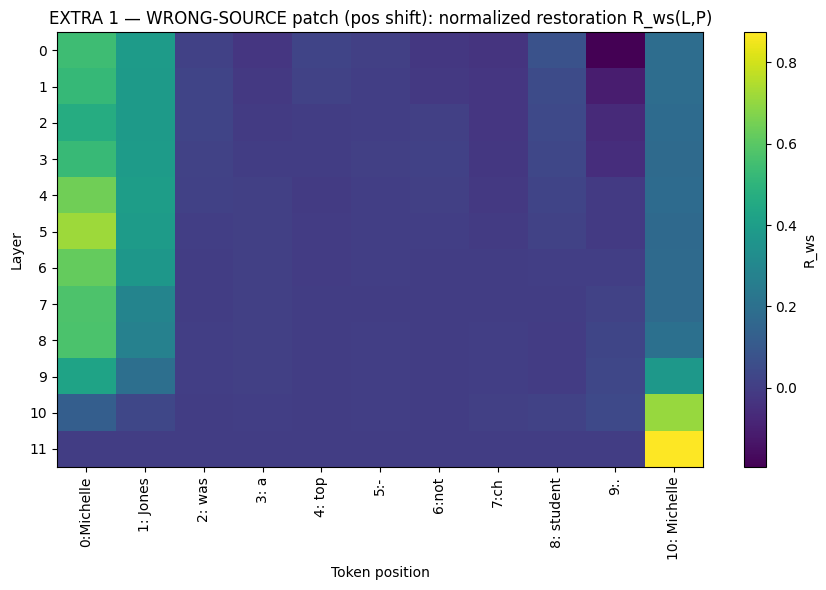

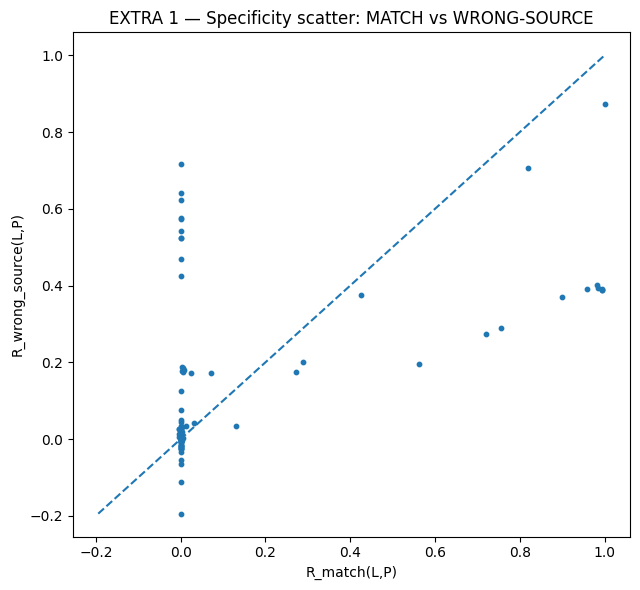

Done ✅  (Estas 3 figuras son las típicas para justificar 'especificidad'.)


In [ ]:
import math
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

from mingpt.model import GPT
from mingpt.bpe import BPETokenizer

try:
    import tokenization_protocol as tp
except Exception:
    tp = None


CLEAN_TEXT   = "Michelle Jones was a top-notch student. Michelle"
CORRUPT_TEXT = "Michelle Smith was a top-notch student. Michelle"
TOKEN_A_STR  = " Jones"   # clean-consistent
TOKEN_B_STR  = " Smith"   # corrupt-consistent

# Wrong-source rule: source position is P+1 if possible else P-1 (same layer)
def wrong_source_pos(P: int, T: int) -> int:
    return (P + 1) if (P + 1 < T) else (P - 1)

def get_device() -> str:
    return "cuda" if torch.cuda.is_available() else "cpu"

def single_token_id(bpe: BPETokenizer, token_str: str) -> int:
    ids = bpe(token_str)[0].tolist()
    if len(ids) != 1:
        raise ValueError(f"{repr(token_str)} is not a single BPE token. Got {len(ids)} ids: {ids}")
    return int(ids[0])

def score_from_last_logits(last_logits_1d: torch.Tensor, token_a_id: int, token_b_id: int) -> float:
    # score = logit(B) - logit(A)
    return float(last_logits_1d[token_b_id] - last_logits_1d[token_a_id])

def restoration(score: float, score_clean: float, score_corr: float) -> float:
    denom = (score_clean - score_corr)
    if abs(denom) < 1e-12:
        return float("nan")
    return (score - score_corr) / denom

def decode_prompt_token_labels(bpe: BPETokenizer, text: str):
    ids_1d = bpe(text)[0].tolist()
    labels = []
    for tid in ids_1d:
        labels.append(bpe.decode(torch.tensor([int(tid)], dtype=torch.long)))
    return labels

device = get_device()
print("Device:", device)

bpe = BPETokenizer()
token_a_id = single_token_id(bpe, TOKEN_A_STR)
token_b_id = single_token_id(bpe, TOKEN_B_STR)

if tp is not None:
    comp = tp.validate_pair(bpe=bpe, clean_text=CLEAN_TEXT, corrupt_text=CORRUPT_TEXT,
                            require_same_length=True, require_one_token_diff=False)
    print(tp.describe_pair(comp))

idx_clean = bpe(CLEAN_TEXT).to(device)
idx_corr  = bpe(CORRUPT_TEXT).to(device)

if idx_clean.shape != idx_corr.shape:
    raise ValueError(f"Clean/corrupt length mismatch: clean {tuple(idx_clean.shape)} vs corrupt {tuple(idx_corr.shape)}")

T = int(idx_clean.shape[1])

model = GPT.from_pretrained("gpt2").to(device).eval()
n_layer = len(model.transformer.h)
print(f"Seq len T={T}, n_layers={n_layer}")

with torch.no_grad():
    # CLEAN run: cache activations
    _ = model(idx_clean, cache_activations=True, overwrite_cache=True)
    score_clean = score_from_last_logits(model.last_logits[0], token_a_id, token_b_id)

    # CORR baseline
    _ = model(idx_corr)
    score_corr = score_from_last_logits(model.last_logits[0], token_a_id, token_b_id)

print("\nBaselines:")
print(f"score_clean = {score_clean:.6f}")
print(f"score_corr  = {score_corr:.6f}")
print(f"gap(clean-corr) = {score_clean-score_corr:.6f}")

# Compute MATCH and WRONG-SOURCE matrices of SCORES
match_scores = torch.empty((n_layer, T), dtype=torch.float32)
ws_scores    = torch.empty((n_layer, T), dtype=torch.float32)

with torch.no_grad():
    for L in range(n_layer):
        for P in range(T):
            # MATCH
            _ = model(idx_corr, layer_to_patch=L, position_to_patch=P, source_layer=L, source_position=P)
            match_scores[L, P] = float(score_from_last_logits(model.last_logits[0], token_a_id, token_b_id))

            # WRONG-SOURCE (pos shift)
            srcP = wrong_source_pos(P, T)
            _ = model(idx_corr, layer_to_patch=L, position_to_patch=P, source_layer=L, source_position=srcP)
            ws_scores[L, P] = float(score_from_last_logits(model.last_logits[0], token_a_id, token_b_id))

# Convert to normalized restoration R
R_match = torch.empty_like(match_scores)
R_ws    = torch.empty_like(ws_scores)
for L in range(n_layer):
    for P in range(T):
        R_match[L, P] = restoration(float(match_scores[L, P]), score_clean, score_corr)
        R_ws[L, P]    = restoration(float(ws_scores[L, P]), score_clean, score_corr)

# Plots
token_labels = decode_prompt_token_labels(bpe, CLEAN_TEXT)
xticks = list(range(T))

# (A) Heatmap: R_match
plt.figure(figsize=(max(8, 0.35*T + 5), 6))
plt.title("EXTRA 1 — MATCH patch: normalized restoration R(L,P)")
plt.imshow(R_match.cpu().numpy(), aspect="auto")
plt.colorbar(label="R")
plt.xlabel("Token position")
plt.ylabel("Layer")
plt.xticks(xticks, [f"{i}:{token_labels[i]}" for i in xticks], rotation=90)
plt.yticks(list(range(n_layer)))
plt.tight_layout()
plt.show()

# (B) Heatmap: R_wrong_source
plt.figure(figsize=(max(8, 0.35*T + 5), 6))
plt.title("EXTRA 1 — WRONG-SOURCE patch (pos shift): normalized restoration R_ws(L,P)")
plt.imshow(R_ws.cpu().numpy(), aspect="auto")
plt.colorbar(label="R_ws")
plt.xlabel("Token position")
plt.ylabel("Layer")
plt.xticks(xticks, [f"{i}:{token_labels[i]}" for i in xticks], rotation=90)
plt.yticks(list(range(n_layer)))
plt.tight_layout()
plt.show()

# (C) Scatter: R_match vs R_wrong_source
x = R_match.flatten().cpu().numpy()
y = R_ws.flatten().cpu().numpy()

plt.figure(figsize=(6.5, 6))
plt.title("EXTRA 1 — Specificity scatter: MATCH vs WRONG-SOURCE")
plt.scatter(x, y, s=10)
# Diagonal y=x
lo = float(min(x.min(), y.min()))
hi = float(max(x.max(), y.max()))
plt.plot([lo, hi], [lo, hi], linestyle="--")
plt.xlabel("R_match(L,P)")
plt.ylabel("R_wrong_source(L,P)")
plt.tight_layout()
plt.show()

print("Done")


## EXTRA SECTION 2: Add an interpolation sweep

In [1]:
%%writefile interpolation_sweep.py
from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, List, Optional, Sequence, Tuple

import math
import torch
from torch.nn import functional as F


Coord = Tuple[int, int]  # (layer, position)


@dataclass(frozen=True)
class Baselines:
    clean_score: float
    corrupt_score: float
    token_a_id: int
    token_b_id: int
    seq_len: int
    n_layer: int


@dataclass(frozen=True)
class Curve:
    coord: Coord
    alphas: List[float]
    scores: List[float]
    restorations: List[float]
    alpha50: Optional[float]


def single_token_id(bpe, token_str: str) -> int:
    ids = bpe(token_str)[0].tolist()
    if len(ids) != 1:
        raise ValueError(f"{repr(token_str)} is not a single BPE token. Got {len(ids)} ids: {ids}")
    return int(ids[0])


def score_from_last_logits(last_logits_1d: torch.Tensor, token_a_id: int, token_b_id: int) -> float:
    # score = logit(B) - logit(A)
    return float(last_logits_1d[token_b_id] - last_logits_1d[token_a_id])


def restoration_fraction(score: float, score_corr: float, score_clean: float) -> float:
    denom = (score_clean - score_corr)
    if abs(denom) < 1e-12:
        return float("nan")
    return (score - score_corr) / denom


def estimate_alpha50(alphas: Sequence[float], restorations: Sequence[float]) -> Optional[float]:
    """
    Returns the smallest alpha where R(alpha) >= 0.5 using linear interpolation.
    If never reaches 0.5 (or NaNs), returns None.
    """
    xs = list(alphas)
    ys = list(restorations)

    # Filter NaNs but keep order
    pairs = [(x, y) for x, y in zip(xs, ys) if (y is not None and not math.isnan(y))]
    if len(pairs) < 2:
        return None

    for i in range(1, len(pairs)):
        x0, y0 = pairs[i - 1]
        x1, y1 = pairs[i]
        if y0 >= 0.5:
            return x0
        if (y0 < 0.5) and (y1 >= 0.5) and (x1 != x0):
            t = (0.5 - y0) / (y1 - y0)
            return x0 + t * (x1 - x0)

    return None


@torch.no_grad()
def compute_baselines(
    model,
    bpe,
    clean_text: str,
    corrupt_text: str,
    token_a_str: str,
    token_b_str: str,
    *,
    device: Optional[str] = None,
    overwrite_cache: bool = True,
) -> Baselines:
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    idx_clean = bpe(clean_text).to(device)
    idx_corr = bpe(corrupt_text).to(device)

    if idx_clean.shape[1] != idx_corr.shape[1]:
        raise ValueError(
            f"Token length mismatch: clean T={idx_clean.shape[1]} vs corrupt T={idx_corr.shape[1]}. "
            "They must match for activation patching."
        )

    token_a_id = single_token_id(bpe, token_a_str)
    token_b_id = single_token_id(bpe, token_b_str)

    # Clean run: cache activations
    _ = model(idx_clean, cache_activations=True, overwrite_cache=overwrite_cache)
    if model.last_logits is None:
        raise RuntimeError("model.last_logits missing after clean run.")
    clean_score = score_from_last_logits(model.last_logits[0], token_a_id, token_b_id)

    # Corrupt baseline
    _ = model(idx_corr)
    if model.last_logits is None:
        raise RuntimeError("model.last_logits missing after corrupt run.")
    corrupt_score = score_from_last_logits(model.last_logits[0], token_a_id, token_b_id)

    n_layer = len(model.transformer.h)
    seq_len = int(idx_clean.shape[1])

    return Baselines(
        clean_score=clean_score,
        corrupt_score=corrupt_score,
        token_a_id=token_a_id,
        token_b_id=token_b_id,
        seq_len=seq_len,
        n_layer=n_layer,
    )


@torch.no_grad()
def full_patch_matrix(
    model,
    bpe,
    corrupt_text: str,
    baselines: Baselines,
    *,
    device: Optional[str] = None,
) -> torch.Tensor:
    """
    Computes the standard heatmap scores for alpha=1 patching:
      M[L, P] = score after patching (L,P) with clean (L,P).
    Shape: (n_layer, seq_len)
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    idx_corr = bpe(corrupt_text).to(device)

    M = torch.empty((baselines.n_layer, baselines.seq_len), dtype=torch.float32)
    for L in range(baselines.n_layer):
        for P in range(baselines.seq_len):
            _ = model(
                idx_corr,
                layer_to_patch=L,
                position_to_patch=P,
                patch_alpha=1.0,
            )
            score = score_from_last_logits(model.last_logits[0], baselines.token_a_id, baselines.token_b_id)
            M[L, P] = score
    return M


def select_hotspots(
    M: torch.Tensor,
    baselines: Baselines,
    *,
    top_k: int = 3,
) -> Tuple[List[Coord], Coord]:
    """
    Picks:
      - hotspots: top_k cells with highest restoration at alpha=1
      - coldspot: cell with minimal |score - corrupt_score| (near-zero effect)
    """
    n_layer, T = M.shape
    R = torch.empty_like(M)
    for L in range(n_layer):
        for P in range(T):
            R[L, P] = float(
                restoration_fraction(float(M[L, P]), baselines.corrupt_score, baselines.clean_score)
            )

    # Flatten + sort by restoration descending (best restoration first)
    flat = []
    for L in range(n_layer):
        for P in range(T):
            r = float(R[L, P])
            if not math.isnan(r):
                flat.append(((L, P), r))

    flat.sort(key=lambda x: x[1], reverse=True)
    hotspots = [coord for coord, _ in flat[:top_k]]

    # Coldspot: closest to corrupt baseline (small absolute effect)
    best_cold = (0, 0)
    best_dist = float("inf")
    for L in range(n_layer):
        for P in range(T):
            dist = abs(float(M[L, P]) - baselines.corrupt_score)
            if dist < best_dist:
                best_dist = dist
                best_cold = (L, P)

    return hotspots, best_cold


@torch.no_grad()
def interpolation_curve(
    model,
    bpe,
    corrupt_text: str,
    baselines: Baselines,
    coord: Coord,
    alphas: Sequence[float],
    *,
    device: Optional[str] = None,
    source_coord: Optional[Coord] = None,  # optional wrong-source + interpolation together
) -> Curve:
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    idx_corr = bpe(corrupt_text).to(device)

    L, P = coord
    if source_coord is None:
        srcL, srcP = L, P
    else:
        srcL, srcP = source_coord

    scores: List[float] = []
    restorations: List[float] = []
    alphas_out: List[float] = []

    for a in alphas:
        a = float(a)
        _ = model(
            idx_corr,
            layer_to_patch=L,
            position_to_patch=P,
            source_layer=srcL,
            source_position=srcP,
            patch_alpha=a,
        )
        sc = score_from_last_logits(model.last_logits[0], baselines.token_a_id, baselines.token_b_id)
        r = restoration_fraction(sc, baselines.corrupt_score, baselines.clean_score)

        alphas_out.append(a)
        scores.append(sc)
        restorations.append(r)

    a50 = estimate_alpha50(alphas_out, restorations)

    return Curve(
        coord=coord,
        alphas=alphas_out,
        scores=scores,
        restorations=restorations,
        alpha50=a50,
    )


def plot_restoration_curves(
    curves: Sequence[Curve],
    *,
    out_path: str = "extra2_interpolation_curves.png",
    title: str = "EXTRA 2: Interpolation sweep (normalized restoration R(alpha))",
) -> str:
    import matplotlib.pyplot as plt

    plt.figure()
    for c in curves:
        L, P = c.coord
        plt.plot(c.alphas, c.restorations, marker="o", label=f"(L={L}, P={P})")

    plt.axhline(0.5, linestyle="--")
    plt.xlabel("alpha")
    plt.ylabel("R(alpha)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()
    return out_path


Writing interpolation_sweep.py


In [2]:
%%writefile extra2_interpolation_driver.py
from __future__ import annotations

import argparse
from typing import List, Tuple

import torch
from mingpt.model import GPT
from mingpt.bpe import BPETokenizer

import interpolation_sweep as isweep


def parse_coords(s: str) -> List[Tuple[int, int]]:
    # "L:P,L:P" -> [(L,P),...]
    out = []
    s = s.strip()
    if not s:
        return out
    for part in s.split(","):
        Ls, Ps = part.strip().split(":")
        out.append((int(Ls), int(Ps)))
    return out


def parse_args() -> argparse.Namespace:
    p = argparse.ArgumentParser()
    p.add_argument("--clean", type=str, default="Michelle Jones was a top-notch student. Michelle")
    p.add_argument("--corrupt", type=str, default="Michelle Smith was a top-notch student. Michelle")
    p.add_argument("--token_a", type=str, default=" Jones")   # clean-consistent
    p.add_argument("--token_b", type=str, default=" Smith")   # corrupt-consistent
    p.add_argument("--alphas", type=str, default="0,0.25,0.5,0.75,1")
    p.add_argument("--top_k", type=int, default=3)
    p.add_argument("--coords", type=str, default="", help="Optional manual coords 'L:P,L:P,...' (skips hotspot search)")
    p.add_argument("--out", type=str, default="extra2_interpolation_curves.png")
    return p.parse_args()


@torch.no_grad()
def main() -> None:
    args = parse_args()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)

    model = GPT.from_pretrained("gpt2").to(device).eval()
    bpe = BPETokenizer()

    alphas = [float(x.strip()) for x in args.alphas.split(",") if x.strip()]

    # 1) baselines + cache clean activations
    base = isweep.compute_baselines(
        model,
        bpe,
        clean_text=args.clean,
        corrupt_text=args.corrupt,
        token_a_str=args.token_a,
        token_b_str=args.token_b,
        device=device,
        overwrite_cache=True,
    )
    print("\n=== Baselines ===")
    print(f"score_clean  = {base.clean_score:.4f}")
    print(f"score_corr   = {base.corrupt_score:.4f}")
    print(f"Seq len T    = {base.seq_len}")
    print(f"n_layer      = {base.n_layer}")

    manual_coords = parse_coords(args.coords)
    if manual_coords:
        hotspots = manual_coords
        coldspot = manual_coords[-1]
        print("\nUsing manual coords:", hotspots)
    else:
        # 2) compute alpha=1 patch matrix (standard heatmap values)
        print("\nComputing full alpha=1 patch matrix (for hotspot selection)...")
        M = isweep.full_patch_matrix(model, bpe, args.corrupt, base, device=device)

        # 3) pick hotspots + coldspot
        hotspots, coldspot = isweep.select_hotspots(M, base, top_k=args.top_k)
        print("Hotspots:", hotspots)
        print("Coldspot:", coldspot)

    # 4) interpolation sweeps
    curves = []
    for c in hotspots:
        curves.append(isweep.interpolation_curve(model, bpe, args.corrupt, base, c, alphas, device=device))
    # add control curve
    if coldspot not in hotspots:
        curves.append(isweep.interpolation_curve(model, bpe, args.corrupt, base, coldspot, alphas, device=device))

    print("\n=== Curves (R(alpha)) ===")
    for cv in curves:
        L, P = cv.coord
        print(f"\nCoord (L={L}, P={P}) alpha50={cv.alpha50}")
        for a, s, r in zip(cv.alphas, cv.scores, cv.restorations):
            print(f"  alpha={a:>4.2f}  score={s:>8.4f}  R={r:>8.4f}")

    # 5) plot
    out_path = isweep.plot_restoration_curves(curves, out_path=args.out)
    print(f"\nSaved plot to: {out_path}")


if __name__ == "__main__":
    main()


Writing extra2_interpolation_driver.py


In [3]:
%%writefile test_extra2_interpolation.py
import pytest
import torch

from mingpt.model import GPT


def _make_tiny():
    cfg = GPT.get_default_config()
    cfg.model_type = "gpt-nano"
    cfg.vocab_size = 200
    cfg.block_size = 32
    model = GPT(cfg).eval()
    return model, cfg


def _make_clean_corrupt(cfg, T=12, changed_pos=3):
    torch.manual_seed(0)
    clean = torch.randint(0, cfg.vocab_size, (1, T), dtype=torch.long)
    corrupt = clean.clone()
    corrupt[0, changed_pos] = (corrupt[0, changed_pos] + 1) % cfg.vocab_size
    return clean, corrupt, changed_pos


def test_patch_alpha_bounds_enforced():
    model, cfg = _make_tiny()
    clean, corrupt, P = _make_clean_corrupt(cfg, T=10, changed_pos=3)

    with torch.no_grad():
        _ = model(clean, cache_activations=True, overwrite_cache=True)

    with pytest.raises(ValueError):
        with torch.no_grad():
            _ = model(corrupt, layer_to_patch=0, position_to_patch=P, patch_alpha=-0.1)

    with pytest.raises(ValueError):
        with torch.no_grad():
            _ = model(corrupt, layer_to_patch=0, position_to_patch=P, patch_alpha=1.1)


def test_alpha0_is_noop_matches_corrupted_baseline_logits():
    model, cfg = _make_tiny()
    clean, corrupt, P = _make_clean_corrupt(cfg, T=12, changed_pos=3)

    with torch.no_grad():
        _ = model(clean, cache_activations=True, overwrite_cache=True)

    with torch.no_grad():
        _ = model(corrupt)  # baseline
        base_last = model.last_logits.clone()

    with torch.no_grad():
        _ = model(corrupt, layer_to_patch=0, position_to_patch=P, patch_alpha=0.0)
        patched_last = model.last_logits.clone()

    assert torch.allclose(base_last, patched_last, rtol=1e-6, atol=1e-7)
    assert model.last_patch_alpha == 0.0


def test_alpha1_sets_activation_equal_to_clean_cache_at_that_cell():
    model, cfg = _make_tiny()
    clean, corrupt, P = _make_clean_corrupt(cfg, T=12, changed_pos=3)
    L = 0

    with torch.no_grad():
        _ = model(clean, cache_activations=True, overwrite_cache=True)

    with torch.no_grad():
        _ = model(corrupt, record_activations=True, layer_to_patch=L, position_to_patch=P, patch_alpha=1.0)

    patched_acts = model.last_activations
    assert patched_acts is not None
    assert torch.allclose(
        patched_acts[L][P],
        model.clean_activations[L][P],
        rtol=1e-5,
        atol=1e-6,
    )
    assert model.last_patch == (L, P)
    assert model.last_patch_source == (L, P)
    assert model.last_patch_alpha == 1.0


def test_alpha_half_is_exact_convex_combination_of_clean_and_corrupted_vectors():
    model, cfg = _make_tiny()
    clean, corrupt, P = _make_clean_corrupt(cfg, T=12, changed_pos=3)
    L = 0
    alpha = 0.5

    with torch.no_grad():
        _ = model(clean, cache_activations=True, overwrite_cache=True)

    # Record corrupted activations (baseline)
    with torch.no_grad():
        _ = model(corrupt, record_activations=True)
    base_acts = model.last_activations
    assert base_acts is not None

    # Patched run with alpha=0.5
    with torch.no_grad():
        _ = model(corrupt, record_activations=True, layer_to_patch=L, position_to_patch=P, patch_alpha=alpha)
    patched_acts = model.last_activations
    assert patched_acts is not None

    expected = (alpha * model.clean_activations[L][P]) + ((1.0 - alpha) * base_acts[L][P])
    assert torch.allclose(patched_acts[L][P], expected, rtol=1e-5, atol=1e-6)
    assert model.last_patch_alpha == alpha


def test_wrong_source_plus_interpolation_uses_clean_source_in_mixture():
    model, cfg = _make_tiny()
    clean, corrupt, P = _make_clean_corrupt(cfg, T=12, changed_pos=3)
    L = 0
    srcP = 0
    alpha = 0.25

    with torch.no_grad():
        _ = model(clean, cache_activations=True, overwrite_cache=True)

    with torch.no_grad():
        _ = model(corrupt, record_activations=True)
    base_acts = model.last_activations
    assert base_acts is not None

    with torch.no_grad():
        _ = model(
            corrupt,
            record_activations=True,
            layer_to_patch=L,
            position_to_patch=P,
            source_layer=L,
            source_position=srcP,
            patch_alpha=alpha,
        )
    patched_acts = model.last_activations
    assert patched_acts is not None

    expected = (alpha * model.clean_activations[L][srcP]) + ((1.0 - alpha) * base_acts[L][P])
    assert torch.allclose(patched_acts[L][P], expected, rtol=1e-5, atol=1e-6)

    assert model.last_patch == (L, P)
    assert model.last_patch_source == (L, srcP)
    assert model.last_patch_alpha == alpha


Writing test_extra2_interpolation.py


In [5]:
!python extra2_interpolation_driver.py

Device: cuda
number of parameters: 124.44M

=== Baselines ===
score_clean  = -4.1241
score_corr   = 5.6562
Seq len T    = 11
n_layer      = 12

Computing full alpha=1 patch matrix (for hotspot selection)...
Hotspots: [(11, 10), (0, 1), (1, 1)]
Coldspot: (0, 0)

=== Curves (R(alpha)) ===

Coord (L=11, P=10) alpha50=0.5127979048181796
  alpha=0.00  score=  5.6562  R= -0.0000
  alpha=0.25  score=  3.3084  R=  0.2401
  alpha=0.50  score=  0.8930  R=  0.4870
  alpha=0.75  score= -1.5861  R=  0.7405
  alpha=1.00  score= -4.1241  R=  1.0000

Coord (L=0, P=1) alpha50=0.5414549996037235
  alpha=0.00  score=  5.6562  R= -0.0000
  alpha=0.25  score=  3.8970  R=  0.1799
  alpha=0.50  score=  1.2609  R=  0.4494
  alpha=0.75  score= -1.7233  R=  0.7545
  alpha=1.00  score= -4.0691  R=  0.9944

Coord (L=1, P=1) alpha50=0.532609123057202
  alpha=0.00  score=  5.6562  R= -0.0000
  alpha=0.25  score=  3.7949  R=  0.1903
  alpha=0.50  score=  1.1457  R=  0.4612
  alpha=0.75  score= -1.7647  R=  0.7588
  

In [6]:
!pytest -q test_extra2_interpolation.py

.....                                                                    [100%]
5 passed in 3.03s


## RUN EXTRA SECTION 2

In [ ]:
%%writefile interpolation_sweep_driver.py
from __future__ import annotations

import argparse
from typing import List, Tuple, Optional

import torch

from mingpt.model import GPT
from mingpt.bpe import BPETokenizer

import tokenization_protocol as tp  
from baseline_utils import single_token_id  


def parse_alphas(xs: List[str]) -> List[float]:
    return [float(x) for x in xs]


def score_from_last_logits(last_logits_1d: torch.Tensor, token_a_id: int, token_b_id: int) -> float:
    # score = logit(B) - logit(A)
    return float(last_logits_1d[token_b_id] - last_logits_1d[token_a_id])


@torch.no_grad()
def run_once(
    model: GPT,
    idx: torch.Tensor,
    *,
    cache_clean: bool = False,
    overwrite_cache: bool = False,
    record_acts: bool = False,
    layer_to_patch: Optional[int] = None,
    position_to_patch: Optional[int] = None,
    patch_alpha: Optional[float] = None,
) -> Tuple[torch.Tensor, Optional[List[List[torch.Tensor]]]]:
    logits, _ = model(
        idx,
        record_activations=record_acts,
        cache_activations=cache_clean,
        overwrite_cache=overwrite_cache,
        layer_to_patch=layer_to_patch,
        position_to_patch=position_to_patch,
        patch_alpha=patch_alpha,
    )
    if model.last_logits is None:
        raise RuntimeError("model.last_logits was not set.")
    acts = model.last_activations if record_acts else None
    return model.last_logits[0].detach().clone(), acts


def pick_best_layer_at_changed_pos(
    model: GPT,
    idx_corrupt: torch.Tensor,
    token_a_id: int,
    token_b_id: int,
    *,
    changed_pos: int,
    score_corr: float,
) -> int:
    n_layer = len(model.transformer.h)
    best_L = 0
    best_restoration = -1e9

    for L in range(n_layer):
        last, _ = run_once(
            model,
            idx_corrupt,
            layer_to_patch=L,
            position_to_patch=changed_pos,
            patch_alpha=1.0,
        )
        s = score_from_last_logits(last, token_a_id, token_b_id)
        restoration = abs(s - score_corr)
        if restoration > best_restoration:
            best_restoration = restoration
            best_L = L

    return best_L


@torch.no_grad()
def main() -> None:
    ap = argparse.ArgumentParser()
    ap.add_argument("--clean", type=str, default="Michelle Jones was a top-notch student. Michelle")
    ap.add_argument("--corrupt", type=str, default="Michelle Smith was a top-notch student. Michelle")
    ap.add_argument("--token_a", type=str, default=" Jones")
    ap.add_argument("--token_b", type=str, default=" Smith")

    ap.add_argument("--layer", type=int, default=-1, help="Target layer L. If -1, auto-pick best L at changed token position.")
    ap.add_argument("--pos", type=int, default=-1, help="Target position P. If -1, use changed token position.")
    ap.add_argument("--alphas", nargs="+", default=["0", "0.25", "0.5", "0.75", "1"])

    ap.add_argument("--device", type=str, default=None)
    ap.add_argument("--check_mixture", action="store_true", help="Also verify x_patched ≈ αx_clean+(1-α)x_corr using recorded activations.")
    args = ap.parse_args()

    device = args.device or ("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    bpe = BPETokenizer()

    # Tokenization validation
    clean_rep = tp.build_report(bpe, args.clean)
    corrupt_rep = tp.build_report(bpe, args.corrupt)
    comp = tp.compare_clean_corrupt(clean_rep, corrupt_rep)

    if not comp.same_length:
        raise RuntimeError(f"Token length mismatch: clean={clean_rep.seq_len}, corrupt={corrupt_rep.seq_len}")
    if comp.diff_count != 1:
        raise RuntimeError(f"Expected exactly 1 differing token position; got {comp.diff_count}: {comp.diff_positions}")

    changed_pos = int(comp.diff_positions[0])
    print(f"Seq len T={clean_rep.seq_len}, changed token position={changed_pos}")

    # Load model
    model = GPT.from_pretrained("gpt2").to(device).eval()

    # Token ids for metric
    token_a_id = single_token_id(bpe, args.token_a)
    token_b_id = single_token_id(bpe, args.token_b)

    # Build tensors
    idx_clean = bpe(args.clean).to(device)
    idx_corrupt = bpe(args.corrupt).to(device)

    # Clean baseline (cache activations)
    last_clean, _ = run_once(model, idx_clean, cache_clean=True, overwrite_cache=True)
    score_clean = score_from_last_logits(last_clean, token_a_id, token_b_id)

    # Corrupt baseline
    last_corr, acts_corr = run_once(model, idx_corrupt, record_acts=args.check_mixture)
    score_corr = score_from_last_logits(last_corr, token_a_id, token_b_id)

    print("\n=== Baselines ===")
    print(f"score_clean  = {score_clean:.6f}")
    print(f"score_corr   = {score_corr:.6f}")
    print(f"delta(corr-clean) = {score_corr - score_clean:.6f}")

    # Choose (L,P)
    P = changed_pos if args.pos < 0 else int(args.pos)
    if args.layer < 0:
        L = pick_best_layer_at_changed_pos(model, idx_corrupt, token_a_id, token_b_id, changed_pos=P, score_corr=score_corr)
        print(f"\nAuto-picked layer L={L} at position P={P}")
    else:
        L = int(args.layer)
        print(f"\nUsing provided (L,P)=({L},{P})")

    alphas = parse_alphas(args.alphas)

    # Full patch score (alpha=1) used for endpoint check
    last_full, _ = run_once(model, idx_corrupt, layer_to_patch=L, position_to_patch=P, patch_alpha=1.0)
    score_full = score_from_last_logits(last_full, token_a_id, token_b_id)

    # Sweep
    print("\n=== Interpolation sweep ===")
    print("alpha | score(alpha) | R_hat_vs_full | meta(last_patch,last_alpha)")
    print("-"*78)

    eps_score = 1e-5
    base_denom = (score_full - score_corr)

    clean_vec = model.clean_activations[L][P].to(device)

    for a in alphas:
        record = bool(args.check_mixture)
        last_a, acts_a = run_once(
            model,
            idx_corrupt,
            record_acts=record,
            layer_to_patch=L,
            position_to_patch=P,
            patch_alpha=a,
        )
        s = score_from_last_logits(last_a, token_a_id, token_b_id)

        # normalized w.r.t full patch (so endpoints are guaranteed to be 0 and 1 if correct)
        if abs(base_denom) < 1e-12:
            rhat = float("nan")
        else:
            rhat = (s - score_corr) / base_denom

        meta = (model.last_patch, model.last_patch_alpha)
        print(f"{a:>4.2f} | {s:>11.6f} | {rhat:>12.6f} | {meta}")

        # Mixture check (activation-level)
        if args.check_mixture:
            if acts_corr is None or acts_a is None:
                raise RuntimeError("Mixture check requested but activations were not recorded.")
            x_corr = acts_corr[L][P].to(device)
            x_pat = acts_a[L][P].to(device)
            target = (a * clean_vec) + ((1.0 - a) * x_corr)
            max_err = float((x_pat - target).abs().max().item())
            if max_err > 1e-4:
                raise RuntimeError(f"Mixture check FAILED at alpha={a}: max|x_patched - mix| = {max_err:.6e}")

    # Endpoint checks
    # alpha=0
    last_0, _ = run_once(model, idx_corrupt, layer_to_patch=L, position_to_patch=P, patch_alpha=0.0)
    score_0 = score_from_last_logits(last_0, token_a_id, token_b_id)

    # alpha=1
    last_1, _ = run_once(model, idx_corrupt, layer_to_patch=L, position_to_patch=P, patch_alpha=1.0)
    score_1 = score_from_last_logits(last_1, token_a_id, token_b_id)

    print("\n=== Endpoint checks ===")
    print(f"score(alpha=0) = {score_0:.6f}  vs score_corr = {score_corr:.6f}")
    print(f"score(alpha=1) = {score_1:.6f}  vs score_full = {score_full:.6f}")

    if abs(score_0 - score_corr) > eps_score:
        raise RuntimeError("FAILED endpoint check α=0: score(0) != score_corr (patch should be a no-op).")
    if abs(score_1 - score_full) > eps_score:
        raise RuntimeError("FAILED endpoint check α=1: score(1) != score_full (must match standard patch).")

    print("\n✅ EXTRA 2 looks correct: endpoints match and sweep ran successfully.")
    if args.check_mixture:
        print("✅ Mixture check passed: activations match αx_clean+(1-α)x_corr at the patched coordinate.")


if __name__ == "__main__":
    main()


Writing interpolation_sweep_driver.py


In [9]:
!python interpolation_sweep_driver.py --check_mixture

Device: cuda
Seq len T=11, changed token position=1
number of parameters: 124.44M

=== Baselines ===
score_clean  = -4.124077
score_corr   = 5.656242
delta(corr-clean) = 9.780319

Auto-picked layer L=0 at position P=1

=== Interpolation sweep ===
alpha | score(alpha) | R_hat_vs_full | meta(last_patch,last_alpha)
------------------------------------------------------------------------------
0.00 |    5.656242 |    -0.000000 | ((0, 1), 0.0)
0.25 |    3.897049 |     0.180887 | ((0, 1), 0.25)
0.50 |    1.260918 |     0.451945 | ((0, 1), 0.5)
0.75 |   -1.723251 |     0.758789 | ((0, 1), 0.75)
1.00 |   -4.069115 |     1.000000 | ((0, 1), 1.0)

=== Endpoint checks ===
score(alpha=0) = 5.656242  vs score_corr = 5.656242
score(alpha=1) = -4.069115  vs score_full = -4.069115

✅ EXTRA 2 looks correct: endpoints match and sweep ran successfully.
✅ Mixture check passed: activations match αx_clean+(1-α)x_corr at the patched coordinate.


In [10]:
!python interpolation_sweep_driver.py --layer 5 --pos 1 --alphas 0 0.25 0.5 0.75 1 --check_mixture


Device: cuda
Seq len T=11, changed token position=1
number of parameters: 124.44M

=== Baselines ===
score_clean  = -4.124077
score_corr   = 5.656242
delta(corr-clean) = 9.780319

Using provided (L,P)=(5,1)

=== Interpolation sweep ===
alpha | score(alpha) | R_hat_vs_full | meta(last_patch,last_alpha)
------------------------------------------------------------------------------
0.00 |    5.656242 |    -0.000000 | ((5, 1), 0.0)
0.25 |    3.700050 |     0.208917 | ((5, 1), 0.25)
0.50 |    1.173576 |     0.478738 | ((5, 1), 0.5)
0.75 |   -1.493301 |     0.763554 | ((5, 1), 0.75)
1.00 |   -3.707260 |     1.000000 | ((5, 1), 1.0)

=== Endpoint checks ===
score(alpha=0) = 5.656242  vs score_corr = 5.656242
score(alpha=1) = -3.707260  vs score_full = -3.707260

✅ EXTRA 2 looks correct: endpoints match and sweep ran successfully.
✅ Mixture check passed: activations match αx_clean+(1-α)x_corr at the patched coordinate.


Device: cuda


/home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


number of parameters: 124.44M

=== Baselines ===
score_clean  = -4.124077
score_corr   = 5.656242
T            = 11
n_layer      = 12

Computing full alpha=1 patch matrix (for hotspot selection)...
Hotspots: [(11, 10), (0, 1), (1, 1)]
Coldspot: (0, 0)


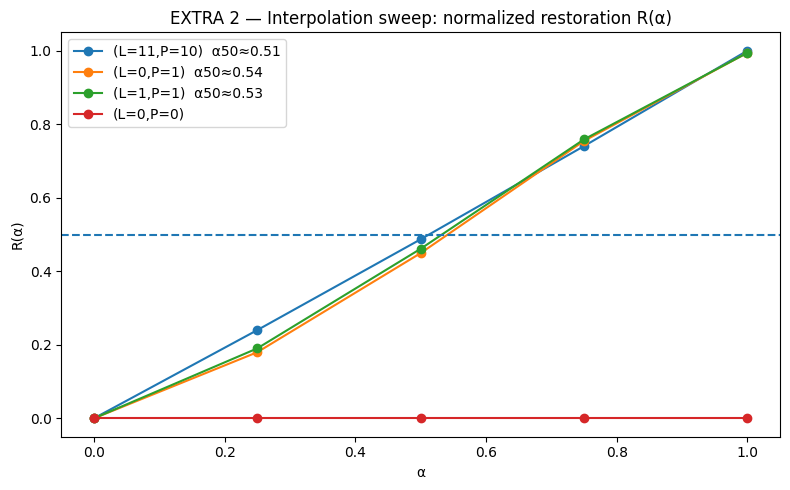

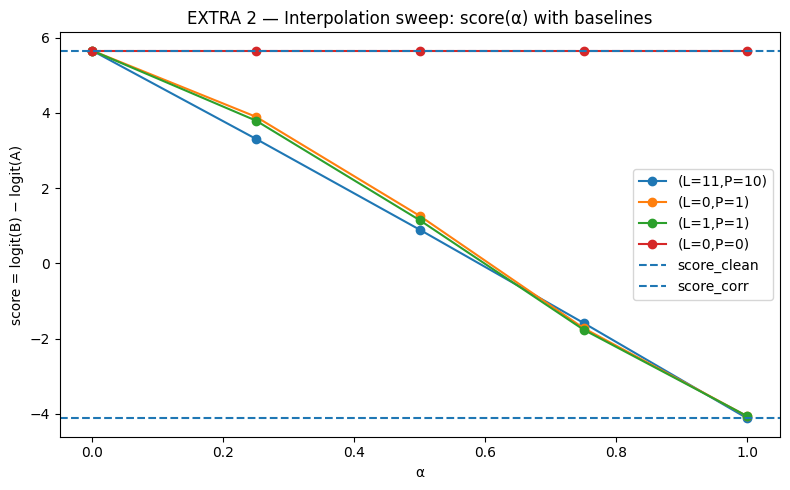


=== Curves (table) ===

Coord (L=11, P=10)  alpha50=0.5127979048181796
  α=0.00  score= 5.656242  R= -0.0000
  α=0.25  score= 3.308426  R=  0.2401
  α=0.50  score= 0.892990  R=  0.4870
  α=0.75  score=-1.586075  R=  0.7405
  α=1.00  score=-4.124077  R=  1.0000

Coord (L=0, P=1)  alpha50=0.5414549996037235
  α=0.00  score= 5.656242  R= -0.0000
  α=0.25  score= 3.897049  R=  0.1799
  α=0.50  score= 1.260918  R=  0.4494
  α=0.75  score=-1.723251  R=  0.7545
  α=1.00  score=-4.069115  R=  0.9944

Coord (L=1, P=1)  alpha50=0.532609123057202
  α=0.00  score= 5.656242  R= -0.0000
  α=0.25  score= 3.794891  R=  0.1903
  α=0.50  score= 1.145706  R=  0.4612
  α=0.75  score=-1.764702  R=  0.7588
  α=1.00  score=-4.067261  R=  0.9942

Coord (L=0, P=0)  alpha50=None
  α=0.00  score= 5.656242  R= -0.0000
  α=0.25  score= 5.656242  R= -0.0000
  α=0.50  score= 5.656242  R= -0.0000
  α=0.75  score= 5.656242  R= -0.0000
  α=1.00  score= 5.656242  R= -0.0000

Done ✅  (Estas 2 figuras suelen ser suficien

In [ ]:
import torch
import matplotlib.pyplot as plt

from mingpt.model import GPT
from mingpt.bpe import BPETokenizer

import interpolation_sweep as isweep

CLEAN_TEXT   = "Michelle Jones was a top-notch student. Michelle"
CORRUPT_TEXT = "Michelle Smith was a top-notch student. Michelle"
TOKEN_A_STR  = " Jones"
TOKEN_B_STR  = " Smith"

ALPHAS = [0.0, 0.25, 0.5, 0.75, 1.0]
TOP_K_HOTSPOTS = 3  
OUT_DIR = "artifacts/extra2"

def get_device() -> str:
    return "cuda" if torch.cuda.is_available() else "cpu"

device = get_device()
print("Device:", device)

bpe = BPETokenizer()
model = GPT.from_pretrained("gpt2").to(device).eval()

base = isweep.compute_baselines(
    model, bpe,
    clean_text=CLEAN_TEXT,
    corrupt_text=CORRUPT_TEXT,
    token_a_str=TOKEN_A_STR,
    token_b_str=TOKEN_B_STR,
    device=device,
    overwrite_cache=True,
)

print("\n=== Baselines ===")
print(f"score_clean  = {base.clean_score:.6f}")
print(f"score_corr   = {base.corrupt_score:.6f}")
print(f"T            = {base.seq_len}")
print(f"n_layer      = {base.n_layer}")

print("\nComputing full alpha=1 patch matrix (for hotspot selection)...")
M = isweep.full_patch_matrix(model, bpe, CORRUPT_TEXT, base, device=device)

hotspots, coldspot = isweep.select_hotspots(M, base, top_k=TOP_K_HOTSPOTS)
coords = list(hotspots)
if coldspot not in coords:
    coords.append(coldspot)

print("Hotspots:", hotspots)
print("Coldspot:", coldspot)

curves = []
for coord in coords:
    cv = isweep.interpolation_curve(
        model, bpe,
        corrupt_text=CORRUPT_TEXT,
        baselines=base,
        coord=coord,
        alphas=ALPHAS,
        device=device,
        source_coord=None,  # MATCH source (L,P)
    )
    curves.append(cv)

plt.figure(figsize=(8, 5))
plt.title("EXTRA 2 — Interpolation sweep: normalized restoration R(α)")
for cv in curves:
    L, P = cv.coord
    label = f"(L={L},P={P})"
    if cv.alpha50 is not None:
        label += f"  α50≈{cv.alpha50:.2f}"
    plt.plot(cv.alphas, cv.restorations, marker="o", label=label)

plt.axhline(0.5, linestyle="--")
plt.xlabel("α")
plt.ylabel("R(α)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.title("EXTRA 2 — Interpolation sweep: score(α) with baselines")
for cv in curves:
    L, P = cv.coord
    plt.plot(cv.alphas, cv.scores, marker="o", label=f"(L={L},P={P})")

plt.axhline(base.clean_score, linestyle="--", label="score_clean")
plt.axhline(base.corrupt_score, linestyle="--", label="score_corr")
plt.xlabel("α")
plt.ylabel("score = logit(B) − logit(A)")
plt.legend()
plt.tight_layout()
plt.show()

print("\n=== Curves (table) ===")
for cv in curves:
    L, P = cv.coord
    print(f"\nCoord (L={L}, P={P})  alpha50={cv.alpha50}")
    for a, s, r in zip(cv.alphas, cv.scores, cv.restorations):
        print(f"  α={a:>4.2f}  score={s:>9.6f}  R={r:>8.4f}")

print("\nDone ✅  (Estas 2 figuras suelen ser suficientes para justificar el 'dose–response'.)")


## EXTRA SECTION 3: Patch inside the block: after attention vs after MLP

In [ ]:
%%writefile extra3_intrablock_sweep.py
from __future__ import annotations

from dataclasses import dataclass
from typing import Optional, Sequence, Tuple

import torch


def _infer_device(model: torch.nn.Module) -> torch.device:
    try:
        return next(model.parameters()).device
    except StopIteration:
        return torch.device("cpu")


def single_token_id(bpe, token_str: str) -> int:
    ids = bpe(token_str)[0].tolist()
    if len(ids) != 1:
        raise ValueError(
            f"Target token string must map to exactly 1 BPE token. "
            f"Got {len(ids)} tokens for {repr(token_str)}: {ids}"
        )
    return int(ids[0])


def logit_diff_from_last_logits(last_logits_1d: torch.Tensor, *, token_a_id: int, token_b_id: int) -> float:
    a = float(last_logits_1d[token_a_id])
    b = float(last_logits_1d[token_b_id])
    return b - a


@dataclass(frozen=True)
class Extra3Result:
    post_attn_matrix: torch.Tensor  # (n_layers, T) on CPU float32
    post_mlp_matrix: torch.Tensor   # (n_layers, T) on CPU float32
    n_layers: int
    seq_len: int
    clean_score: float
    corrupt_score: float
    token_a_str: str
    token_b_str: str
    token_a_id: int
    token_b_id: int
    clean_text: str
    corrupt_text: str


@torch.no_grad()
def sweep_location_from_ids(
    model,
    idx_corrupt: torch.LongTensor,
    *,
    token_a_id: int,
    token_b_id: int,
    patch_location: str,
    layers: Optional[Sequence[int]] = None,
    positions: Optional[Sequence[int]] = None,
    progress: bool = False,
) -> torch.Tensor:
    if idx_corrupt.ndim != 2 or idx_corrupt.shape[0] != 1:
        raise ValueError(f"Expected idx_corrupt shape (1,T). Got {tuple(idx_corrupt.shape)}")

    device = _infer_device(model)
    idx_corrupt = idx_corrupt.to(device)

    n_layers = len(model.transformer.h)
    T = int(idx_corrupt.shape[1])

    layers = list(range(n_layers)) if layers is None else list(layers)
    positions = list(range(T)) if positions is None else list(positions)

    it = [(L, P) for L in layers for P in positions]
    if progress:
        try:
            from tqdm import tqdm  
            it = tqdm(it, desc=f"sweep({patch_location})", total=len(it))
        except Exception:
            pass

    mat = torch.empty((len(layers), len(positions)), dtype=torch.float32, device="cpu")
    layer_index = {L: i for i, L in enumerate(layers)}
    pos_index = {P: j for j, P in enumerate(positions)}

    for L, P in it:
        _logits, _loss = model(
            idx_corrupt,
            layer_to_patch=int(L),
            position_to_patch=int(P),
            patch_location=patch_location,
        )
        if model.last_logits is None:
            raise RuntimeError("model.last_logits was not set. Ensure forward() stores last_logits.")
        last = model.last_logits[0].detach()
        score = logit_diff_from_last_logits(last, token_a_id=token_a_id, token_b_id=token_b_id)
        mat[layer_index[L], pos_index[P]] = float(score)

    return mat


@torch.no_grad()
def run_extra3(
    model,
    bpe,
    *,
    clean_text: str,
    corrupt_text: str,
    token_a_str: str,
    token_b_str: str,
    overwrite_cache: bool = True,
    progress: bool = True,
) -> Extra3Result:
    device = _infer_device(model)

    idx_clean = bpe(clean_text).to(device)
    idx_corr = bpe(corrupt_text).to(device)

    if idx_clean.shape != idx_corr.shape:
        raise ValueError(
            f"Clean/Corrupt token length mismatch: clean={tuple(idx_clean.shape)}, corrupt={tuple(idx_corr.shape)}. "
            "They MUST have the same number of BPE tokens."
        )

    T = int(idx_clean.shape[1])
    n_layers = len(model.transformer.h)

    token_a_id = single_token_id(bpe, token_a_str)
    token_b_id = single_token_id(bpe, token_b_str)

    # 1) clean run: cache BOTH post_attn and post_mlp
    _ = model(idx_clean, cache_activations=True, overwrite_cache=overwrite_cache)
    if model.last_logits is None:
        raise RuntimeError("model.last_logits missing after clean run.")
    clean_score = logit_diff_from_last_logits(model.last_logits[0], token_a_id=token_a_id, token_b_id=token_b_id)

    # 2) corrupted baseline
    _ = model(idx_corr)
    if model.last_logits is None:
        raise RuntimeError("model.last_logits missing after corrupt run.")
    corrupt_score = logit_diff_from_last_logits(model.last_logits[0], token_a_id=token_a_id, token_b_id=token_b_id)

    # 3) sweeps
    post_attn = sweep_location_from_ids(
        model,
        idx_corr,
        token_a_id=token_a_id,
        token_b_id=token_b_id,
        patch_location="post_attn",
        progress=progress,
    )
    post_mlp = sweep_location_from_ids(
        model,
        idx_corr,
        token_a_id=token_a_id,
        token_b_id=token_b_id,
        patch_location="post_mlp",
        progress=progress,
    )

    return Extra3Result(
        post_attn_matrix=post_attn,
        post_mlp_matrix=post_mlp,
        n_layers=n_layers,
        seq_len=T,
        clean_score=float(clean_score),
        corrupt_score=float(corrupt_score),
        token_a_str=token_a_str,
        token_b_str=token_b_str,
        token_a_id=token_a_id,
        token_b_id=token_b_id,
        clean_text=clean_text,
        corrupt_text=corrupt_text,
    )


Writing extra3_intrablock_sweep.py


In [ ]:
%%writefile extra3_intrablock_driver.py
from __future__ import annotations

from pathlib import Path

import torch

from mingpt.model import GPT
from mingpt.bpe import BPETokenizer
from mingpt.utils import set_seed

import tokenization_protocol as tp

from extra3_intrablock_sweep import run_extra3
from section10_visualization import (
    HeatmapMeta,
    decode_prompt_token_labels,
    plot_logit_diff_heatmap,
    save_figure_publication_quality,
    save_heatmap_artifacts,
)


def get_device() -> str:
    return "cuda" if torch.cuda.is_available() else "cpu"


@torch.no_grad()
def main() -> None:
    set_seed(3407)
    device = get_device()
    print("Device:", device)

    CLEAN_TEXT = "Michelle Jones was a top-notch student. Michelle"
    CORRUPT_TEXT = "Michelle Smith was a top-notch student. Michelle"
    TOKEN_A = " Jones"  # clean-consistent
    TOKEN_B = " Smith"  # corrupt-consistent

    # Load model + tokenizer
    model = GPT.from_pretrained("gpt2").to(device).eval()
    bpe = BPETokenizer()

    # Validate token constraints (recommended)
    comp = tp.validate_pair(
        bpe=bpe,
        clean_text=CLEAN_TEXT,
        corrupt_text=CORRUPT_TEXT,
        require_same_length=True,
        require_one_token_diff=True,
    )
    print(tp.describe_pair(comp))
    print("Changed token position:", comp.diff_positions[0])

    # Run EXTRA 3
    res = run_extra3(
        model,
        bpe,
        clean_text=CLEAN_TEXT,
        corrupt_text=CORRUPT_TEXT,
        token_a_str=TOKEN_A,
        token_b_str=TOKEN_B,
        overwrite_cache=True,
        progress=True,
    )

    print("\n=== Baselines ===")
    print(f"clean score   = {res.clean_score:.4f}")
    print(f"corrupt score = {res.corrupt_score:.4f}")
    print(f"delta (corrupt-clean) = {res.corrupt_score - res.clean_score:.4f}")

    out_dir = Path("artifacts/extra3_intrablock")
    out_dir.mkdir(parents=True, exist_ok=True)

    token_labels = decode_prompt_token_labels(bpe, CLEAN_TEXT)

    # Save raw matrices for reproducibility
    torch.save(
        {
            "post_attn": res.post_attn_matrix,
            "post_mlp": res.post_mlp_matrix,
            "clean_score": res.clean_score,
            "corrupt_score": res.corrupt_score,
            "token_a": res.token_a_str,
            "token_b": res.token_b_str,
            "clean_text": res.clean_text,
            "corrupt_text": res.corrupt_text,
            "seq_len": res.seq_len,
            "n_layers": res.n_layers,
        },
        out_dir / "extra3_matrices.pt",
    )
    print("Saved:", (out_dir / "extra3_matrices.pt").resolve())

    title_attn = f"EXTRA 3 — post-attn patching: logit({repr(TOKEN_B)}) − logit({repr(TOKEN_A)})"
    meta_attn = HeatmapMeta(
        metric_title=title_attn,
        clean_text=CLEAN_TEXT,
        corrupt_text=CORRUPT_TEXT,
        token_a_str=TOKEN_A,
        token_b_str=TOKEN_B,
        n_layers=res.n_layers,
        seq_len=res.seq_len,
        token_labels=token_labels,
    )
    save_heatmap_artifacts(out_dir=out_dir / "post_attn", matrix=res.post_attn_matrix, meta=meta_attn)
    fig, _ = plot_logit_diff_heatmap(
        res.post_attn_matrix,
        token_labels=token_labels,
        metric_title=title_attn,
        show_token_strings=True,
        center_zero=True,
        include_pos_in_label=True,
    )
    save_figure_publication_quality(fig, out_basepath=out_dir / "post_attn" / "heatmap_post_attn", formats=("png", "pdf"))

    title_mlp = f"EXTRA 3 — post-MLP patching: logit({repr(TOKEN_B)}) − logit({repr(TOKEN_A)})"
    meta_mlp = HeatmapMeta(
        metric_title=title_mlp,
        clean_text=CLEAN_TEXT,
        corrupt_text=CORRUPT_TEXT,
        token_a_str=TOKEN_A,
        token_b_str=TOKEN_B,
        n_layers=res.n_layers,
        seq_len=res.seq_len,
        token_labels=token_labels,
    )
    save_heatmap_artifacts(out_dir=out_dir / "post_mlp", matrix=res.post_mlp_matrix, meta=meta_mlp)
    fig, _ = plot_logit_diff_heatmap(
        res.post_mlp_matrix,
        token_labels=token_labels,
        metric_title=title_mlp,
        show_token_strings=True,
        center_zero=True,
        include_pos_in_label=True,
    )
    save_figure_publication_quality(fig, out_basepath=out_dir / "post_mlp" / "heatmap_post_mlp", formats=("png", "pdf"))

    print("\n✅ Done. Heatmaps saved under:", out_dir.resolve())


if __name__ == "__main__":
    main()


Writing extra3_intrablock_driver.py


In [3]:
%%writefile test_extra3_intrablock.py
import pytest
import torch

from mingpt.model import GPT
from mingpt.utils import set_seed


def make_tiny_model():
    set_seed(123)
    cfg = GPT.get_default_config()
    cfg.model_type = "gpt-nano"   # tiny, no downloads
    cfg.vocab_size = 101
    cfg.block_size = 32
    m = GPT(cfg).eval()
    return m


def make_pair(vocab_size: int, T: int = 12, changed_pos: int = 3):
    set_seed(999)
    clean = torch.randint(0, vocab_size, (1, T), dtype=torch.long)
    corrupt = clean.clone()
    corrupt[0, changed_pos] = (corrupt[0, changed_pos] + 1) % vocab_size
    return clean, corrupt, changed_pos


def test_caches_exist_for_both_locations_after_clean_cache():
    m = make_tiny_model()
    vocab = m.transformer.wte.num_embeddings
    clean, _, _ = make_pair(vocab)

    _ = m(clean, cache_activations=True, overwrite_cache=True)

    assert m.clean_post_attn_activations is not None
    assert m.clean_post_mlp_activations is not None
    assert m.clean_activations is not None  # backward compatibility (post-MLP)

    n_layers = len(m.transformer.h)
    T = clean.shape[1]
    assert len(m.clean_post_attn_activations) == n_layers
    assert len(m.clean_post_attn_activations[0]) == T
    assert len(m.clean_post_mlp_activations) == n_layers
    assert len(m.clean_post_mlp_activations[0]) == T

    # clean_activations should match post-MLP cache
    assert torch.allclose(m.clean_activations[0][0], m.clean_post_mlp_activations[0][0])


def test_patch_post_attn_changes_logits():
    m = make_tiny_model()
    vocab = m.transformer.wte.num_embeddings
    clean, corrupt, p = make_pair(vocab)

    _ = m(clean, cache_activations=True, overwrite_cache=True)
    _ = m(corrupt)
    base = m.last_logits.clone()

    _ = m(corrupt, layer_to_patch=0, position_to_patch=p, patch_location="post_attn")
    assert m.last_patch_location == "post_attn"
    assert m.last_patch == (0, p)
    assert not torch.allclose(base, m.last_logits)


def test_patch_post_mlp_changes_logits():
    m = make_tiny_model()
    vocab = m.transformer.wte.num_embeddings
    clean, corrupt, p = make_pair(vocab)

    _ = m(clean, cache_activations=True, overwrite_cache=True)
    _ = m(corrupt)
    base = m.last_logits.clone()

    _ = m(corrupt, layer_to_patch=0, position_to_patch=p, patch_location="post_mlp")
    assert m.last_patch_location == "post_mlp"
    assert m.last_patch == (0, p)
    assert not torch.allclose(base, m.last_logits)


def test_post_attn_and_post_mlp_patches_produce_different_outputs_typically():
    m = make_tiny_model()
    vocab = m.transformer.wte.num_embeddings
    clean, corrupt, p = make_pair(vocab)

    _ = m(clean, cache_activations=True, overwrite_cache=True)

    _ = m(corrupt, layer_to_patch=1, position_to_patch=p, patch_location="post_attn")
    out_attn = m.last_logits.clone()

    _ = m(corrupt, layer_to_patch=1, position_to_patch=p, patch_location="post_mlp")
    out_mlp = m.last_logits.clone()

    # In a random network these should differ (very high probability).
    assert not torch.allclose(out_attn, out_mlp)


def test_invalid_patch_location_raises():
    m = make_tiny_model()
    vocab = m.transformer.wte.num_embeddings
    clean, corrupt, p = make_pair(vocab)

    _ = m(clean, cache_activations=True, overwrite_cache=True)

    with pytest.raises(ValueError):
        _ = m(corrupt, layer_to_patch=0, position_to_patch=p, patch_location="after_unicorns")


def test_patch_and_cache_activations_is_forbidden():
    m = make_tiny_model()
    vocab = m.transformer.wte.num_embeddings
    clean, corrupt, p = make_pair(vocab)

    _ = m(clean, cache_activations=True, overwrite_cache=True)

    with pytest.raises(RuntimeError):
        _ = m(
            corrupt,
            layer_to_patch=0,
            position_to_patch=p,
            patch_location="post_mlp",
            cache_activations=True,
        )


Writing test_extra3_intrablock.py


In [ ]:
!pytest -q test_extra3_intrablock.py

........................................................................ [ 69%]
...............................                                          [100%]
103 passed in 44.80s


## EXTRA SECTION 3 RUN

In [ ]:
%%writefile extra3_intrablock_check.py
from __future__ import annotations

import torch
from mingpt.model import GPT
from mingpt.bpe import BPETokenizer

CLEAN_TEXT   = "Michelle Jones was a top-notch student. Michelle"
CORRUPT_TEXT = "Michelle Smith was a top-notch student. Michelle"
TOKEN_A = " Jones"  
TOKEN_B = " Smith"  

def single_token_id(bpe: BPETokenizer, s: str) -> int:
    ids = bpe(s)[0].tolist()
    if len(ids) != 1:
        raise ValueError(f"{s!r} is not a single BPE token. Got ids={ids}")
    return int(ids[0])

def score_from_last_logits(last_logits_1d: torch.Tensor, *, a_id: int, b_id: int) -> float:
    return float(last_logits_1d[b_id] - last_logits_1d[a_id])

@torch.no_grad()
def main() -> None:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)

    model = GPT.from_pretrained("gpt2").to(device).eval()
    bpe = BPETokenizer()

    idx_clean = bpe(CLEAN_TEXT).to(device)
    idx_corr  = bpe(CORRUPT_TEXT).to(device)

    if idx_clean.shape != idx_corr.shape:
        raise RuntimeError(f"Token length mismatch: clean={idx_clean.shape}, corrupt={idx_corr.shape}")

    T = idx_clean.shape[1]
    n_layers = len(model.transformer.h)
    print(f"Seq len T={T}, n_layers={n_layers}")

    a_id = single_token_id(bpe, TOKEN_A)
    b_id = single_token_id(bpe, TOKEN_B)

    # CLEAN run (this must create BOTH intra-block caches)
    _ = model(idx_clean, cache_activations=True, overwrite_cache=True)
    print("Clean caches present?",
          "post_attn:", model.clean_post_attn_activations is not None,
          "| post_mlp:", model.clean_post_mlp_activations is not None)

    # Show cache dimensions (must be 12 x T for GPT-2 small)
    print("clean_post_attn dims:", len(model.clean_post_attn_activations), "x", len(model.clean_post_attn_activations[0]))
    print("clean_post_mlp  dims:", len(model.clean_post_mlp_activations),  "x", len(model.clean_post_mlp_activations[0]))

    score_clean = score_from_last_logits(model.last_logits[0], a_id=a_id, b_id=b_id)

    # CORR baseline (no patch)
    _ = model(idx_corr)
    score_corr = score_from_last_logits(model.last_logits[0], a_id=a_id, b_id=b_id)

    print("\n=== Baselines ===")
    print(f"score_clean = {score_clean:.4f}")
    print(f"score_corr  = {score_corr:.4f}")
    print("Expected (for this pair): score_clean < score_corr (often clean is negative, corrupt is positive).")

    # Choose a “meaningful” target: the changed-token position is usually 1 for this classic prompt,
    # but we’ll just test a couple positions safely.
    test_L = 6
    test_P = 1 if T > 1 else 0

    # Patch at post-attn
    _ = model(idx_corr,
              layer_to_patch=test_L,
              position_to_patch=test_P,
              patch_location="post_attn")
    s_attn = score_from_last_logits(model.last_logits[0], a_id=a_id, b_id=b_id)
    print("\n=== Patch test (post_attn) ===")
    print("last_patch:", model.last_patch, "last_patch_location:", model.last_patch_location)
    print(f"score_post_attn = {s_attn:.4f}  | delta_vs_corr = {s_attn - score_corr:+.4f}")

    # Patch at post-MLP
    _ = model(idx_corr,
              layer_to_patch=test_L,
              position_to_patch=test_P,
              patch_location="post_mlp")
    s_mlp = score_from_last_logits(model.last_logits[0], a_id=a_id, b_id=b_id)
    print("\n=== Patch test (post_mlp) ===")
    print("last_patch:", model.last_patch, "last_patch_location:", model.last_patch_location)
    print(f"score_post_mlp  = {s_mlp:.4f}  | delta_vs_corr = {s_mlp - score_corr:+.4f}")

    # The key EXTRA 3 assertion: the two locations should not be identical everywhere.
    print("\n=== Intra-block location difference (single cell) ===")
    print(f"abs(score_post_attn - score_post_mlp) = {abs(s_attn - s_mlp):.6f}")
    print("If this is exactly 0.0 for many tested cells, your patch_location may not be applied correctly.")

if __name__ == "__main__":
    main()


Overwriting extra3_intrablock_check.py


In [4]:
!python extra3_intrablock_check.py

Device: cuda
number of parameters: 124.44M
Seq len T=11, n_layers=12
Clean caches present? post_attn: True | post_mlp: True
clean_post_attn dims: 12 x 11
clean_post_mlp  dims: 12 x 11

=== Baselines ===
score_clean = -4.1241
score_corr  = 5.6562
Expected (for this pair): score_clean < score_corr (often clean is negative, corrupt is positive).

=== Patch test (post_attn) ===
last_patch: (6, 1) last_patch_location: post_attn
score_post_attn = 5.6416  | delta_vs_corr = -0.0146

=== Patch test (post_mlp) ===
last_patch: (6, 1) last_patch_location: post_mlp
score_post_mlp  = -3.1509  | delta_vs_corr = -8.8071

=== Intra-block location difference (single cell) ===
abs(score_post_attn - score_post_mlp) = 8.792526
If this is exactly 0.0 for many tested cells, your patch_location may not be applied correctly.


In [5]:
%%writefile extra3_intrablock_sweep_driver.py
from __future__ import annotations

from pathlib import Path
import torch

from mingpt.model import GPT
from mingpt.bpe import BPETokenizer
from mingpt.utils import set_seed

# Reuse your plotting utilities (already in your project)
from section10_visualization import (
    decode_prompt_token_labels,
    plot_logit_diff_heatmap,
    save_figure_publication_quality,
)

CLEAN_TEXT   = "Michelle Jones was a top-notch student. Michelle"
CORRUPT_TEXT = "Michelle Smith was a top-notch student. Michelle"
TOKEN_A = " Jones"
TOKEN_B = " Smith"

def single_token_id(bpe: BPETokenizer, s: str) -> int:
    ids = bpe(s)[0].tolist()
    if len(ids) != 1:
        raise ValueError(f"{s!r} is not a single BPE token. Got ids={ids}")
    return int(ids[0])

def score_from_last_logits(last_logits_1d: torch.Tensor, *, a_id: int, b_id: int) -> float:
    return float(last_logits_1d[b_id] - last_logits_1d[a_id])

@torch.no_grad()
def main() -> None:
    set_seed(3407)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)

    model = GPT.from_pretrained("gpt2").to(device).eval()
    bpe = BPETokenizer()

    idx_clean = bpe(CLEAN_TEXT).to(device)
    idx_corr  = bpe(CORRUPT_TEXT).to(device)
    if idx_clean.shape != idx_corr.shape:
        raise RuntimeError(f"Token length mismatch: clean={idx_clean.shape}, corrupt={idx_corr.shape}")

    T = int(idx_clean.shape[1])
    n_layers = len(model.transformer.h)
    print(f"Seq len T={T}, n_layers={n_layers}")

    a_id = single_token_id(bpe, TOKEN_A)
    b_id = single_token_id(bpe, TOKEN_B)

    # Clean cache (must populate both intra-block banks)
    _ = model(idx_clean, cache_activations=True, overwrite_cache=True)
    score_clean = score_from_last_logits(model.last_logits[0], a_id=a_id, b_id=b_id)

    # Corrupt baseline
    _ = model(idx_corr)
    score_corr = score_from_last_logits(model.last_logits[0], a_id=a_id, b_id=b_id)

    print("\n=== Baselines ===")
    print(f"score_clean = {score_clean:.4f}")
    print(f"score_corr  = {score_corr:.4f}")

    out_dir = Path("artifacts/extra3_intrablock")
    out_dir.mkdir(parents=True, exist_ok=True)

    token_labels = decode_prompt_token_labels(bpe, CLEAN_TEXT)

    mats = {}
    for loc in ["post_attn", "post_mlp"]:
        print(f"\nSweeping patches at location: {loc}")
        mat = torch.empty((n_layers, T), dtype=torch.float32)

        for L in range(n_layers):
            for P in range(T):
                _ = model(idx_corr,
                          layer_to_patch=L,
                          position_to_patch=P,
                          patch_location=loc)
                s = score_from_last_logits(model.last_logits[0], a_id=a_id, b_id=b_id)
                mat[L, P] = float(s)

        mats[loc] = mat.cpu()
        torch.save(mat.cpu(), out_dir / f"matrix_{loc}.pt")
        print("Saved:", (out_dir / f"matrix_{loc}.pt").resolve())

        title = f"EXTRA 3 — {loc}: logit({TOKEN_B!r}) − logit({TOKEN_A!r})"
        fig, ax = plot_logit_diff_heatmap(
            mat,
            token_labels=token_labels,
            metric_title=title,
            show_token_strings=True,
            center_zero=True,
            include_pos_in_label=True,
        )
        save_figure_publication_quality(fig, out_basepath=out_dir / f"heatmap_{loc}", formats=("png", "pdf"), dpi=300)
        print("Saved heatmap figures for:", loc)

    # Key check: matrices should not be identical
    diff = (mats["post_attn"] - mats["post_mlp"]).abs()
    print("\n=== EXTRA 3 matrix difference stats ===")
    print("max |post_attn - post_mlp| =", float(diff.max()))
    print("mean|post_attn - post_mlp| =", float(diff.mean()))
    print("If max is exactly 0.0, your intra-block split is not taking effect.")

    # Optional: show “restoration” deltas relative to corrupted baseline
    # (patched - corrupt): negative means moving toward clean if clean < corrupt for your pair.
    delta_attn = mats["post_attn"] - float(score_corr)
    delta_mlp  = mats["post_mlp"]  - float(score_corr)
    print("\nDelta sanity (patched - corrupt):")
    print("post_attn: min=", float(delta_attn.min()), "max=", float(delta_attn.max()))
    print("post_mlp : min=", float(delta_mlp.min()),  "max=", float(delta_mlp.max()))

if __name__ == "__main__":
    main()


Overwriting extra3_intrablock_sweep_driver.py


In [6]:
!python extra3_intrablock_sweep_driver.py


Device: cuda
number of parameters: 124.44M
Seq len T=11, n_layers=12

=== Baselines ===
score_clean = -4.1241
score_corr  = 5.6562

Sweeping patches at location: post_attn
Saved: /home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/artifacts/extra3_intrablock/matrix_post_attn.pt
Saved heatmap figures for: post_attn

Sweeping patches at location: post_mlp
Saved: /home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/artifacts/extra3_intrablock/matrix_post_mlp.pt
Saved heatmap figures for: post_mlp

=== EXTRA 3 matrix difference stats ===
max |post_attn - post_mlp| = 9.767166137695312
mean|post_attn - post_mlp| = 0.8032954335212708
If max is exactly 0.0, your intra-block split is not taking effect.

Delta sanity (patched - corrupt):
post_attn: min= -3.4107208251953125 max= 0.04366302490234375
post_mlp : min= -9.780319213867188 max= 0.0342254638671875


In [1]:
!pytest -q

........................................................................ [ 69%]
...............................                                          [100%]
103 passed in 49.46s


In [ ]:
%%writefile extra3_intrablock_heatmap.py

from __future__ import annotations

import argparse
from pathlib import Path
from typing import Any, Dict, Optional, Tuple, List

import numpy as np

import matplotlib
matplotlib.use("Agg")  
import matplotlib.pyplot as plt  
from matplotlib.colors import TwoSlopeNorm  

import torch  


def _to_numpy(x: Any) -> np.ndarray:
    if isinstance(x, np.ndarray):
        return x
    if torch.is_tensor(x):
        return x.detach().cpu().float().numpy()
    return np.asarray(x, dtype=np.float32)


def _extract_matrix_and_labels(obj: Any) -> Tuple[np.ndarray, Optional[List[str]], Optional[List[str]]]:
    xlabels = None
    ylabels = None

    if torch.is_tensor(obj):
        return _to_numpy(obj), None, None

    if isinstance(obj, dict):
        candidates = ["matrix", "values", "scores", "heatmap", "data", "arr"]
        mat = None
        for k in candidates:
            if k in obj and (torch.is_tensor(obj[k]) or isinstance(obj[k], (list, tuple, np.ndarray))):
                mat = obj[k]
                break

        if mat is None:
            for v in obj.values():
                if torch.is_tensor(v) or isinstance(v, (list, tuple, np.ndarray)):
                    arr = _to_numpy(v)
                    if arr.ndim >= 2:
                        mat = v
                        break

        if mat is None:
            raise ValueError("No pude encontrar una matriz 2D dentro del .pt (dict).")

        M = _to_numpy(mat)

        for tk in ["tokens", "token_strs", "token_labels", "xlabels"]:
            if tk in obj and isinstance(obj[tk], (list, tuple)) and all(isinstance(t, str) for t in obj[tk]):
                xlabels = list(obj[tk])
                break

        for lk in ["layers", "layer_labels", "ylabels"]:
            if lk in obj and isinstance(obj[lk], (list, tuple)):
                if all(isinstance(t, str) for t in obj[lk]):
                    ylabels = list(obj[lk])
                elif all(isinstance(t, (int, np.integer)) for t in obj[lk]):
                    ylabels = [f"L{int(t)}" for t in obj[lk]]
                break

        return M, xlabels, ylabels

    M = _to_numpy(obj)
    if M.ndim < 2:
        raise ValueError(f"The loaded object does not seem to be a 2D matrix. ndim={M.ndim}")
    return M, None, None


def _symmetric_norm(M: np.ndarray, *, eps: float = 1e-12) -> Optional[TwoSlopeNorm]:
    mmin = float(np.nanmin(M))
    mmax = float(np.nanmax(M))
    v = max(abs(mmin), abs(mmax))
    if not np.isfinite(v) or v < eps:
        return None
    return TwoSlopeNorm(vmin=-v, vcenter=0.0, vmax=+v)


def plot_heatmap(
    M: np.ndarray,
    *,
    title: str,
    out_path: Path,
    xlabel: str = "Token position",
    ylabel: str = "Layer",
    xlabels: Optional[List[str]] = None,
    ylabels: Optional[List[str]] = None,
    cbar_label: str = "Value",
) -> None:
    out_path.parent.mkdir(parents=True, exist_ok=True)

    if M.ndim > 2:
        M = np.squeeze(M)
    if M.ndim != 2:
        raise ValueError(f"I was waiting for 2D, I got shape={M.shape}")

    norm = _symmetric_norm(M)

    fig = plt.figure(figsize=(10, 6))
    ax = plt.gca()

    im = ax.imshow(M, aspect="auto", interpolation="nearest", norm=norm)
    ax.set_title(title)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    n_layers, T = M.shape[0], M.shape[1]

    if ylabels is not None and len(ylabels) == n_layers:
        ax.set_yticks(np.arange(n_layers))
        ax.set_yticklabels(ylabels)
    else:
        step = 1 if n_layers <= 16 else max(1, n_layers // 12)
        yt = np.arange(0, n_layers, step)
        ax.set_yticks(yt)
        ax.set_yticklabels([str(int(i)) for i in yt])

    if xlabels is not None and len(xlabels) == T:
        step = 1 if T <= 16 else max(1, T // 12)
        xt = np.arange(0, T, step)
        ax.set_xticks(xt)
        ax.set_xticklabels([xlabels[int(i)] for i in xt], rotation=45, ha="right")
    else:
        step = 1 if T <= 16 else max(1, T // 12)
        xt = np.arange(0, T, step)
        ax.set_xticks(xt)
        ax.set_xticklabels([str(int(i)) for i in xt])

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)

    plt.tight_layout()
    fig.savefig(out_path, dpi=200)
    plt.close(fig)


def main() -> int:
    ap = argparse.ArgumentParser()
    ap.add_argument(
        "--artifact_dir",
        type=str,
        default="artifacts/extra3_intrablock",
        help="Folder that contain matrix_post_attn.pt and matrix_post_mlp.pt",
    )
    ap.add_argument(
        "--post_attn",
        type=str,
        default="matrix_post_attn.pt",
        help="Name of the .pt for post_attn (inside artifact_dir)",
    )
    ap.add_argument(
        "--post_mlp",
        type=str,
        default="matrix_post_mlp.pt",
        help="Name of the .pt para post_mlp (inside artifact_dir)",
    )
    ap.add_argument(
        "--out_dir",
        type=str,
        default="artifacts/extra3_intrablock/heatmaps",
        help="Salida para los PNG",
    )
    ap.add_argument(
        "--value_name",
        type=str,
        default="Logit-diff score (or effect)",
        help="Label of the colorbar.",
    )
    args = ap.parse_args()

    artifact_dir = Path(args.artifact_dir).expanduser().resolve()
    out_dir = Path(args.out_dir).expanduser().resolve()
    out_dir.mkdir(parents=True, exist_ok=True)

    p_attn = artifact_dir / args.post_attn
    p_mlp = artifact_dir / args.post_mlp

    if not p_attn.exists():
        raise FileNotFoundError(f"It does not exist: {p_attn}")
    if not p_mlp.exists():
        raise FileNotFoundError(f"It does not exist: {p_mlp}")

    obj_attn = torch.load(str(p_attn), map_location="cpu")
    obj_mlp = torch.load(str(p_mlp), map_location="cpu")

    M_attn, xlabels_a, ylabels_a = _extract_matrix_and_labels(obj_attn)
    M_mlp,  xlabels_m, ylabels_m = _extract_matrix_and_labels(obj_mlp)

    xlabels = xlabels_a or xlabels_m
    ylabels = ylabels_a or ylabels_m

    if M_attn.shape != M_mlp.shape:
        raise ValueError(f"Shape mismatch: post_attn {M_attn.shape} vs post_mlp {M_mlp.shape}")

    M_delta = M_mlp - M_attn

    plot_heatmap(
        M_attn,
        title="EXTRA 3 — Patch location: post_attn",
        out_path=out_dir / "extra3_post_attn_heatmap.png",
        xlabels=xlabels,
        ylabels=ylabels,
        cbar_label=args.value_name,
    )

    plot_heatmap(
        M_mlp,
        title="EXTRA 3 — Patch location: post_mlp",
        out_path=out_dir / "extra3_post_mlp_heatmap.png",
        xlabels=xlabels,
        ylabels=ylabels,
        cbar_label=args.value_name,
    )

    plot_heatmap(
        M_delta,
        title="EXTRA 3 — Delta: (post_mlp - post_attn)",
        out_path=out_dir / "extra3_post_mlp_minus_post_attn_heatmap.png",
        xlabels=xlabels,
        ylabels=ylabels,
        cbar_label=f"Δ({args.value_name})",
    )

    print(f"✅ Saved heatmaps to: {out_dir}")
    print(f" - {out_dir / 'extra3_post_attn_heatmap.png'}")
    print(f" - {out_dir / 'extra3_post_mlp_heatmap.png'}")
    print(f" - {out_dir / 'extra3_post_mlp_heatmap.png'}")
    print(f" - {out_dir / 'extra3_post_mlp_minus_post_attn_heatmap.png'}")
    return 0


if __name__ == "__main__":
    raise SystemExit(main())


Writing extra3_intrablock_heatmap.py


In [ ]:
!python extra3_intrablock_heatmap.py \
  --artifact_dir artifacts/extra3_intrablock \
  --out_dir artifacts/extra3_intrablock/heatmaps \
  --value_name "logit(Smith) - logit(Jones)"

✅ Saved heatmaps to: /home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/artifacts/extra3_intrablock/heatmaps
 - /home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/artifacts/extra3_intrablock/heatmaps/extra3_post_attn_heatmap.png
 - /home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/artifacts/extra3_intrablock/heatmaps/extra3_post_mlp_heatmap.png
 - /home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/artifacts/extra3_intrablock/heatmaps/extra3_post_mlp_heatmap.png
 - /home/bledyx/UA/master-ia/TPLN/code/lvl1/lvl2/tpln-practice2/artifacts/extra3_intrablock/heatmaps/extra3_post_mlp_minus_post_attn_heatmap.png


In [1]:
!pytest -q

........................................................................ [ 69%]
...............................                                          [100%]
103 passed in 49.46s
